In [1]:
!pip install -r ../../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.4.2-cp311-cp311-linux_x86_64.whl
  Using cached Keras-2.4.3-py2.py3-none-any.whl.metadata (1.5 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.5.0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.5.0


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'SCRNN_rotation'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

# Imports

In [3]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

2025-05-31 01:13:40.157288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 01:13:40.157366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 01:13:40.159168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 01:13:40.171948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

## Dataset in a pandas Dataframe

In [4]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [5]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [6]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.keras'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [7]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [8]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [9]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [10]:
model = neural_networks.base_scrnn(in_shp)

model.summary()

2025-05-31 01:13:50.675891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 batch_normalization (Batch  (None, 128, 2)            8         
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 124, 128)          1408      
                                                                 
 max_pooling1d (MaxPooling1  (None, 41, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 128)           82048     
                                                                 
 lstm (LSTM)                 (None, 37, 128)           131584

### Train the model

In [11]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
from keras.layers import Permute
filepath = NEURAL_NETWORK_FILENAME

X_train = Permute((2, 1))(X_train)
X_test = Permute((2, 1))(X_test)

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


2025-05-31 01:14:04.820393: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-31 01:14:06.843232: I external/local_xla/xla/service/service.cc:168] XLA service 0x7faa9897c2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-31 01:14:06.843292: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-31 01:14:06.853894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748654047.028488   11137 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


581/581 [==============================] - 52s 62ms/step - loss: 1.5458 - accuracy: 0.4074 - val_loss: 1.8010 - val_accuracy: 0.3136
Epoch 2/100
581/581 [==============================] - 34s 58ms/step - loss: 1.2357 - accuracy: 0.5259 - val_loss: 1.1852 - val_accuracy: 0.5436
Epoch 3/100
581/581 [==============================] - 33s 57ms/step - loss: 1.1766 - accuracy: 0.5498 - val_loss: 1.1733 - val_accuracy: 0.5513
Epoch 4/100
581/581 [==============================] - 33s 56ms/step - loss: 1.1530 - accuracy: 0.5580 - val_loss: 1.1328 - val_accuracy: 0.5622
Epoch 5/100
581/581 [==============================] - 34s 58ms/step - loss: 1.1397 - accuracy: 0.5645 - val_loss: 1.1135 - val_accuracy: 0.5779
Epoch 6/100
581/581 [==============================] - 34s 58ms/step - loss: 1.1236 - accuracy: 0.5737 - val_loss: 1.0972 - val_accuracy: 0.5869
Epoch 7/100
581/581 [==============================] - 34s 58ms/step - loss: 1.1145 - accuracy: 0.5801 - val_loss: 1.0821 - val_accuracy: 0.59

 22/581 [>.............................] - ETA: 13s - loss: 2.6035

 25/581 [>.............................] - ETA: 13s - loss: 2.5734

 28/581 [>.............................] - ETA: 13s - loss: 2.5450

 31/581 [>.............................] - ETA: 13s - loss: 2.5182

 34/581 [>.............................] - ETA: 13s - loss: 2.4928

 37/581 [>.............................] - ETA: 13s - loss: 2.4686

 40/581 [=>............................] - ETA: 12s - loss: 2.4456

 43/581 [=>............................] - ETA: 12s - loss: 2.4236

 45/581 [=>............................] - ETA: 12s - loss: 2.4095

 47/581 [=>............................] - ETA: 12s - loss: 2.3957

 49/581 [=>............................] - ETA: 13s - loss: 2.3824

 52/581 [=>............................] - ETA: 12s - loss: 2.3630

 55/581 [=>............................] - ETA: 12s - loss: 2.3444

 58/581 [=>............................] - ETA: 12s - loss: 2.3267

 61/581 [==>...........................] - ETA: 12s - loss: 2.3097

 64/581 [==>...........................] - ETA: 12s - loss: 2.2934

 67/581 [==>...........................] - ETA: 12s - loss: 2.2778

 69/581 [==>...........................] - ETA: 12s - loss: 2.2677

 72/581 [==>...........................] - ETA: 12s - loss: 2.2531



 74/581 [==>...........................] - ETA: 12s - loss: 2.2437

 76/581 [==>...........................] - ETA: 12s - loss: 2.2345

 78/581 [===>..........................] - ETA: 12s - loss: 2.2256

 80/581 [===>..........................] - ETA: 12s - loss: 2.2169

 83/581 [===>..........................] - ETA: 12s - loss: 2.2042

 86/581 [===>..........................] - ETA: 12s - loss: 2.1921

 88/581 [===>..........................] - ETA: 12s - loss: 2.1842

 90/581 [===>..........................] - ETA: 12s - loss: 2.1765

 92/581 [===>..........................] - ETA: 12s - loss: 2.1690

 95/581 [===>..........................] - ETA: 12s - loss: 2.1580



 97/581 [====>.........................] - ETA: 12s - loss: 2.1508



 99/581 [====>.........................] - ETA: 11s - loss: 2.1439

101/581 [====>.........................] - ETA: 12s - loss: 2.1371

103/581 [====>.........................] - ETA: 12s - loss: 2.1304

105/581 [====>.........................] - ETA: 11s - loss: 2.1239

107/581 [====>.........................] - ETA: 11s - loss: 2.1175

109/581 [====>.........................] - ETA: 11s - loss: 2.1112

111/581 [====>.........................] - ETA: 11s - loss: 2.1051

113/581 [====>.........................] - ETA: 11s - loss: 2.0990

116/581 [====>.........................] - ETA: 11s - loss: 2.0902

118/581 [=====>........................] - ETA: 11s - loss: 2.0845

120/581 [=====>........................] - ETA: 11s - loss: 2.0788

122/581 [=====>........................] - ETA: 11s - loss: 2.0733

125/581 [=====>........................] - ETA: 11s - loss: 2.0651



128/581 [=====>........................] - ETA: 11s - loss: 2.0572

131/581 [=====>........................] - ETA: 11s - loss: 2.0495

134/581 [=====>........................] - ETA: 11s - loss: 2.0420

137/581 [======>.......................] - ETA: 11s - loss: 2.0346

140/581 [======>.......................] - ETA: 11s - loss: 2.0275

143/581 [======>.......................] - ETA: 11s - loss: 2.0205

146/581 [======>.......................] - ETA: 10s - loss: 2.0137

149/581 [======>.......................] - ETA: 10s - loss: 2.0071

152/581 [======>.......................] - ETA: 10s - loss: 2.0006

155/581 [=======>......................] - ETA: 10s - loss: 1.9943

158/581 [=======>......................] - ETA: 10s - loss: 1.9881

161/581 [=======>......................] - ETA: 10s - loss: 1.9820

164/581 [=======>......................] - ETA: 10s - loss: 1.9761

167/581 [=======>......................] - ETA: 10s - loss: 1.9703

170/581 [=======>......................] - ETA: 10s - loss: 1.9647

173/581 [=======>......................] - ETA: 10s - loss: 1.9591

176/581 [========>.....................] - ETA: 10s - loss: 1.9537

179/581 [========>.....................] - ETA: 10s - loss: 1.9484

182/581 [========>.....................] - ETA: 9s - loss: 1.9432 

185/581 [========>.....................] - ETA: 9s - loss: 1.9381

188/581 [========>.....................] - ETA: 9s - loss: 1.9331

191/581 [========>.....................] - ETA: 9s - loss: 1.9282

194/581 [=========>....................] - ETA: 9s - loss: 1.9234

197/581 [=========>....................] - ETA: 9s - loss: 1.9187

200/581 [=========>....................] - ETA: 9s - loss: 1.9141

203/581 [=========>....................] - ETA: 9s - loss: 1.9095

206/581 [=========>....................] - ETA: 9s - loss: 1.9051

209/581 [=========>....................] - ETA: 9s - loss: 1.9007

212/581 [=========>....................] - ETA: 9s - loss: 1.8964

215/581 [==========>...................] - ETA: 9s - loss: 1.8922

218/581 [==========>...................] - ETA: 8s - loss: 1.8881

221/581 [==========>...................] - ETA: 8s - loss: 1.8840

224/581 [==========>...................] - ETA: 8s - loss: 1.8800

227/581 [==========>...................] - ETA: 8s - loss: 1.8761

230/581 [==========>...................] - ETA: 8s - loss: 1.8722

233/581 [===========>..................] - ETA: 8s - loss: 1.8684

236/581 [===========>..................] - ETA: 8s - loss: 1.8647

239/581 [===========>..................] - ETA: 8s - loss: 1.8610

242/581 [===========>..................] - ETA: 8s - loss: 1.8574

245/581 [===========>..................] - ETA: 8s - loss: 1.8538

248/581 [===========>..................] - ETA: 8s - loss: 1.8503

251/581 [===========>..................] - ETA: 8s - loss: 1.8469

254/581 [============>.................] - ETA: 8s - loss: 1.8435

257/581 [============>.................] - ETA: 7s - loss: 1.8401

260/581 [============>.................] - ETA: 7s - loss: 1.8368

263/581 [============>.................] - ETA: 7s - loss: 1.8336

266/581 [============>.................] - ETA: 7s - loss: 1.8304

269/581 [============>.................] - ETA: 7s - loss: 1.8272

272/581 [=============>................] - ETA: 7s - loss: 1.8241

275/581 [=============>................] - ETA: 7s - loss: 1.8211

278/581 [=============>................] - ETA: 7s - loss: 1.8180

281/581 [=============>................] - ETA: 7s - loss: 1.8151

284/581 [=============>................] - ETA: 7s - loss: 1.8121

287/581 [=============>................] - ETA: 7s - loss: 1.8093

290/581 [=============>................] - ETA: 7s - loss: 1.8064

293/581 [==============>...............] - ETA: 7s - loss: 1.8036

296/581 [==============>...............] - ETA: 7s - loss: 1.8008

299/581 [==============>...............] - ETA: 6s - loss: 1.7981

302/581 [==============>...............] - ETA: 6s - loss: 1.7954

305/581 [==============>...............] - ETA: 6s - loss: 1.7927

308/581 [==============>...............] - ETA: 6s - loss: 1.7901

311/581 [===============>..............] - ETA: 6s - loss: 1.7875

314/581 [===============>..............] - ETA: 6s - loss: 1.7849

317/581 [===============>..............] - ETA: 6s - loss: 1.7824

320/581 [===============>..............] - ETA: 6s - loss: 1.7799

323/581 [===============>..............] - ETA: 6s - loss: 1.7774

326/581 [===============>..............] - ETA: 6s - loss: 1.7750

329/581 [===============>..............] - ETA: 6s - loss: 1.7726

332/581 [================>.............] - ETA: 6s - loss: 1.7702

335/581 [================>.............] - ETA: 6s - loss: 1.7678

338/581 [================>.............] - ETA: 5s - loss: 1.7655

341/581 [================>.............] - ETA: 5s - loss: 1.7632

344/581 [================>.............] - ETA: 5s - loss: 1.7609

347/581 [================>.............] - ETA: 5s - loss: 1.7587

350/581 [=================>............] - ETA: 5s - loss: 1.7565

353/581 [=================>............] - ETA: 5s - loss: 1.7543

356/581 [=================>............] - ETA: 5s - loss: 1.7521

359/581 [=================>............] - ETA: 5s - loss: 1.7500

362/581 [=================>............] - ETA: 5s - loss: 1.7478

365/581 [=================>............] - ETA: 5s - loss: 1.7458

368/581 [==================>...........] - ETA: 5s - loss: 1.7437

371/581 [==================>...........] - ETA: 5s - loss: 1.7416

374/581 [==================>...........] - ETA: 5s - loss: 1.7396

377/581 [==================>...........] - ETA: 4s - loss: 1.7376

380/581 [==================>...........] - ETA: 4s - loss: 1.7356

383/581 [==================>...........] - ETA: 4s - loss: 1.7336

386/581 [==================>...........] - ETA: 4s - loss: 1.7317

389/581 [===================>..........] - ETA: 4s - loss: 1.7298

392/581 [===================>..........] - ETA: 4s - loss: 1.7279

394/581 [===================>..........] - ETA: 4s - loss: 1.7266

396/581 [===================>..........] - ETA: 4s - loss: 1.7253

398/581 [===================>..........] - ETA: 4s - loss: 1.7241

400/581 [===================>..........] - ETA: 4s - loss: 1.7229

403/581 [===================>..........] - ETA: 4s - loss: 1.7210

406/581 [===================>..........] - ETA: 4s - loss: 1.7192



409/581 [====================>.........] - ETA: 4s - loss: 1.7174

412/581 [====================>.........] - ETA: 4s - loss: 1.7156

415/581 [====================>.........] - ETA: 4s - loss: 1.7139

418/581 [====================>.........] - ETA: 3s - loss: 1.7121

420/581 [====================>.........] - ETA: 3s - loss: 1.7110

423/581 [====================>.........] - ETA: 3s - loss: 1.7093

426/581 [====================>.........] - ETA: 3s - loss: 1.7076

429/581 [=====================>........] - ETA: 3s - loss: 1.7059

432/581 [=====================>........] - ETA: 3s - loss: 1.7042



434/581 [=====================>........] - ETA: 3s - loss: 1.7031

436/581 [=====================>........] - ETA: 3s - loss: 1.7020

438/581 [=====================>........] - ETA: 3s - loss: 1.7009

440/581 [=====================>........] - ETA: 3s - loss: 1.6998

442/581 [=====================>........] - ETA: 3s - loss: 1.6987

445/581 [=====================>........] - ETA: 3s - loss: 1.6971

448/581 [======================>.......] - ETA: 3s - loss: 1.6956

451/581 [======================>.......] - ETA: 3s - loss: 1.6940

454/581 [======================>.......] - ETA: 3s - loss: 1.6924

457/581 [======================>.......] - ETA: 3s - loss: 1.6909



460/581 [======================>.......] - ETA: 2s - loss: 1.6893

463/581 [======================>.......] - ETA: 2s - loss: 1.6878

466/581 [=======================>......] - ETA: 2s - loss: 1.6863

469/581 [=======================>......] - ETA: 2s - loss: 1.6848

472/581 [=======================>......] - ETA: 2s - loss: 1.6833

475/581 [=======================>......] - ETA: 2s - loss: 1.6819

478/581 [=======================>......] - ETA: 2s - loss: 1.6804

481/581 [=======================>......] - ETA: 2s - loss: 1.6790



484/581 [=======================>......] - ETA: 2s - loss: 1.6775

487/581 [========================>.....] - ETA: 2s - loss: 1.6761

490/581 [========================>.....] - ETA: 2s - loss: 1.6747

493/581 [========================>.....] - ETA: 2s - loss: 1.6733

496/581 [========================>.....] - ETA: 2s - loss: 1.6719

499/581 [========================>.....] - ETA: 2s - loss: 1.6706

502/581 [========================>.....] - ETA: 1s - loss: 1.6692



505/581 [=========================>....] - ETA: 1s - loss: 1.6678

507/581 [=========================>....] - ETA: 1s - loss: 1.6670



509/581 [=========================>....] - ETA: 1s - loss: 1.6661

511/581 [=========================>....] - ETA: 1s - loss: 1.6652

513/581 [=========================>....] - ETA: 1s - loss: 1.6643

515/581 [=========================>....] - ETA: 1s - loss: 1.6634

517/581 [=========================>....] - ETA: 1s - loss: 1.6625

519/581 [=========================>....] - ETA: 1s - loss: 1.6617

521/581 [=========================>....] - ETA: 1s - loss: 1.6608

523/581 [==========================>...] - ETA: 1s - loss: 1.6599

525/581 [==========================>...] - ETA: 1s - loss: 1.6591

527/581 [==========================>...] - ETA: 1s - loss: 1.6582

529/581 [==========================>...] - ETA: 1s - loss: 1.6574

531/581 [==========================>...] - ETA: 1s - loss: 1.6565

533/581 [==========================>...] - ETA: 1s - loss: 1.6557

535/581 [==========================>...] - ETA: 1s - loss: 1.6549

537/581 [==========================>...] - ETA: 1s - loss: 1.6540

539/581 [==========================>...] - ETA: 1s - loss: 1.6532

541/581 [==========================>...] - ETA: 0s - loss: 1.6524

543/581 [===========================>..] - ETA: 0s - loss: 1.6516

545/581 [===========================>..] - ETA: 0s - loss: 1.6508

548/581 [===========================>..] - ETA: 0s - loss: 1.6496

551/581 [===========================>..] - ETA: 0s - loss: 1.6484

554/581 [===========================>..] - ETA: 0s - loss: 1.6472

557/581 [===========================>..] - ETA: 0s - loss: 1.6460

560/581 [===========================>..] - ETA: 0s - loss: 1.6448

563/581 [============================>.] - ETA: 0s - loss: 1.6436

566/581 [============================>.] - ETA: 0s - loss: 1.6425

569/581 [============================>.] - ETA: 0s - loss: 1.6413

572/581 [============================>.] - ETA: 0s - loss: 1.6402

575/581 [============================>.] - ETA: 0s - loss: 1.6390

578/581 [============================>.] - ETA: 0s - loss: 1.6379

581/581 [==============================] - ETA: 0s - loss: 1.6368

581/581 [==============================] - 31s 28ms/step - loss: 1.6364 - val_loss: 3.4652


Epoch 2/100
  1/581 [..............................] - ETA: 13s - loss: 1.2710

  4/581 [..............................] - ETA: 14s - loss: 1.2727

  7/581 [..............................] - ETA: 13s - loss: 1.2777

 10/581 [..............................] - ETA: 13s - loss: 1.2814

 13/581 [..............................] - ETA: 13s - loss: 1.2856

 16/581 [..............................] - ETA: 13s - loss: 1.2876

 19/581 [..............................] - ETA: 13s - loss: 1.2883

 22/581 [>.............................] - ETA: 13s - loss: 1.2889

 25/581 [>.............................] - ETA: 13s - loss: 1.2890

 28/581 [>.............................] - ETA: 13s - loss: 1.2888

 31/581 [>.............................] - ETA: 13s - loss: 1.2885

 34/581 [>.............................] - ETA: 13s - loss: 1.2880

 37/581 [>.............................] - ETA: 13s - loss: 1.2876

 40/581 [=>............................] - ETA: 13s - loss: 1.2871

 43/581 [=>............................] - ETA: 12s - loss: 1.2865

 46/581 [=>............................] - ETA: 12s - loss: 1.2862

 49/581 [=>............................] - ETA: 12s - loss: 1.2858

 52/581 [=>............................] - ETA: 12s - loss: 1.2854

 55/581 [=>............................] - ETA: 12s - loss: 1.2850

 58/581 [=>............................] - ETA: 12s - loss: 1.2847

 61/581 [==>...........................] - ETA: 12s - loss: 1.2842

 64/581 [==>...........................] - ETA: 12s - loss: 1.2837

 67/581 [==>...........................] - ETA: 12s - loss: 1.2833

 70/581 [==>...........................] - ETA: 12s - loss: 1.2829

 73/581 [==>...........................] - ETA: 12s - loss: 1.2825

 76/581 [==>...........................] - ETA: 12s - loss: 1.2821

 79/581 [===>..........................] - ETA: 12s - loss: 1.2817

 82/581 [===>..........................] - ETA: 12s - loss: 1.2813

 85/581 [===>..........................] - ETA: 11s - loss: 1.2809

 88/581 [===>..........................] - ETA: 11s - loss: 1.2805

 91/581 [===>..........................] - ETA: 11s - loss: 1.2802

 94/581 [===>..........................] - ETA: 11s - loss: 1.2799

 97/581 [====>.........................] - ETA: 11s - loss: 1.2795

100/581 [====>.........................] - ETA: 11s - loss: 1.2792

103/581 [====>.........................] - ETA: 11s - loss: 1.2789

106/581 [====>.........................] - ETA: 11s - loss: 1.2786

109/581 [====>.........................] - ETA: 11s - loss: 1.2783

112/581 [====>.........................] - ETA: 11s - loss: 1.2781

115/581 [====>.........................] - ETA: 11s - loss: 1.2778

118/581 [=====>........................] - ETA: 11s - loss: 1.2776

121/581 [=====>........................] - ETA: 11s - loss: 1.2773

124/581 [=====>........................] - ETA: 11s - loss: 1.2771

127/581 [=====>........................] - ETA: 10s - loss: 1.2768

130/581 [=====>........................] - ETA: 10s - loss: 1.2766

133/581 [=====>........................] - ETA: 10s - loss: 1.2763

136/581 [======>.......................] - ETA: 10s - loss: 1.2761

139/581 [======>.......................] - ETA: 10s - loss: 1.2758

142/581 [======>.......................] - ETA: 10s - loss: 1.2756

145/581 [======>.......................] - ETA: 10s - loss: 1.2753

148/581 [======>.......................] - ETA: 10s - loss: 1.2751

151/581 [======>.......................] - ETA: 10s - loss: 1.2748

154/581 [======>.......................] - ETA: 10s - loss: 1.2746

157/581 [=======>......................] - ETA: 10s - loss: 1.2744

160/581 [=======>......................] - ETA: 10s - loss: 1.2741

163/581 [=======>......................] - ETA: 10s - loss: 1.2739

166/581 [=======>......................] - ETA: 10s - loss: 1.2736

169/581 [=======>......................] - ETA: 9s - loss: 1.2734 

172/581 [=======>......................] - ETA: 9s - loss: 1.2732

175/581 [========>.....................] - ETA: 9s - loss: 1.2729

178/581 [========>.....................] - ETA: 9s - loss: 1.2727

181/581 [========>.....................] - ETA: 9s - loss: 1.2725

184/581 [========>.....................] - ETA: 9s - loss: 1.2723

187/581 [========>.....................] - ETA: 9s - loss: 1.2721

190/581 [========>.....................] - ETA: 9s - loss: 1.2719

193/581 [========>.....................] - ETA: 9s - loss: 1.2717

196/581 [=========>....................] - ETA: 9s - loss: 1.2715

199/581 [=========>....................] - ETA: 9s - loss: 1.2713

202/581 [=========>....................] - ETA: 9s - loss: 1.2711

205/581 [=========>....................] - ETA: 9s - loss: 1.2709

208/581 [=========>....................] - ETA: 9s - loss: 1.2708

211/581 [=========>....................] - ETA: 8s - loss: 1.2706

214/581 [==========>...................] - ETA: 8s - loss: 1.2704

217/581 [==========>...................] - ETA: 8s - loss: 1.2702

220/581 [==========>...................] - ETA: 8s - loss: 1.2701

223/581 [==========>...................] - ETA: 8s - loss: 1.2699

226/581 [==========>...................] - ETA: 8s - loss: 1.2697

229/581 [==========>...................] - ETA: 8s - loss: 1.2696

232/581 [==========>...................] - ETA: 8s - loss: 1.2694

235/581 [===========>..................] - ETA: 8s - loss: 1.2693

238/581 [===========>..................] - ETA: 8s - loss: 1.2691

241/581 [===========>..................] - ETA: 8s - loss: 1.2689

244/581 [===========>..................] - ETA: 8s - loss: 1.2688

247/581 [===========>..................] - ETA: 8s - loss: 1.2686

250/581 [===========>..................] - ETA: 7s - loss: 1.2685

253/581 [============>.................] - ETA: 7s - loss: 1.2683

256/581 [============>.................] - ETA: 7s - loss: 1.2682



259/581 [============>.................] - ETA: 7s - loss: 1.2680

262/581 [============>.................] - ETA: 7s - loss: 1.2679

265/581 [============>.................] - ETA: 7s - loss: 1.2677

268/581 [============>.................] - ETA: 7s - loss: 1.2676

271/581 [============>.................] - ETA: 7s - loss: 1.2674

274/581 [=============>................] - ETA: 7s - loss: 1.2673

277/581 [=============>................] - ETA: 7s - loss: 1.2672

280/581 [=============>................] - ETA: 7s - loss: 1.2670

283/581 [=============>................] - ETA: 7s - loss: 1.2669

286/581 [=============>................] - ETA: 7s - loss: 1.2667

289/581 [=============>................] - ETA: 7s - loss: 1.2666

292/581 [==============>...............] - ETA: 6s - loss: 1.2665

295/581 [==============>...............] - ETA: 6s - loss: 1.2663

298/581 [==============>...............] - ETA: 6s - loss: 1.2662

301/581 [==============>...............] - ETA: 6s - loss: 1.2660

304/581 [==============>...............] - ETA: 6s - loss: 1.2659

307/581 [==============>...............] - ETA: 6s - loss: 1.2657

310/581 [===============>..............] - ETA: 6s - loss: 1.2656

313/581 [===============>..............] - ETA: 6s - loss: 1.2654

316/581 [===============>..............] - ETA: 6s - loss: 1.2653

319/581 [===============>..............] - ETA: 6s - loss: 1.2652

322/581 [===============>..............] - ETA: 6s - loss: 1.2650

325/581 [===============>..............] - ETA: 6s - loss: 1.2649

328/581 [===============>..............] - ETA: 6s - loss: 1.2647

331/581 [================>.............] - ETA: 6s - loss: 1.2646

334/581 [================>.............] - ETA: 5s - loss: 1.2644

337/581 [================>.............] - ETA: 5s - loss: 1.2643

340/581 [================>.............] - ETA: 5s - loss: 1.2641

343/581 [================>.............] - ETA: 5s - loss: 1.2640

346/581 [================>.............] - ETA: 5s - loss: 1.2639

349/581 [=================>............] - ETA: 5s - loss: 1.2637

352/581 [=================>............] - ETA: 5s - loss: 1.2636

355/581 [=================>............] - ETA: 5s - loss: 1.2635

358/581 [=================>............] - ETA: 5s - loss: 1.2633

360/581 [=================>............] - ETA: 5s - loss: 1.2632

363/581 [=================>............] - ETA: 5s - loss: 1.2631

366/581 [=================>............] - ETA: 5s - loss: 1.2630

369/581 [==================>...........] - ETA: 5s - loss: 1.2628

372/581 [==================>...........] - ETA: 5s - loss: 1.2627

375/581 [==================>...........] - ETA: 4s - loss: 1.2626

378/581 [==================>...........] - ETA: 4s - loss: 1.2624

381/581 [==================>...........] - ETA: 4s - loss: 1.2623

384/581 [==================>...........] - ETA: 4s - loss: 1.2622

387/581 [==================>...........] - ETA: 4s - loss: 1.2620

390/581 [===================>..........] - ETA: 4s - loss: 1.2619

393/581 [===================>..........] - ETA: 4s - loss: 1.2618

396/581 [===================>..........] - ETA: 4s - loss: 1.2617

399/581 [===================>..........] - ETA: 4s - loss: 1.2615

402/581 [===================>..........] - ETA: 4s - loss: 1.2614

405/581 [===================>..........] - ETA: 4s - loss: 1.2613

408/581 [====================>.........] - ETA: 4s - loss: 1.2612

411/581 [====================>.........] - ETA: 4s - loss: 1.2610

414/581 [====================>.........] - ETA: 4s - loss: 1.2609

417/581 [====================>.........] - ETA: 3s - loss: 1.2608

420/581 [====================>.........] - ETA: 3s - loss: 1.2607

423/581 [====================>.........] - ETA: 3s - loss: 1.2605

426/581 [====================>.........] - ETA: 3s - loss: 1.2604

429/581 [=====================>........] - ETA: 3s - loss: 1.2603

432/581 [=====================>........] - ETA: 3s - loss: 1.2602

435/581 [=====================>........] - ETA: 3s - loss: 1.2600

438/581 [=====================>........] - ETA: 3s - loss: 1.2599

441/581 [=====================>........] - ETA: 3s - loss: 1.2598

444/581 [=====================>........] - ETA: 3s - loss: 1.2597

447/581 [======================>.......] - ETA: 3s - loss: 1.2595

450/581 [======================>.......] - ETA: 3s - loss: 1.2594

453/581 [======================>.......] - ETA: 3s - loss: 1.2593

456/581 [======================>.......] - ETA: 3s - loss: 1.2592

459/581 [======================>.......] - ETA: 2s - loss: 1.2590

462/581 [======================>.......] - ETA: 2s - loss: 1.2589

465/581 [=======================>......] - ETA: 2s - loss: 1.2588

468/581 [=======================>......] - ETA: 2s - loss: 1.2587

471/581 [=======================>......] - ETA: 2s - loss: 1.2586

474/581 [=======================>......] - ETA: 2s - loss: 1.2584

477/581 [=======================>......] - ETA: 2s - loss: 1.2583

480/581 [=======================>......] - ETA: 2s - loss: 1.2582

483/581 [=======================>......] - ETA: 2s - loss: 1.2581

486/581 [========================>.....] - ETA: 2s - loss: 1.2580

489/581 [========================>.....] - ETA: 2s - loss: 1.2579

492/581 [========================>.....] - ETA: 2s - loss: 1.2577

495/581 [========================>.....] - ETA: 2s - loss: 1.2576

498/581 [========================>.....] - ETA: 2s - loss: 1.2575

501/581 [========================>.....] - ETA: 1s - loss: 1.2574

504/581 [=========================>....] - ETA: 1s - loss: 1.2573

507/581 [=========================>....] - ETA: 1s - loss: 1.2572

510/581 [=========================>....] - ETA: 1s - loss: 1.2570

513/581 [=========================>....] - ETA: 1s - loss: 1.2569

516/581 [=========================>....] - ETA: 1s - loss: 1.2568

519/581 [=========================>....] - ETA: 1s - loss: 1.2567

522/581 [=========================>....] - ETA: 1s - loss: 1.2566

525/581 [==========================>...] - ETA: 1s - loss: 1.2565

528/581 [==========================>...] - ETA: 1s - loss: 1.2564

531/581 [==========================>...] - ETA: 1s - loss: 1.2563

534/581 [==========================>...] - ETA: 1s - loss: 1.2561

537/581 [==========================>...] - ETA: 1s - loss: 1.2560

540/581 [==========================>...] - ETA: 0s - loss: 1.2559

543/581 [===========================>..] - ETA: 0s - loss: 1.2558

546/581 [===========================>..] - ETA: 0s - loss: 1.2557

548/581 [===========================>..] - ETA: 0s - loss: 1.2556

551/581 [===========================>..] - ETA: 0s - loss: 1.2555

554/581 [===========================>..] - ETA: 0s - loss: 1.2554

557/581 [===========================>..] - ETA: 0s - loss: 1.2553

560/581 [===========================>..] - ETA: 0s - loss: 1.2552

563/581 [============================>.] - ETA: 0s - loss: 1.2551

566/581 [============================>.] - ETA: 0s - loss: 1.2550

569/581 [============================>.] - ETA: 0s - loss: 1.2549

572/581 [============================>.] - ETA: 0s - loss: 1.2548

575/581 [============================>.] - ETA: 0s - loss: 1.2547

578/581 [============================>.] - ETA: 0s - loss: 1.2546

581/581 [==============================] - ETA: 0s - loss: 1.2545

581/581 [==============================] - 15s 25ms/step - loss: 1.2544 - val_loss: 1.2114


Epoch 3/100
  1/581 [..............................] - ETA: 14s - loss: 1.1277

  4/581 [..............................] - ETA: 14s - loss: 1.1584

  7/581 [..............................] - ETA: 14s - loss: 1.1675

 10/581 [..............................] - ETA: 13s - loss: 1.1726

 13/581 [..............................] - ETA: 13s - loss: 1.1762

 16/581 [..............................] - ETA: 13s - loss: 1.1792

 19/581 [..............................] - ETA: 13s - loss: 1.1813

 22/581 [>.............................] - ETA: 13s - loss: 1.1827

 25/581 [>.............................] - ETA: 13s - loss: 1.1836

 28/581 [>.............................] - ETA: 13s - loss: 1.1845

 31/581 [>.............................] - ETA: 13s - loss: 1.1854

 34/581 [>.............................] - ETA: 13s - loss: 1.1862

 37/581 [>.............................] - ETA: 13s - loss: 1.1871

 40/581 [=>............................] - ETA: 13s - loss: 1.1879

 43/581 [=>............................] - ETA: 12s - loss: 1.1883

 46/581 [=>............................] - ETA: 12s - loss: 1.1888

 49/581 [=>............................] - ETA: 12s - loss: 1.1891

 52/581 [=>............................] - ETA: 12s - loss: 1.1894



 55/581 [=>............................] - ETA: 12s - loss: 1.1897

 58/581 [=>............................] - ETA: 12s - loss: 1.1900

 61/581 [==>...........................] - ETA: 12s - loss: 1.1903

 64/581 [==>...........................] - ETA: 12s - loss: 1.1906

 67/581 [==>...........................] - ETA: 12s - loss: 1.1908

 70/581 [==>...........................] - ETA: 12s - loss: 1.1910

 72/581 [==>...........................] - ETA: 12s - loss: 1.1911



 75/581 [==>...........................] - ETA: 12s - loss: 1.1913



 78/581 [===>..........................] - ETA: 12s - loss: 1.1914

 81/581 [===>..........................] - ETA: 11s - loss: 1.1915

 84/581 [===>..........................] - ETA: 11s - loss: 1.1917

 87/581 [===>..........................] - ETA: 11s - loss: 1.1918

 90/581 [===>..........................] - ETA: 11s - loss: 1.1920



 93/581 [===>..........................] - ETA: 11s - loss: 1.1921

 96/581 [===>..........................] - ETA: 11s - loss: 1.1923

 99/581 [====>.........................] - ETA: 11s - loss: 1.1924

102/581 [====>.........................] - ETA: 11s - loss: 1.1926



104/581 [====>.........................] - ETA: 11s - loss: 1.1927

106/581 [====>.........................] - ETA: 11s - loss: 1.1927

108/581 [====>.........................] - ETA: 11s - loss: 1.1928

110/581 [====>.........................] - ETA: 11s - loss: 1.1929

112/581 [====>.........................] - ETA: 11s - loss: 1.1930

114/581 [====>.........................] - ETA: 11s - loss: 1.1931

116/581 [====>.........................] - ETA: 11s - loss: 1.1931

118/581 [=====>........................] - ETA: 11s - loss: 1.1932

120/581 [=====>........................] - ETA: 11s - loss: 1.1933

122/581 [=====>........................] - ETA: 11s - loss: 1.1934

124/581 [=====>........................] - ETA: 11s - loss: 1.1935

127/581 [=====>........................] - ETA: 11s - loss: 1.1936



130/581 [=====>........................] - ETA: 11s - loss: 1.1937

133/581 [=====>........................] - ETA: 10s - loss: 1.1937

136/581 [======>.......................] - ETA: 10s - loss: 1.1938



138/581 [======>.......................] - ETA: 10s - loss: 1.1939

140/581 [======>.......................] - ETA: 10s - loss: 1.1940

142/581 [======>.......................] - ETA: 10s - loss: 1.1940

144/581 [======>.......................] - ETA: 10s - loss: 1.1941

146/581 [======>.......................] - ETA: 10s - loss: 1.1941



149/581 [======>.......................] - ETA: 10s - loss: 1.1942



152/581 [======>.......................] - ETA: 10s - loss: 1.1942

155/581 [=======>......................] - ETA: 10s - loss: 1.1943

158/581 [=======>......................] - ETA: 10s - loss: 1.1943

161/581 [=======>......................] - ETA: 10s - loss: 1.1944

163/581 [=======>......................] - ETA: 10s - loss: 1.1944

165/581 [=======>......................] - ETA: 10s - loss: 1.1944

167/581 [=======>......................] - ETA: 10s - loss: 1.1945

169/581 [=======>......................] - ETA: 10s - loss: 1.1945

172/581 [=======>......................] - ETA: 10s - loss: 1.1945



175/581 [========>.....................] - ETA: 10s - loss: 1.1946

178/581 [========>.....................] - ETA: 9s - loss: 1.1946 

181/581 [========>.....................] - ETA: 9s - loss: 1.1946

184/581 [========>.....................] - ETA: 9s - loss: 1.1947

187/581 [========>.....................] - ETA: 9s - loss: 1.1947

190/581 [========>.....................] - ETA: 9s - loss: 1.1947

193/581 [========>.....................] - ETA: 9s - loss: 1.1947

196/581 [=========>....................] - ETA: 9s - loss: 1.1948

199/581 [=========>....................] - ETA: 9s - loss: 1.1948

202/581 [=========>....................] - ETA: 9s - loss: 1.1948

205/581 [=========>....................] - ETA: 9s - loss: 1.1948

207/581 [=========>....................] - ETA: 9s - loss: 1.1948

209/581 [=========>....................] - ETA: 9s - loss: 1.1949

211/581 [=========>....................] - ETA: 9s - loss: 1.1949

214/581 [==========>...................] - ETA: 9s - loss: 1.1949

216/581 [==========>...................] - ETA: 9s - loss: 1.1949

218/581 [==========>...................] - ETA: 8s - loss: 1.1949

220/581 [==========>...................] - ETA: 8s - loss: 1.1949

223/581 [==========>...................] - ETA: 8s - loss: 1.1950

226/581 [==========>...................] - ETA: 8s - loss: 1.1950

229/581 [==========>...................] - ETA: 8s - loss: 1.1950

232/581 [==========>...................] - ETA: 8s - loss: 1.1950

235/581 [===========>..................] - ETA: 8s - loss: 1.1951

238/581 [===========>..................] - ETA: 8s - loss: 1.1951

241/581 [===========>..................] - ETA: 8s - loss: 1.1951

244/581 [===========>..................] - ETA: 8s - loss: 1.1951

246/581 [===========>..................] - ETA: 8s - loss: 1.1951

248/581 [===========>..................] - ETA: 8s - loss: 1.1952

250/581 [===========>..................] - ETA: 8s - loss: 1.1952

252/581 [============>.................] - ETA: 8s - loss: 1.1952

254/581 [============>.................] - ETA: 8s - loss: 1.1952

256/581 [============>.................] - ETA: 8s - loss: 1.1952

258/581 [============>.................] - ETA: 8s - loss: 1.1952

260/581 [============>.................] - ETA: 7s - loss: 1.1952

262/581 [============>.................] - ETA: 7s - loss: 1.1953

264/581 [============>.................] - ETA: 7s - loss: 1.1953

266/581 [============>.................] - ETA: 7s - loss: 1.1953

268/581 [============>.................] - ETA: 7s - loss: 1.1953

270/581 [============>.................] - ETA: 7s - loss: 1.1953

272/581 [=============>................] - ETA: 7s - loss: 1.1953

275/581 [=============>................] - ETA: 7s - loss: 1.1953

278/581 [=============>................] - ETA: 7s - loss: 1.1953

281/581 [=============>................] - ETA: 7s - loss: 1.1954

284/581 [=============>................] - ETA: 7s - loss: 1.1954

287/581 [=============>................] - ETA: 7s - loss: 1.1954

290/581 [=============>................] - ETA: 7s - loss: 1.1954

293/581 [==============>...............] - ETA: 7s - loss: 1.1954

296/581 [==============>...............] - ETA: 7s - loss: 1.1954

299/581 [==============>...............] - ETA: 7s - loss: 1.1955

302/581 [==============>...............] - ETA: 6s - loss: 1.1955

305/581 [==============>...............] - ETA: 6s - loss: 1.1955

308/581 [==============>...............] - ETA: 6s - loss: 1.1955

311/581 [===============>..............] - ETA: 6s - loss: 1.1955

314/581 [===============>..............] - ETA: 6s - loss: 1.1955

317/581 [===============>..............] - ETA: 6s - loss: 1.1955

320/581 [===============>..............] - ETA: 6s - loss: 1.1955

323/581 [===============>..............] - ETA: 6s - loss: 1.1955

326/581 [===============>..............] - ETA: 6s - loss: 1.1955

329/581 [===============>..............] - ETA: 6s - loss: 1.1955

332/581 [================>.............] - ETA: 6s - loss: 1.1955

335/581 [================>.............] - ETA: 6s - loss: 1.1955

338/581 [================>.............] - ETA: 6s - loss: 1.1955

341/581 [================>.............] - ETA: 5s - loss: 1.1955

344/581 [================>.............] - ETA: 5s - loss: 1.1955

347/581 [================>.............] - ETA: 5s - loss: 1.1955

350/581 [=================>............] - ETA: 5s - loss: 1.1955

353/581 [=================>............] - ETA: 5s - loss: 1.1955

356/581 [=================>............] - ETA: 5s - loss: 1.1955

359/581 [=================>............] - ETA: 5s - loss: 1.1955

362/581 [=================>............] - ETA: 5s - loss: 1.1955

365/581 [=================>............] - ETA: 5s - loss: 1.1955

368/581 [==================>...........] - ETA: 5s - loss: 1.1955

371/581 [==================>...........] - ETA: 5s - loss: 1.1955

374/581 [==================>...........] - ETA: 5s - loss: 1.1955

377/581 [==================>...........] - ETA: 5s - loss: 1.1955

380/581 [==================>...........] - ETA: 4s - loss: 1.1955

383/581 [==================>...........] - ETA: 4s - loss: 1.1955

386/581 [==================>...........] - ETA: 4s - loss: 1.1955

389/581 [===================>..........] - ETA: 4s - loss: 1.1955

392/581 [===================>..........] - ETA: 4s - loss: 1.1955

395/581 [===================>..........] - ETA: 4s - loss: 1.1955

398/581 [===================>..........] - ETA: 4s - loss: 1.1955

401/581 [===================>..........] - ETA: 4s - loss: 1.1955

404/581 [===================>..........] - ETA: 4s - loss: 1.1955

407/581 [====================>.........] - ETA: 4s - loss: 1.1955

410/581 [====================>.........] - ETA: 4s - loss: 1.1955

413/581 [====================>.........] - ETA: 4s - loss: 1.1955

416/581 [====================>.........] - ETA: 4s - loss: 1.1955

419/581 [====================>.........] - ETA: 3s - loss: 1.1955

422/581 [====================>.........] - ETA: 3s - loss: 1.1955

425/581 [====================>.........] - ETA: 3s - loss: 1.1955

428/581 [=====================>........] - ETA: 3s - loss: 1.1955

431/581 [=====================>........] - ETA: 3s - loss: 1.1955

434/581 [=====================>........] - ETA: 3s - loss: 1.1955

437/581 [=====================>........] - ETA: 3s - loss: 1.1955

440/581 [=====================>........] - ETA: 3s - loss: 1.1954

443/581 [=====================>........] - ETA: 3s - loss: 1.1954

446/581 [======================>.......] - ETA: 3s - loss: 1.1954

449/581 [======================>.......] - ETA: 3s - loss: 1.1954

452/581 [======================>.......] - ETA: 3s - loss: 1.1954

455/581 [======================>.......] - ETA: 3s - loss: 1.1954

458/581 [======================>.......] - ETA: 3s - loss: 1.1954

461/581 [======================>.......] - ETA: 2s - loss: 1.1954

464/581 [======================>.......] - ETA: 2s - loss: 1.1953

467/581 [=======================>......] - ETA: 2s - loss: 1.1953

470/581 [=======================>......] - ETA: 2s - loss: 1.1953

473/581 [=======================>......] - ETA: 2s - loss: 1.1953

476/581 [=======================>......] - ETA: 2s - loss: 1.1953

479/581 [=======================>......] - ETA: 2s - loss: 1.1953

482/581 [=======================>......] - ETA: 2s - loss: 1.1953

485/581 [========================>.....] - ETA: 2s - loss: 1.1952



488/581 [========================>.....] - ETA: 2s - loss: 1.1952

491/581 [========================>.....] - ETA: 2s - loss: 1.1952

494/581 [========================>.....] - ETA: 2s - loss: 1.1952

497/581 [========================>.....] - ETA: 2s - loss: 1.1952

500/581 [========================>.....] - ETA: 1s - loss: 1.1952

503/581 [========================>.....] - ETA: 1s - loss: 1.1952

506/581 [=========================>....] - ETA: 1s - loss: 1.1951

509/581 [=========================>....] - ETA: 1s - loss: 1.1951

512/581 [=========================>....] - ETA: 1s - loss: 1.1951

515/581 [=========================>....] - ETA: 1s - loss: 1.1951

517/581 [=========================>....] - ETA: 1s - loss: 1.1951



520/581 [=========================>....] - ETA: 1s - loss: 1.1951

522/581 [=========================>....] - ETA: 1s - loss: 1.1951

524/581 [==========================>...] - ETA: 1s - loss: 1.1950

527/581 [==========================>...] - ETA: 1s - loss: 1.1950

530/581 [==========================>...] - ETA: 1s - loss: 1.1950

533/581 [==========================>...] - ETA: 1s - loss: 1.1950

536/581 [==========================>...] - ETA: 1s - loss: 1.1950

538/581 [==========================>...] - ETA: 1s - loss: 1.1950

541/581 [==========================>...] - ETA: 0s - loss: 1.1949

544/581 [===========================>..] - ETA: 0s - loss: 1.1949

547/581 [===========================>..] - ETA: 0s - loss: 1.1949

550/581 [===========================>..] - ETA: 0s - loss: 1.1949

553/581 [===========================>..] - ETA: 0s - loss: 1.1949



556/581 [===========================>..] - ETA: 0s - loss: 1.1948

559/581 [===========================>..] - ETA: 0s - loss: 1.1948

562/581 [============================>.] - ETA: 0s - loss: 1.1948

565/581 [============================>.] - ETA: 0s - loss: 1.1948

568/581 [============================>.] - ETA: 0s - loss: 1.1948

571/581 [============================>.] - ETA: 0s - loss: 1.1947

574/581 [============================>.] - ETA: 0s - loss: 1.1947

577/581 [============================>.] - ETA: 0s - loss: 1.1947

580/581 [============================>.] - ETA: 0s - loss: 1.1947

581/581 [==============================] - 15s 25ms/step - loss: 1.1947 - val_loss: 1.1599


Epoch 4/100
  1/581 [..............................] - ETA: 13s - loss: 1.1777

  4/581 [..............................] - ETA: 13s - loss: 1.1946

  7/581 [..............................] - ETA: 13s - loss: 1.1880

 10/581 [..............................] - ETA: 13s - loss: 1.1850

 13/581 [..............................] - ETA: 13s - loss: 1.1832

 16/581 [..............................] - ETA: 13s - loss: 1.1813

 19/581 [..............................] - ETA: 13s - loss: 1.1797

 22/581 [>.............................] - ETA: 13s - loss: 1.1789

 25/581 [>.............................] - ETA: 13s - loss: 1.1780

 28/581 [>.............................] - ETA: 13s - loss: 1.1774

 31/581 [>.............................] - ETA: 13s - loss: 1.1766

 34/581 [>.............................] - ETA: 13s - loss: 1.1761

 36/581 [>.............................] - ETA: 13s - loss: 1.1760

 39/581 [=>............................] - ETA: 13s - loss: 1.1760

 42/581 [=>............................] - ETA: 13s - loss: 1.1759

 45/581 [=>............................] - ETA: 13s - loss: 1.1759

 48/581 [=>............................] - ETA: 12s - loss: 1.1758

 51/581 [=>............................] - ETA: 12s - loss: 1.1757

 54/581 [=>............................] - ETA: 12s - loss: 1.1757

 57/581 [=>............................] - ETA: 12s - loss: 1.1757

 60/581 [==>...........................] - ETA: 12s - loss: 1.1756

 63/581 [==>...........................] - ETA: 12s - loss: 1.1756

 66/581 [==>...........................] - ETA: 12s - loss: 1.1756

 69/581 [==>...........................] - ETA: 12s - loss: 1.1754

 72/581 [==>...........................] - ETA: 12s - loss: 1.1753

 74/581 [==>...........................] - ETA: 12s - loss: 1.1753

 77/581 [==>...........................] - ETA: 12s - loss: 1.1753

 80/581 [===>..........................] - ETA: 12s - loss: 1.1753

 83/581 [===>..........................] - ETA: 12s - loss: 1.1753

 86/581 [===>..........................] - ETA: 12s - loss: 1.1753

 89/581 [===>..........................] - ETA: 11s - loss: 1.1753

 92/581 [===>..........................] - ETA: 11s - loss: 1.1753

 95/581 [===>..........................] - ETA: 11s - loss: 1.1753

 98/581 [====>.........................] - ETA: 11s - loss: 1.1753

101/581 [====>.........................] - ETA: 11s - loss: 1.1754

104/581 [====>.........................] - ETA: 11s - loss: 1.1754

107/581 [====>.........................] - ETA: 11s - loss: 1.1754

110/581 [====>.........................] - ETA: 11s - loss: 1.1755

113/581 [====>.........................] - ETA: 11s - loss: 1.1755

116/581 [====>.........................] - ETA: 11s - loss: 1.1755

119/581 [=====>........................] - ETA: 11s - loss: 1.1755

122/581 [=====>........................] - ETA: 11s - loss: 1.1755

125/581 [=====>........................] - ETA: 11s - loss: 1.1755

128/581 [=====>........................] - ETA: 10s - loss: 1.1756

131/581 [=====>........................] - ETA: 10s - loss: 1.1756

134/581 [=====>........................] - ETA: 10s - loss: 1.1756

137/581 [======>.......................] - ETA: 10s - loss: 1.1756

140/581 [======>.......................] - ETA: 10s - loss: 1.1756

143/581 [======>.......................] - ETA: 10s - loss: 1.1757

146/581 [======>.......................] - ETA: 10s - loss: 1.1757

149/581 [======>.......................] - ETA: 10s - loss: 1.1757

152/581 [======>.......................] - ETA: 10s - loss: 1.1758

155/581 [=======>......................] - ETA: 10s - loss: 1.1758

158/581 [=======>......................] - ETA: 10s - loss: 1.1758

161/581 [=======>......................] - ETA: 10s - loss: 1.1759

164/581 [=======>......................] - ETA: 10s - loss: 1.1759

167/581 [=======>......................] - ETA: 10s - loss: 1.1759

170/581 [=======>......................] - ETA: 9s - loss: 1.1760 

173/581 [=======>......................] - ETA: 9s - loss: 1.1760

176/581 [========>.....................] - ETA: 9s - loss: 1.1760

179/581 [========>.....................] - ETA: 9s - loss: 1.1761

182/581 [========>.....................] - ETA: 9s - loss: 1.1761

185/581 [========>.....................] - ETA: 9s - loss: 1.1761

188/581 [========>.....................] - ETA: 9s - loss: 1.1761

190/581 [========>.....................] - ETA: 9s - loss: 1.1761

193/581 [========>.....................] - ETA: 9s - loss: 1.1762

196/581 [=========>....................] - ETA: 9s - loss: 1.1762

199/581 [=========>....................] - ETA: 9s - loss: 1.1762

202/581 [=========>....................]

 - ETA: 9s - loss: 1.1762

205/581 [=========>....................] - ETA: 9s - loss: 1.1762

208/581 [=========>....................] - ETA: 9s - loss: 1.1762

210/581 [=========>....................] - ETA: 9s - loss: 1.1762

213/581 [=========>....................] - ETA: 8s - loss: 1.1762

216/581 [==========>...................] - ETA: 8s - loss: 1.1762

219/581 [==========>...................] - ETA: 8s - loss: 1.1762

222/581 [==========>...................] - ETA: 8s - loss: 1.1762

225/581 [==========>...................] - ETA: 8s - loss: 1.1762

228/581 [==========>...................] - ETA: 8s - loss: 1.1762

231/581 [==========>...................] - ETA: 8s - loss: 1.1762

234/581 [===========>..................] - ETA: 8s - loss: 1.1762

237/581 [===========>..................] - ETA: 8s - loss: 1.1762

240/581 [===========>..................] - ETA: 8s - loss: 1.1762

243/581 [===========>..................] - ETA: 8s - loss: 1.1762

246/581 [===========>..................] - ETA: 8s - loss: 1.1762

249/581 [===========>..................] - ETA: 8s - loss: 1.1762

252/581 [============>.................] - ETA: 7s - loss: 1.1762

255/581 [============>.................] - ETA: 7s - loss: 1.1762

258/581 [============>.................] - ETA: 7s - loss: 1.1762

261/581 [============>.................] - ETA: 7s - loss: 1.1762

264/581 [============>.................] - ETA: 7s - loss: 1.1762

267/581 [============>.................] - ETA: 7s - loss: 1.1762

270/581 [============>.................] - ETA: 7s - loss: 1.1762

273/581 [=============>................] - ETA: 7s - loss: 1.1761

276/581 [=============>................] - ETA: 7s - loss: 1.1761

279/581 [=============>................] - ETA: 7s - loss: 1.1761

282/581 [=============>................] - ETA: 7s - loss: 1.1761

285/581 [=============>................] - ETA: 7s - loss: 1.1761

288/581 [=============>................] - ETA: 7s - loss: 1.1761

291/581 [==============>...............] - ETA: 7s - loss: 1.1761

294/581 [==============>...............] - ETA: 6s - loss: 1.1761

297/581 [==============>...............] - ETA: 6s - loss: 1.1761

300/581 [==============>...............] - ETA: 6s - loss: 1.1761

303/581 [==============>...............] - ETA: 6s - loss: 1.1761

306/581 [==============>...............] - ETA: 6s - loss: 1.1761

309/581 [==============>...............] - ETA: 6s - loss: 1.1761

312/581 [===============>..............] - ETA: 6s - loss: 1.1761

315/581 [===============>..............] - ETA: 6s - loss: 1.1761

318/581 [===============>..............] - ETA: 6s - loss: 1.1761

321/581 [===============>..............] - ETA: 6s - loss: 1.1761

324/581 [===============>..............] - ETA: 6s - loss: 1.1761

327/581 [===============>..............] - ETA: 6s - loss: 1.1761

330/581 [================>.............] - ETA: 6s - loss: 1.1760

333/581 [================>.............] - ETA: 6s - loss: 1.1760

336/581 [================>.............] - ETA: 5s - loss: 1.1760

339/581 [================>.............] - ETA: 5s - loss: 1.1760

342/581 [================>.............] - ETA: 5s - loss: 1.1760

345/581 [================>.............] - ETA: 5s - loss: 1.1760

348/581 [================>.............] - ETA: 5s - loss: 1.1760

351/581 [=================>............] - ETA: 5s - loss: 1.1760

354/581 [=================>............] - ETA: 5s - loss: 1.1760

356/581 [=================>............] - ETA: 5s - loss: 1.1760

359/581 [=================>............] - ETA: 5s - loss: 1.1760

362/581 [=================>............] - ETA: 5s - loss: 1.1759

365/581 [=================>............] - ETA: 5s - loss: 1.1759

368/581 [==================>...........] - ETA: 5s - loss: 1.1759

371/581 [==================>...........] - ETA: 5s - loss: 1.1759

374/581 [==================>...........] - ETA: 5s - loss: 1.1759

377/581 [==================>...........] - ETA: 4s - loss: 1.1759

380/581 [==================>...........] - ETA: 4s - loss: 1.1759

383/581 [==================>...........] - ETA: 4s - loss: 1.1758

386/581 [==================>...........] - ETA: 4s - loss: 1.1758

389/581 [===================>..........] - ETA: 4s - loss: 1.1758

391/581 [===================>..........] - ETA: 4s - loss: 1.1758

394/581 [===================>..........] - ETA: 4s - loss: 1.1758

397/581 [===================>..........]

 - ETA: 4s - loss: 1.1758

400/581 [===================>..........] - ETA: 4s - loss: 1.1758

403/581 [===================>..........] - ETA: 4s - loss: 1.1757

406/581 [===================>..........] - ETA: 4s - loss: 1.1757

409/581 [====================>.........] - ETA: 4s - loss: 1.1757

412/581 [====================>.........] - ETA: 4s - loss: 1.1757

415/581 [====================>.........] - ETA: 4s - loss: 1.1757

418/581 [====================>.........] - ETA: 3s - loss: 1.1757

421/581 [====================>.........] - ETA: 3s - loss: 1.1757

424/581 [====================>.........] - ETA: 3s - loss: 1.1757

427/581 [=====================>........] - ETA: 3s - loss: 1.1756

430/581 [=====================>........] - ETA: 3s - loss: 1.1756

433/581 [=====================>........] - ETA: 3s - loss: 1.1756

436/581 [=====================>........] - ETA: 3s - loss: 1.1756

439/581 [=====================>........] - ETA: 3s - loss: 1.1756

442/581 [=====================>........] - ETA: 3s - loss: 1.1756

445/581 [=====================>........] - ETA: 3s - loss: 1.1756

448/581 [======================>.......] - ETA: 3s - loss: 1.1756

451/581 [======================>.......] - ETA: 3s - loss: 1.1755

454/581 [======================>.......] - ETA: 3s - loss: 1.1755

457/581 [======================>.......] - ETA: 3s - loss: 1.1755

460/581 [======================>.......] - ETA: 2s - loss: 1.1755

463/581 [======================>.......] - ETA: 2s - loss: 1.1755

466/581 [=======================>......] - ETA: 2s - loss: 1.1755

469/581 [=======================>......] - ETA: 2s - loss: 1.1755

472/581 [=======================>......] - ETA: 2s - loss: 1.1755

475/581 [=======================>......] - ETA: 2s - loss: 1.1754

478/581 [=======================>......] - ETA: 2s - loss: 1.1754

481/581 [=======================>......] - ETA: 2s - loss: 1.1754

484/581 [=======================>......] - ETA: 2s - loss: 1.1754

487/581 [========================>.....] - ETA: 2s - loss: 1.1754

489/581 [========================>.....] - ETA: 2s - loss: 1.1754

492/581 [========================>.....] - ETA: 2s - loss: 1.1754

494/581 [========================>.....] - ETA: 2s - loss: 1.1754

497/581 [========================>.....] - ETA: 2s - loss: 1.1754

500/581 [========================>.....] - ETA: 1s - loss: 1.1754

503/581 [========================>.....] - ETA: 1s - loss: 1.1753

506/581 [=========================>....] - ETA: 1s - loss: 1.1753

509/581 [=========================>....] - ETA: 1s - loss: 1.1753

512/581 [=========================>....] - ETA: 1s - loss: 1.1753

514/581 [=========================>....] - ETA: 1s - loss: 1.1753

517/581 [=========================>....] - ETA: 1s - loss: 1.1753

520/581 [=========================>....] - ETA: 1s - loss: 1.1753

523/581 [==========================>...] - ETA: 1s - loss: 1.1753

526/581 [==========================>...] - ETA: 1s - loss: 1.1752

529/581 [==========================>...] - ETA: 1s - loss: 1.1752

532/581 [==========================>...] - ETA: 1s - loss: 1.1752

535/581 [==========================>...] - ETA: 1s - loss: 1.1752

538/581 [==========================>...] - ETA: 1s - loss: 1.1752

541/581 [==========================>...] - ETA: 0s - loss: 1.1752

544/581 [===========================>..] - ETA: 0s - loss: 1.1752

547/581 [===========================>..] - ETA: 0s - loss: 1.1752

550/581 [===========================>..] - ETA: 0s - loss: 1.1751



552/581 [===========================>..] - ETA: 0s - loss: 1.1751



555/581 [===========================>..] - ETA: 0s - loss: 1.1751

558/581 [===========================>..] - ETA: 0s - loss: 1.1751



560/581 [===========================>..] - ETA: 0s - loss: 1.1751



563/581 [============================>.] - ETA: 0s - loss: 1.1751

566/581 [============================>.] - ETA: 0s - loss: 1.1751

568/581 [============================>.] - ETA: 0s - loss: 1.1751



571/581 [============================>.] - ETA: 0s - loss: 1.1751

574/581 [============================>.] - ETA: 0s - loss: 1.1751

577/581 [============================>.] - ETA: 0s - loss: 1.1750

580/581 [============================>.] - ETA: 0s - loss: 1.1750

581/581 [==============================] - 15s 25ms/step - loss: 1.1750 - val_loss: 1.1268


Epoch 5/100


  1/581 [..............................] - ETA: 14s - loss: 1.1833

  4/581 [..............................] - ETA: 14s - loss: 1.1711

  7/581 [..............................] - ETA: 14s - loss: 1.1746

 10/581 [..............................] - ETA: 13s - loss: 1.1761

 13/581 [..............................] - ETA: 13s - loss: 1.1780

 15/581 [..............................] - ETA: 13s - loss: 1.1786

 18/581 [..............................] - ETA: 13s - loss: 1.1789

 21/581 [>.............................] - ETA: 13s - loss: 1.1789

 24/581 [>.............................] - ETA: 13s - loss: 1.1788

 27/581 [>.............................] - ETA: 13s - loss: 1.1788

 30/581 [>.............................] - ETA: 13s - loss: 1.1788

 32/581 [>.............................] - ETA: 13s - loss: 1.1789

 35/581 [>.............................] - ETA: 13s - loss: 1.1787

 38/581 [>.............................] - ETA: 13s - loss: 1.1787

 41/581 [=>............................] - ETA: 13s - loss: 1.1785

 44/581 [=>............................] - ETA: 13s - loss: 1.1783

 47/581 [=>............................] - ETA: 12s - loss: 1.1782

 50/581 [=>............................] - ETA: 12s - loss: 1.1780

 53/581 [=>............................] - ETA: 12s - loss: 1.1776

 56/581 [=>............................] - ETA: 12s - loss: 1.1772

 59/581 [==>...........................] - ETA: 12s - loss: 1.1768

 62/581 [==>...........................] - ETA: 12s - loss: 1.1765

 65/581 [==>...........................] - ETA: 12s - loss: 1.1761

 68/581 [==>...........................] - ETA: 12s - loss: 1.1758

 71/581 [==>...........................] - ETA: 12s - loss: 1.1755

 74/581 [==>...........................] - ETA: 12s - loss: 1.1752

 77/581 [==>...........................] - ETA: 12s - loss: 1.1749

 80/581 [===>..........................] - ETA: 12s - loss: 1.1747

 83/581 [===>..........................] - ETA: 12s - loss: 1.1744

 86/581 [===>..........................] - ETA: 12s - loss: 1.1742

 89/581 [===>..........................] - ETA: 11s - loss: 1.1739

 92/581 [===>..........................] - ETA: 11s - loss: 1.1737

 95/581 [===>..........................] - ETA: 11s - loss: 1.1735

 98/581 [====>.........................] - ETA: 11s - loss: 1.1733

100/581 [====>.........................] - ETA: 11s - loss: 1.1732

103/581 [====>.........................] - ETA: 11s - loss: 1.1730

106/581 [====>.........................] - ETA: 11s - loss: 1.1728

108/581 [====>.........................] - ETA: 11s - loss: 1.1728

111/581 [====>.........................] - ETA: 11s - loss: 1.1726

114/581 [====>.........................] - ETA: 11s - loss: 1.1725

117/581 [=====>........................] - ETA: 11s - loss: 1.1723

120/581 [=====>........................] - ETA: 11s - loss: 1.1722

123/581 [=====>........................] - ETA: 11s - loss: 1.1720

126/581 [=====>........................] - ETA: 11s - loss: 1.1719

128/581 [=====>........................] - ETA: 11s - loss: 1.1718

131/581 [=====>........................] - ETA: 10s - loss: 1.1717

134/581 [=====>........................] - ETA: 10s - loss: 1.1716

137/581 [======>.......................] - ETA: 10s - loss: 1.1715

140/581 [======>.......................] - ETA: 10s - loss: 1.1714

143/581 [======>.......................] - ETA: 10s - loss: 1.1713

146/581 [======>.......................] - ETA: 10s - loss: 1.1712



149/581 [======>.......................] - ETA: 10s - loss: 1.1711

152/581 [======>.......................] - ETA: 10s - loss: 1.1710

155/581 [=======>......................] - ETA: 10s - loss: 1.1710

158/581 [=======>......................] - ETA: 10s - loss: 1.1709

161/581 [=======>......................] - ETA: 10s - loss: 1.1708

164/581 [=======>......................] - ETA: 10s - loss: 1.1707

167/581 [=======>......................] - ETA: 10s - loss: 1.1706



169/581 [=======>......................] - ETA: 10s - loss: 1.1705



172/581 [=======>......................] - ETA: 9s - loss: 1.1705 

175/581 [========>.....................] - ETA: 9s - loss: 1.1704

178/581 [========>.....................] - ETA: 9s - loss: 1.1703

181/581 [========>.....................] - ETA: 9s - loss: 1.1702

184/581 [========>.....................] - ETA: 9s - loss: 1.1702

187/581 [========>.....................] - ETA: 9s - loss: 1.1701

190/581 [========>.....................] - ETA: 9s - loss: 1.1700

193/581 [========>.....................] - ETA: 9s - loss: 1.1700

196/581 [=========>....................] - ETA: 9s - loss: 1.1699

199/581 [=========>....................] - ETA: 9s - loss: 1.1698

202/581 [=========>....................] - ETA: 9s - loss: 1.1698



204/581 [=========>....................] - ETA: 9s - loss: 1.1697



207/581 [=========>....................] - ETA: 9s - loss: 1.1697

210/581 [=========>....................] - ETA: 8s - loss: 1.1696

213/581 [=========>....................] - ETA: 8s - loss: 1.1695

216/581 [==========>...................] - ETA: 8s - loss: 1.1695

219/581 [==========>...................] - ETA: 8s - loss: 1.1694

222/581 [==========>...................] - ETA: 8s - loss: 1.1694

225/581 [==========>...................] - ETA: 8s - loss: 1.1693

228/581 [==========>...................] - ETA: 8s - loss: 1.1693

231/581 [==========>...................] - ETA: 8s - loss: 1.1692

234/581 [===========>..................] - ETA: 8s - loss: 1.1692



237/581 [===========>..................] - ETA: 8s - loss: 1.1691

240/581 [===========>..................] - ETA: 8s - loss: 1.1691

243/581 [===========>..................] - ETA: 8s - loss: 1.1690

246/581 [===========>..................] - ETA: 8s - loss: 1.1690

249/581 [===========>..................] - ETA: 8s - loss: 1.1689

252/581 [============>.................] - ETA: 7s - loss: 1.1689

255/581 [============>.................] - ETA: 7s - loss: 1.1689

258/581 [============>.................] - ETA: 7s - loss: 1.1688

261/581 [============>.................] - ETA: 7s - loss: 1.1688

264/581 [============>.................] - ETA: 7s - loss: 1.1687

267/581 [============>.................] - ETA: 7s - loss: 1.1687

270/581 [============>.................] - ETA: 7s - loss: 1.1686

273/581 [=============>................] - ETA: 7s - loss: 1.1686

276/581 [=============>................] - ETA: 7s - loss: 1.1685

279/581 [=============>................] - ETA: 7s - loss: 1.1685

282/581 [=============>................] - ETA: 7s - loss: 1.1684

285/581 [=============>................] - ETA: 7s - loss: 1.1684

288/581 [=============>................] - ETA: 7s - loss: 1.1683

290/581 [=============>................] - ETA: 7s - loss: 1.1683

293/581 [==============>...............] - ETA: 6s - loss: 1.1683

296/581 [==============>...............] - ETA: 6s - loss: 1.1682

299/581 [==============>...............] - ETA: 6s - loss: 1.1682

302/581 [==============>...............] - ETA: 6s - loss: 1.1682

305/581 [==============>...............] - ETA: 6s - loss: 1.1681

308/581 [==============>...............] - ETA: 6s - loss: 1.1681

311/581 [===============>..............] - ETA: 6s - loss: 1.1680

314/581 [===============>..............] - ETA: 6s - loss: 1.1680

317/581 [===============>..............] - ETA: 6s - loss: 1.1680

320/581 [===============>..............] - ETA: 6s - loss: 1.1679

323/581 [===============>..............] - ETA: 6s - loss: 1.1679

326/581 [===============>..............] - ETA: 6s - loss: 1.1678

329/581 [===============>..............] - ETA: 6s - loss: 1.1678

331/581 [================>.............] - ETA: 6s - loss: 1.1678

333/581 [================>.............] - ETA: 5s - loss: 1.1677

335/581 [================>.............] - ETA: 5s - loss: 1.1677

337/581 [================>.............] - ETA: 5s - loss: 1.1677

340/581 [================>.............] - ETA: 5s - loss: 1.1677

343/581 [================>.............] - ETA: 5s - loss: 1.1676

345/581 [================>.............] - ETA: 5s - loss: 1.1676

348/581 [================>.............] - ETA: 5s - loss: 1.1676



351/581 [=================>............] - ETA: 5s - loss: 1.1675

354/581 [=================>............] - ETA: 5s - loss: 1.1675

357/581 [=================>............] - ETA: 5s - loss: 1.1675

360/581 [=================>............] - ETA: 5s - loss: 1.1674

362/581 [=================>............] - ETA: 5s - loss: 1.1674



365/581 [=================>............] - ETA: 5s - loss: 1.1674



368/581 [==================>...........] - ETA: 5s - loss: 1.1673

371/581 [==================>...........] - ETA: 5s - loss: 1.1673

374/581 [==================>...........] - ETA: 5s - loss: 1.1673

376/581 [==================>...........] - ETA: 4s - loss: 1.1672

379/581 [==================>...........] - ETA: 4s - loss: 1.1672

382/581 [==================>...........] - ETA: 4s - loss: 1.1672

385/581 [==================>...........] - ETA: 4s - loss: 1.1671

388/581 [===================>..........] - ETA: 4s - loss: 1.1671

391/581 [===================>..........]

 - ETA: 4s - loss: 1.1671

394/581 [===================>..........] - ETA: 4s - loss: 1.1671

397/581 [===================>..........] - ETA: 4s - loss: 1.1670

400/581 [===================>..........] - ETA: 4s - loss: 1.1670

403/581 [===================>..........] - ETA: 4s - loss: 1.1670

406/581 [===================>..........] - ETA: 4s - loss: 1.1669

409/581 [====================>.........] - ETA: 4s - loss: 1.1669

412/581 [====================>.........] - ETA: 4s - loss: 1.1669

415/581 [====================>.........] - ETA: 4s - loss: 1.1668

418/581 [====================>.........] - ETA: 3s - loss: 1.1668

421/581 [====================>.........] - ETA: 3s - loss: 1.1668

424/581 [====================>.........] - ETA: 3s - loss: 1.1667

427/581 [=====================>........] - ETA: 3s - loss: 1.1667

430/581 [=====================>........] - ETA: 3s - loss: 1.1667

433/581 [=====================>........] - ETA: 3s - loss: 1.1666

436/581 [=====================>........] - ETA: 3s - loss: 1.1666

439/581 [=====================>........] - ETA: 3s - loss: 1.1666

442/581 [=====================>........] - ETA: 3s - loss: 1.1665

445/581 [=====================>........] - ETA: 3s - loss: 1.1665

448/581 [======================>.......] - ETA: 3s - loss: 1.1665

451/581 [======================>.......] - ETA: 3s - loss: 1.1664

454/581 [======================>.......] - ETA: 3s - loss: 1.1664

457/581 [======================>.......] - ETA: 2s - loss: 1.1664

460/581 [======================>.......] - ETA: 2s - loss: 1.1664

463/581 [======================>.......] - ETA: 2s - loss: 1.1663

466/581 [=======================>......] - ETA: 2s - loss: 1.1663

469/581 [=======================>......] - ETA: 2s - loss: 1.1663

472/581 [=======================>......] - ETA: 2s - loss: 1.1662

475/581 [=======================>......] - ETA: 2s - loss: 1.1662

478/581 [=======================>......] - ETA: 2s - loss: 1.1662

481/581 [=======================>......] - ETA: 2s - loss: 1.1661

484/581 [=======================>......] - ETA: 2s - loss: 1.1661

487/581 [========================>.....] - ETA: 2s - loss: 1.1661

489/581 [========================>.....] - ETA: 2s - loss: 1.1661

492/581 [========================>.....] - ETA: 2s - loss: 1.1660

495/581 [========================>.....] - ETA: 2s - loss: 1.1660

498/581 [========================>.....] - ETA: 2s - loss: 1.1660

501/581 [========================>.....] - ETA: 1s - loss: 1.1660

504/581 [=========================>....] - ETA: 1s - loss: 1.1659

507/581 [=========================>....] - ETA: 1s - loss: 1.1659

510/581 [=========================>....] - ETA: 1s - loss: 1.1659

513/581 [=========================>....] - ETA: 1s - loss: 1.1658

516/581 [=========================>....] - ETA: 1s - loss: 1.1658

519/581 [=========================>....] - ETA: 1s - loss: 1.1658

522/581 [=========================>....] - ETA: 1s - loss: 1.1658

525/581 [==========================>...] - ETA: 1s - loss: 1.1657

528/581 [==========================>...] - ETA: 1s - loss: 1.1657

531/581 [==========================>...] - ETA: 1s - loss: 1.1657



534/581 [==========================>...] - ETA: 1s - loss: 1.1657

537/581 [==========================>...] - ETA: 1s - loss: 1.1656

540/581 [==========================>...] - ETA: 0s - loss: 1.1656

543/581 [===========================>..] - ETA: 0s - loss: 1.1656

546/581 [===========================>..] - ETA: 0s - loss: 1.1656

549/581 [===========================>..] - ETA: 0s - loss: 1.1656

552/581 [===========================>..] - ETA: 0s - loss: 1.1655

555/581 [===========================>..] - ETA: 0s - loss: 1.1655

558/581 [===========================>..] - ETA: 0s - loss: 1.1655



560/581 [===========================>..] - ETA: 0s - loss: 1.1655

563/581 [============================>.] - ETA: 0s - loss: 1.1655

566/581 [============================>.] - ETA: 0s - loss: 1.1654

569/581 [============================>.] - ETA: 0s - loss: 1.1654

572/581 [============================>.] - ETA: 0s - loss: 1.1654

575/581 [============================>.] - ETA: 0s - loss: 1.1654

578/581 [============================>.] - ETA: 0s - loss: 1.1653

581/581 [==============================] - ETA: 0s - loss: 1.1653

581/581 [==============================] - 15s 25ms/step - loss: 1.1653 - val_loss: 1.1468


Epoch 6/100
  1/581 [..............................] - ETA: 13s - loss: 1.1842

  4/581 [..............................] - ETA: 14s - loss: 1.1449

  7/581 [..............................] - ETA: 13s - loss: 1.1419

 10/581 [..............................] - ETA: 13s - loss: 1.1438

 13/581 [..............................] - ETA: 13s - loss: 1.1450

 16/581 [..............................] - ETA: 13s - loss: 1.1450

 19/581 [..............................] - ETA: 13s - loss: 1.1449

 21/581 [>.............................] - ETA: 13s - loss: 1.1451

 24/581 [>.............................] - ETA: 13s - loss: 1.1458

 27/581 [>.............................] - ETA: 13s - loss: 1.1465

 30/581 [>.............................] - ETA: 13s - loss: 1.1468

 33/581 [>.............................] - ETA: 13s - loss: 1.1470

 36/581 [>.............................] - ETA: 13s - loss: 1.1471

 39/581 [=>............................] - ETA: 13s - loss: 1.1472

 42/581 [=>............................] - ETA: 13s - loss: 1.1473

 45/581 [=>............................] - ETA: 12s - loss: 1.1476

 48/581 [=>............................] - ETA: 12s - loss: 1.1477

 51/581 [=>............................] - ETA: 12s - loss: 1.1478

 54/581 [=>............................] - ETA: 12s - loss: 1.1479

 57/581 [=>............................] - ETA: 12s - loss: 1.1479

 60/581 [==>...........................] - ETA: 12s - loss: 1.1480

 63/581 [==>...........................] - ETA: 12s - loss: 1.1481

 66/581 [==>...........................] - ETA: 12s - loss: 1.1481

 69/581 [==>...........................] - ETA: 12s - loss: 1.1481

 72/581 [==>...........................] - ETA: 12s - loss: 1.1482

 75/581 [==>...........................] - ETA: 12s - loss: 1.1483

 78/581 [===>..........................] - ETA: 12s - loss: 1.1484

 81/581 [===>..........................] - ETA: 12s - loss: 1.1485

 84/581 [===>..........................] - ETA: 12s - loss: 1.1486

 86/581 [===>..........................] - ETA: 11s - loss: 1.1487

 89/581 [===>..........................] - ETA: 11s - loss: 1.1488

 91/581 [===>..........................] - ETA: 11s - loss: 1.1488

 93/581 [===>..........................] - ETA: 11s - loss: 1.1489

 96/581 [===>..........................] - ETA: 11s - loss: 1.1490

 99/581 [====>.........................] - ETA: 11s - loss: 1.1491

102/581 [====>.........................] - ETA: 11s - loss: 1.1492

105/581 [====>.........................] - ETA: 11s - loss: 1.1493



107/581 [====>.........................] - ETA: 11s - loss: 1.1494

109/581 [====>.........................] - ETA: 11s - loss: 1.1494

111/581 [====>.........................] - ETA: 11s - loss: 1.1495

113/581 [====>.........................] - ETA: 11s - loss: 1.1495

116/581 [====>.........................] - ETA: 11s - loss: 1.1496

119/581 [=====>........................] - ETA: 11s - loss: 1.1497

121/581 [=====>........................] - ETA: 11s - loss: 1.1497

124/581 [=====>........................] - ETA: 11s - loss: 1.1498

127/581 [=====>........................] - ETA: 11s - loss: 1.1498

129/581 [=====>........................] - ETA: 11s - loss: 1.1498



132/581 [=====>........................] - ETA: 10s - loss: 1.1498

134/581 [=====>........................] - ETA: 10s - loss: 1.1499

137/581 [======>.......................] - ETA: 10s - loss: 1.1499

139/581 [======>.......................] - ETA: 10s - loss: 1.1499

142/581 [======>.......................] - ETA: 10s - loss: 1.1499

144/581 [======>.......................] - ETA: 10s - loss: 1.1498

146/581 [======>.......................] - ETA: 10s - loss: 1.1498

149/581 [======>.......................] - ETA: 10s - loss: 1.1498

152/581 [======>.......................] - ETA: 10s - loss: 1.1498

154/581 [======>.......................] - ETA: 10s - loss: 1.1498

156/581 [=======>......................] - ETA: 10s - loss: 1.1498

158/581 [=======>......................] - ETA: 10s - loss: 1.1498

161/581 [=======>......................] - ETA: 10s - loss: 1.1498

164/581 [=======>......................] - ETA: 10s - loss: 1.1498

167/581 [=======>......................] - ETA: 10s - loss: 1.1497

170/581 [=======>......................] - ETA: 10s - loss: 1.1497

172/581 [=======>......................] - ETA: 10s - loss: 1.1497

175/581 [========>.....................] - ETA: 9s - loss: 1.1497 

178/581 [========>.....................] - ETA: 9s - loss: 1.1497

181/581 [========>.....................] - ETA: 9s - loss: 1.1497

183/581 [========>.....................] - ETA: 9s - loss: 1.1496

185/581 [========>.....................] - ETA: 9s - loss: 1.1496

187/581 [========>.....................] - ETA: 9s - loss: 1.1496

190/581 [========>.....................] - ETA: 9s - loss: 1.1496

193/581 [========>.....................] - ETA: 9s - loss: 1.1496

196/581 [=========>....................] - ETA: 9s - loss: 1.1495

199/581 [=========>....................] - ETA: 9s - loss: 1.1495

202/581 [=========>....................] - ETA: 9s - loss: 1.1495

205/581 [=========>....................] - ETA: 9s - loss: 1.1495

208/581 [=========>....................] - ETA: 9s - loss: 1.1495

211/581 [=========>....................] - ETA: 9s - loss: 1.1495

214/581 [==========>...................] - ETA: 8s - loss: 1.1495

217/581 [==========>...................] - ETA: 8s - loss: 1.1495

220/581 [==========>...................] - ETA: 8s - loss: 1.1494

223/581 [==========>...................] - ETA: 8s - loss: 1.1494

226/581 [==========>...................] - ETA: 8s - loss: 1.1494

229/581 [==========>...................] - ETA: 8s - loss: 1.1494

232/581 [==========>...................] - ETA: 8s - loss: 1.1494

235/581 [===========>..................] - ETA: 8s - loss: 1.1494

238/581 [===========>..................] - ETA: 8s - loss: 1.1494

241/581 [===========>..................] - ETA: 8s - loss: 1.1494

244/581 [===========>..................] - ETA: 8s - loss: 1.1494

247/581 [===========>..................] - ETA: 8s - loss: 1.1494

250/581 [===========>..................] - ETA: 8s - loss: 1.1494

253/581 [============>.................] - ETA: 8s - loss: 1.1494

256/581 [============>.................] - ETA: 7s - loss: 1.1494

258/581 [============>.................] - ETA: 7s - loss: 1.1494

261/581 [============>.................] - ETA: 7s - loss: 1.1494



264/581 [============>.................] - ETA: 7s - loss: 1.1494

267/581 [============>.................] - ETA: 7s - loss: 1.1494

270/581 [============>.................] - ETA: 7s - loss: 1.1494

273/581 [=============>................] - ETA: 7s - loss: 1.1494

276/581 [=============>................] - ETA: 7s - loss: 1.1494

279/581 [=============>................] - ETA: 7s - loss: 1.1494

282/581 [=============>................] - ETA: 7s - loss: 1.1494

285/581 [=============>................] - ETA: 7s - loss: 1.1494

288/581 [=============>................] - ETA: 7s - loss: 1.1494

291/581 [==============>...............] - ETA: 7s - loss: 1.1494

294/581 [==============>...............] - ETA: 7s - loss: 1.1494

297/581 [==============>...............] - ETA: 6s - loss: 1.1494

300/581 [==============>...............] - ETA: 6s - loss: 1.1495

302/581 [==============>...............] - ETA: 6s - loss: 1.1495

305/581 [==============>...............] - ETA: 6s - loss: 1.1495

308/581 [==============>...............] - ETA: 6s - loss: 1.1495

311/581 [===============>..............] - ETA: 6s - loss: 1.1495

314/581 [===============>..............] - ETA: 6s - loss: 1.1495

317/581 [===============>..............] - ETA: 6s - loss: 1.1495

320/581 [===============>..............] - ETA: 6s - loss: 1.1495

323/581 [===============>..............] - ETA: 6s - loss: 1.1495

326/581 [===============>..............] - ETA: 6s - loss: 1.1495

329/581 [===============>..............] - ETA: 6s - loss: 1.1495

332/581 [================>.............] - ETA: 6s - loss: 1.1496

335/581 [================>.............] - ETA: 6s - loss: 1.1496

338/581 [================>.............] - ETA: 5s - loss: 1.1496

341/581 [================>.............] - ETA: 5s - loss: 1.1496

344/581 [================>.............] - ETA: 5s - loss: 1.1496

347/581 [================>.............] - ETA: 5s - loss: 1.1496

350/581 [=================>............] - ETA: 5s - loss: 1.1496

353/581 [=================>............] - ETA: 5s - loss: 1.1496

356/581 [=================>............] - ETA: 5s - loss: 1.1496

359/581 [=================>............] - ETA: 5s - loss: 1.1497

362/581 [=================>............] - ETA: 5s - loss: 1.1497

365/581 [=================>............] - ETA: 5s - loss: 1.1497

368/581 [==================>...........] - ETA: 5s - loss: 1.1497

371/581 [==================>...........] - ETA: 5s - loss: 1.1497

374/581 [==================>...........] - ETA: 5s - loss: 1.1497

377/581 [==================>...........] - ETA: 4s - loss: 1.1497

380/581 [==================>...........] - ETA: 4s - loss: 1.1497

383/581 [==================>...........] - ETA: 4s - loss: 1.1497

386/581 [==================>...........] - ETA: 4s - loss: 1.1497

389/581 [===================>..........] - ETA: 4s - loss: 1.1497

391/581 [===================>..........] - ETA: 4s - loss: 1.1497

394/581 [===================>..........] - ETA: 4s - loss: 1.1498

397/581 [===================>..........] - ETA: 4s - loss: 1.1498

400/581 [===================>..........] - ETA: 4s - loss: 1.1498

403/581 [===================>..........] - ETA: 4s - loss: 1.1498

406/581 [===================>..........] - ETA: 4s - loss: 1.1498

409/581 [====================>.........] - ETA: 4s - loss: 1.1498

412/581 [====================>.........] - ETA: 4s - loss: 1.1498

415/581 [====================>.........] - ETA: 4s - loss: 1.1498

418/581 [====================>.........] - ETA: 3s - loss: 1.1499

421/581 [====================>.........] - ETA: 3s - loss: 1.1499

424/581 [====================>.........] - ETA: 3s - loss: 1.1499

427/581 [=====================>........] - ETA: 3s - loss: 1.1499

430/581 [=====================>........] - ETA: 3s - loss: 1.1499

433/581 [=====================>........] - ETA: 3s - loss: 1.1499

436/581 [=====================>........] - ETA: 3s - loss: 1.1500

439/581 [=====================>........] - ETA: 3s - loss: 1.1500

442/581 [=====================>........] - ETA: 3s - loss: 1.1500

445/581 [=====================>........] - ETA: 3s - loss: 1.1500

448/581 [======================>.......] - ETA: 3s - loss: 1.1500

451/581 [======================>.......] - ETA: 3s - loss: 1.1500

454/581 [======================>.......] - ETA: 3s - loss: 1.1500

457/581 [======================>.......] - ETA: 3s - loss: 1.1500

460/581 [======================>.......] - ETA: 2s - loss: 1.1501

463/581 [======================>.......] - ETA: 2s - loss: 1.1501

466/581 [=======================>......] - ETA: 2s - loss: 1.1501

469/581 [=======================>......] - ETA: 2s - loss: 1.1501

472/581 [=======================>......] - ETA: 2s - loss: 1.1501

475/581 [=======================>......] - ETA: 2s - loss: 1.1501

478/581 [=======================>......] - ETA: 2s - loss: 1.1501

481/581 [=======================>......] - ETA: 2s - loss: 1.1501

484/581 [=======================>......] - ETA: 2s - loss: 1.1501

487/581 [========================>.....] - ETA: 2s - loss: 1.1501

490/581 [========================>.....] - ETA: 2s - loss: 1.1501

493/581 [========================>.....] - ETA: 2s - loss: 1.1501

496/581 [========================>.....] - ETA: 2s - loss: 1.1501

498/581 [========================>.....] - ETA: 2s - loss: 1.1501

501/581 [========================>.....]

 - ETA: 1s - loss: 1.1501

504/581 [=========================>....] - ETA: 1s - loss: 1.1501

507/581 [=========================>....] - ETA: 1s - loss: 1.1501

510/581 [=========================>....] - ETA: 1s - loss: 1.1501

513/581 [=========================>....] - ETA: 1s - loss: 1.1502

516/581 [=========================>....] - ETA: 1s - loss: 1.1502

519/581 [=========================>....] - ETA: 1s - loss: 1.1502

522/581 [=========================>....] - ETA: 1s - loss: 1.1502

525/581 [==========================>...] - ETA: 1s - loss: 1.1502

528/581 [==========================>...] - ETA: 1s - loss: 1.1502

531/581 [==========================>...] - ETA: 1s - loss: 1.1502

534/581 [==========================>...] - ETA: 1s - loss: 1.1502

537/581 [==========================>...] - ETA: 1s - loss: 1.1502

540/581 [==========================>...] - ETA: 0s - loss: 1.1502

542/581 [==========================>...] - ETA: 0s - loss: 1.1502

545/581 [===========================>..] - ETA: 0s - loss: 1.1502

548/581 [===========================>..] - ETA: 0s - loss: 1.1502

551/581 [===========================>..] - ETA: 0s - loss: 1.1502

554/581 [===========================>..] - ETA: 0s - loss: 1.1502

557/581 [===========================>..] - ETA: 0s - loss: 1.1502

560/581 [===========================>..] - ETA: 0s - loss: 1.1502

563/581 [============================>.] - ETA: 0s - loss: 1.1502

566/581 [============================>.] - ETA: 0s - loss: 1.1502

569/581 [============================>.] - ETA: 0s - loss: 1.1502

572/581 [============================>.] - ETA: 0s - loss: 1.1502

575/581 [============================>.] - ETA: 0s - loss: 1.1502

578/581 [============================>.] - ETA: 0s - loss: 1.1502



581/581 [==============================] - ETA: 0s - loss: 1.1502

581/581 [==============================] - 15s 25ms/step - loss: 1.1502 - val_loss: 1.1222


Epoch 7/100
  1/581 [..............................]

 - ETA: 14s - loss: 1.1384

  4/581 [..............................] - ETA: 13s - loss: 1.1371

  6/581 [..............................] - ETA: 14s - loss: 1.1370

  9/581 [..............................] - ETA: 13s - loss: 1.1380

 12/581 [..............................] - ETA: 13s - loss: 1.1395

 15/581 [..............................] - ETA: 13s - loss: 1.1415

 18/581 [..............................] - ETA: 13s - loss: 1.1426

 21/581 [>.............................] - ETA: 13s - loss: 1.1441

 24/581 [>.............................] - ETA: 13s - loss: 1.1456

 27/581 [>.............................] - ETA: 13s - loss: 1.1469

 30/581 [>.............................] - ETA: 13s - loss: 1.1475

 33/581 [>.............................] - ETA: 13s - loss: 1.1482

 36/581 [>.............................] - ETA: 13s - loss: 1.1487

 39/581 [=>............................] - ETA: 13s - loss: 1.1489

 42/581 [=>............................] - ETA: 13s - loss: 1.1491

 45/581 [=>............................] - ETA: 12s - loss: 1.1492

 48/581 [=>............................] - ETA: 12s - loss: 1.1491

 51/581 [=>............................] - ETA: 12s - loss: 1.1491

 54/581 [=>............................] - ETA: 12s - loss: 1.1490

 56/581 [=>............................] - ETA: 12s - loss: 1.1490

 58/581 [=>............................] - ETA: 12s - loss: 1.1490

 60/581 [==>...........................] - ETA: 12s - loss: 1.1490

 63/581 [==>...........................] - ETA: 12s - loss: 1.1489

 66/581 [==>...........................] - ETA: 12s - loss: 1.1488

 69/581 [==>...........................] - ETA: 12s - loss: 1.1488

 72/581 [==>...........................] - ETA: 12s - loss: 1.1487

 75/581 [==>...........................] - ETA: 12s - loss: 1.1487

 78/581 [===>..........................] - ETA: 12s - loss: 1.1487



 80/581 [===>..........................] - ETA: 12s - loss: 1.1487

 83/581 [===>..........................] - ETA: 12s - loss: 1.1486

 86/581 [===>..........................] - ETA: 12s - loss: 1.1486

 89/581 [===>..........................] - ETA: 12s - loss: 1.1486

 92/581 [===>..........................] - ETA: 11s - loss: 1.1486

 95/581 [===>..........................] - ETA: 11s - loss: 1.1486

 98/581 [====>.........................] - ETA: 11s - loss: 1.1485

101/581 [====>.........................] - ETA: 11s - loss: 1.1485

104/581 [====>.........................] - ETA: 11s - loss: 1.1485

106/581 [====>.........................] - ETA: 11s - loss: 1.1484

108/581 [====>.........................] - ETA: 11s - loss: 1.1484

110/581 [====>.........................] - ETA: 11s - loss: 1.1483

113/581 [====>.........................] - ETA: 11s - loss: 1.1482

116/581 [====>.........................] - ETA: 11s - loss: 1.1482

119/581 [=====>........................] - ETA: 11s - loss: 1.1481

122/581 [=====>........................] - ETA: 11s - loss: 1.1480

125/581 [=====>........................] - ETA: 11s - loss: 1.1479

127/581 [=====>........................] - ETA: 11s - loss: 1.1479

130/581 [=====>........................] - ETA: 11s - loss: 1.1478

133/581 [=====>........................] - ETA: 10s - loss: 1.1478

135/581 [=====>........................] - ETA: 10s - loss: 1.1477



138/581 [======>.......................] - ETA: 10s - loss: 1.1476

141/581 [======>.......................] - ETA: 10s - loss: 1.1475

143/581 [======>.......................] - ETA: 10s - loss: 1.1474



146/581 [======>.......................] - ETA: 10s - loss: 1.1473

149/581 [======>.......................] - ETA: 10s - loss: 1.1472

152/581 [======>.......................] - ETA: 10s - loss: 1.1471

155/581 [=======>......................] - ETA: 10s - loss: 1.1470

158/581 [=======>......................] - ETA: 10s - loss: 1.1469

161/581 [=======>......................] - ETA: 10s - loss: 1.1469

164/581 [=======>......................] - ETA: 10s - loss: 1.1468

167/581 [=======>......................] - ETA: 10s - loss: 1.1467

170/581 [=======>......................] - ETA: 10s - loss: 1.1466

172/581 [=======>......................] - ETA: 9s - loss: 1.1466 

175/581 [========>.....................] - ETA: 9s - loss: 1.1465

177/581 [========>.....................] - ETA: 9s - loss: 1.1464

180/581 [========>.....................] - ETA: 9s - loss: 1.1464

183/581 [========>.....................] - ETA: 9s - loss: 1.1463

186/581 [========>.....................] - ETA: 9s - loss: 1.1462

188/581 [========>.....................] - ETA: 9s - loss: 1.1462

191/581 [========>.....................] - ETA: 9s - loss: 1.1461

194/581 [=========>....................] - ETA: 9s - loss: 1.1461

197/581 [=========>....................] - ETA: 9s - loss: 1.1460

200/581 [=========>....................] - ETA: 9s - loss: 1.1460

202/581 [=========>....................] - ETA: 9s - loss: 1.1460

205/581 [=========>....................] - ETA: 9s - loss: 1.1459

207/581 [=========>....................] - ETA: 9s - loss: 1.1459

210/581 [=========>....................] - ETA: 9s - loss: 1.1458

213/581 [=========>....................] - ETA: 9s - loss: 1.1458

216/581 [==========>...................] - ETA: 8s - loss: 1.1457

219/581 [==========>...................] - ETA: 8s - loss: 1.1457

222/581 [==========>...................] - ETA: 8s - loss: 1.1457

225/581 [==========>...................] - ETA: 8s - loss: 1.1456

228/581 [==========>...................] - ETA: 8s - loss: 1.1456

230/581 [==========>...................] - ETA: 8s - loss: 1.1455

233/581 [===========>..................] - ETA: 8s - loss: 1.1455

236/581 [===========>..................] - ETA: 8s - loss: 1.1455

239/581 [===========>..................] - ETA: 8s - loss: 1.1454

241/581 [===========>..................] - ETA: 8s - loss: 1.1454

244/581 [===========>..................] - ETA: 8s - loss: 1.1454

247/581 [===========>..................] - ETA: 8s - loss: 1.1454

250/581 [===========>..................] - ETA: 8s - loss: 1.1453

252/581 [============>.................] - ETA: 8s - loss: 1.1453

255/581 [============>.................] - ETA: 7s - loss: 1.1453



258/581 [============>.................] - ETA: 7s - loss: 1.1453

261/581 [============>.................] - ETA: 7s - loss: 1.1452

264/581 [============>.................] - ETA: 7s - loss: 1.1452

267/581 [============>.................] - ETA: 7s - loss: 1.1452

270/581 [============>.................] - ETA: 7s - loss: 1.1452

273/581 [=============>................] - ETA: 7s - loss: 1.1452

276/581 [=============>................] - ETA: 7s - loss: 1.1451

279/581 [=============>................] - ETA: 7s - loss: 1.1451

282/581 [=============>................] - ETA: 7s - loss: 1.1451

285/581 [=============>................] - ETA: 7s - loss: 1.1451

288/581 [=============>................] - ETA: 7s - loss: 1.1451

291/581 [==============>...............] - ETA: 7s - loss: 1.1451

294/581 [==============>...............] - ETA: 7s - loss: 1.1450

297/581 [==============>...............] - ETA: 6s - loss: 1.1450

300/581 [==============>...............] - ETA: 6s - loss: 1.1450



302/581 [==============>...............] - ETA: 6s - loss: 1.1450

304/581 [==============>...............] - ETA: 6s - loss: 1.1450

307/581 [==============>...............] - ETA: 6s - loss: 1.1450

310/581 [===============>..............] - ETA: 6s - loss: 1.1450

313/581 [===============>..............] - ETA: 6s - loss: 1.1449

315/581 [===============>..............] - ETA: 6s - loss: 1.1449

318/581 [===============>..............] - ETA: 6s - loss: 1.1449

321/581 [===============>..............] - ETA: 6s - loss: 1.1449

324/581 [===============>..............] - ETA: 6s - loss: 1.1449

327/581 [===============>..............] - ETA: 6s - loss: 1.1449

330/581 [================>.............] - ETA: 6s - loss: 1.1448

333/581 [================>.............] - ETA: 6s - loss: 1.1448

336/581 [================>.............] - ETA: 5s - loss: 1.1448

339/581 [================>.............] - ETA: 5s - loss: 1.1448



341/581 [================>.............] - ETA: 5s - loss: 1.1448



344/581 [================>.............] - ETA: 5s - loss: 1.1448

347/581 [================>.............] - ETA: 5s - loss: 1.1447

350/581 [=================>............] - ETA: 5s - loss: 1.1447

353/581 [=================>............] - ETA: 5s - loss: 1.1447

356/581 [=================>............] - ETA: 5s - loss: 1.1447

359/581 [=================>............] - ETA: 5s - loss: 1.1447

362/581 [=================>............] - ETA: 5s - loss: 1.1446

364/581 [=================>............] - ETA: 5s - loss: 1.1446

367/581 [=================>............] - ETA: 5s - loss: 1.1446

370/581 [==================>...........] - ETA: 5s - loss: 1.1446

373/581 [==================>...........] - ETA: 5s - loss: 1.1446

376/581 [==================>...........] - ETA: 4s - loss: 1.1446

379/581 [==================>...........] - ETA: 4s - loss: 1.1446

382/581 [==================>...........] - ETA: 4s - loss: 1.1445

385/581 [==================>...........] - ETA: 4s - loss: 1.1445

388/581 [===================>..........] - ETA: 4s - loss: 1.1445

391/581 [===================>..........] - ETA: 4s - loss: 1.1445

394/581 [===================>..........] - ETA: 4s - loss: 1.1445

397/581 [===================>..........] - ETA: 4s - loss: 1.1445

399/581 [===================>..........] - ETA: 4s - loss: 1.1444

402/581 [===================>..........] - ETA: 4s - loss: 1.1444

404/581 [===================>..........] - ETA: 4s - loss: 1.1444



406/581 [===================>..........] - ETA: 4s - loss: 1.1444



409/581 [====================>.........] - ETA: 4s - loss: 1.1444

411/581 [====================>.........] - ETA: 4s - loss: 1.1444

413/581 [====================>.........] - ETA: 4s - loss: 1.1444

415/581 [====================>.........] - ETA: 4s - loss: 1.1444

418/581 [====================>.........] - ETA: 3s - loss: 1.1444

420/581 [====================>.........] - ETA: 3s - loss: 1.1444

423/581 [====================>.........] - ETA: 3s - loss: 1.1443

426/581 [====================>.........] - ETA: 3s - loss: 1.1443

429/581 [=====================>........] - ETA: 3s - loss: 1.1443

432/581 [=====================>........] - ETA: 3s - loss: 1.1443

435/581 [=====================>........] - ETA: 3s - loss: 1.1443

438/581 [=====================>........] - ETA: 3s - loss: 1.1443

441/581 [=====================>........] - ETA: 3s - loss: 1.1443

444/581 [=====================>........] - ETA: 3s - loss: 1.1443

447/581 [======================>.......] - ETA: 3s - loss: 1.1443

450/581 [======================>.......] - ETA: 3s - loss: 1.1443



452/581 [======================>.......] - ETA: 3s - loss: 1.1442

454/581 [======================>.......] - ETA: 3s - loss: 1.1442

456/581 [======================>.......] - ETA: 3s - loss: 1.1442

458/581 [======================>.......] - ETA: 3s - loss: 1.1442



461/581 [======================>.......] - ETA: 2s - loss: 1.1442

464/581 [======================>.......] - ETA: 2s - loss: 1.1442

467/581 [=======================>......] - ETA: 2s - loss: 1.1442

469/581 [=======================>......] - ETA: 2s - loss: 1.1442

472/581 [=======================>......] - ETA: 2s - loss: 1.1442

475/581 [=======================>......] - ETA: 2s - loss: 1.1442

478/581 [=======================>......] - ETA: 2s - loss: 1.1441

480/581 [=======================>......] - ETA: 2s - loss: 1.1441

483/581 [=======================>......] - ETA: 2s - loss: 1.1441

486/581 [========================>.....] - ETA: 2s - loss: 1.1441

489/581 [========================>.....] - ETA: 2s - loss: 1.1441

492/581 [========================>.....] - ETA: 2s - loss: 1.1441

495/581 [========================>.....] - ETA: 2s - loss: 1.1441

498/581 [========================>.....] - ETA: 2s - loss: 1.1441

501/581 [========================>.....] - ETA: 1s - loss: 1.1441

504/581 [=========================>....] - ETA: 1s - loss: 1.1440

507/581 [=========================>....] - ETA: 1s - loss: 1.1440

510/581 [=========================>....] - ETA: 1s - loss: 1.1440

513/581 [=========================>....] - ETA: 1s - loss: 1.1440

516/581 [=========================>....] - ETA: 1s - loss: 1.1440

518/581 [=========================>....] - ETA: 1s - loss: 1.1440

520/581 [=========================>....] - ETA: 1s - loss: 1.1440

522/581 [=========================>....] - ETA: 1s - loss: 1.1440

524/581 [==========================>...] - ETA: 1s - loss: 1.1440

526/581 [==========================>...] - ETA: 1s - loss: 1.1440

528/581 [==========================>...] - ETA: 1s - loss: 1.1440

530/581 [==========================>...] - ETA: 1s - loss: 1.1440

532/581 [==========================>...] - ETA: 1s - loss: 1.1440

535/581 [==========================>...] - ETA: 1s - loss: 1.1439

537/581 [==========================>...] - ETA: 1s - loss: 1.1439

539/581 [==========================>...] - ETA: 1s - loss: 1.1439

542/581 [==========================>...] - ETA: 0s - loss: 1.1439



544/581 [===========================>..] - ETA: 0s - loss: 1.1439

547/581 [===========================>..] - ETA: 0s - loss: 1.1439

549/581 [===========================>..] - ETA: 0s - loss: 1.1439

551/581 [===========================>..] - ETA: 0s - loss: 1.1439

553/581 [===========================>..] - ETA: 0s - loss: 1.1439

555/581 [===========================>..] - ETA: 0s - loss: 1.1439

557/581 [===========================>..] - ETA: 0s - loss: 1.1439

559/581 [===========================>..] - ETA: 0s - loss: 1.1439

561/581 [===========================>..] - ETA: 0s - loss: 1.1439

563/581 [============================>.] - ETA: 0s - loss: 1.1439

565/581 [============================>.] - ETA: 0s - loss: 1.1439

567/581 [============================>.] - ETA: 0s - loss: 1.1439

569/581 [============================>.] - ETA: 0s - loss: 1.1439

571/581 [============================>.] - ETA: 0s - loss: 1.1438

573/581 [============================>.] - ETA: 0s - loss: 1.1438

575/581 [============================>.] - ETA: 0s - loss: 1.1438

577/581 [============================>.] - ETA: 0s - loss: 1.1438

579/581 [============================>.] - ETA: 0s - loss: 1.1438

581/581 [==============================] - 15s 26ms/step - loss: 1.1438 - val_loss: 1.1019


Epoch 8/100
  1/581 [..............................] - ETA: 15s - loss: 1.1242

  4/581 [..............................] - ETA: 14s - loss: 1.1234

  6/581 [..............................] - ETA: 14s - loss: 1.1206

  9/581 [..............................] - ETA: 14s - loss: 1.1208

 12/581 [..............................] - ETA: 14s - loss: 1.1221

 15/581 [..............................] - ETA: 14s - loss: 1.1237

 18/581 [..............................] - ETA: 13s - loss: 1.1243

 21/581 [>.............................] - ETA: 13s - loss: 1.1243

 24/581 [>.............................] - ETA: 13s - loss: 1.1246

 27/581 [>.............................] - ETA: 13s - loss: 1.1248

 30/581 [>.............................] - ETA: 13s - loss: 1.1251

 32/581 [>.............................] - ETA: 13s - loss: 1.1254

 35/581 [>.............................] - ETA: 13s - loss: 1.1258

 38/581 [>.............................] - ETA: 13s - loss: 1.1260

 41/581 [=>............................] - ETA: 13s - loss: 1.1264

 44/581 [=>............................] - ETA: 13s - loss: 1.1269

 46/581 [=>............................] - ETA: 13s - loss: 1.1271

 49/581 [=>............................] - ETA: 13s - loss: 1.1274

 52/581 [=>............................] - ETA: 13s - loss: 1.1277

 55/581 [=>............................] - ETA: 12s - loss: 1.1279

 58/581 [=>............................] - ETA: 12s - loss: 1.1281

 61/581 [==>...........................] - ETA: 12s - loss: 1.1282

 64/581 [==>...........................] - ETA: 12s - loss: 1.1283



 66/581 [==>...........................] - ETA: 12s - loss: 1.1285

 69/581 [==>...........................] - ETA: 12s - loss: 1.1287

 72/581 [==>...........................] - ETA: 12s - loss: 1.1290

 75/581 [==>...........................] - ETA: 12s - loss: 1.1292

 77/581 [==>...........................] - ETA: 12s - loss: 1.1293

 80/581 [===>..........................] - ETA: 12s - loss: 1.1295

 83/581 [===>..........................] - ETA: 12s - loss: 1.1296

 86/581 [===>..........................] - ETA: 12s - loss: 1.1298

 89/581 [===>..........................] - ETA: 12s - loss: 1.1299

 92/581 [===>..........................] - ETA: 12s - loss: 1.1300

 95/581 [===>..........................] - ETA: 11s - loss: 1.1301

 98/581 [====>.........................] - ETA: 11s - loss: 1.1302

101/581 [====>.........................] - ETA: 11s - loss: 1.1303

103/581 [====>.........................] - ETA: 11s - loss: 1.1304

106/581 [====>.........................] - ETA: 11s - loss: 1.1305

109/581 [====>.........................] - ETA: 11s - loss: 1.1305

112/581 [====>.........................] - ETA: 11s - loss: 1.1306

114/581 [====>.........................] - ETA: 11s - loss: 1.1307

117/581 [=====>........................] - ETA: 11s - loss: 1.1308

119/581 [=====>........................] - ETA: 11s - loss: 1.1308

122/581 [=====>........................] - ETA: 11s - loss: 1.1309

125/581 [=====>........................] - ETA: 11s - loss: 1.1310

128/581 [=====>........................] - ETA: 11s - loss: 1.1311

131/581 [=====>........................] - ETA: 11s - loss: 1.1311

134/581 [=====>........................] - ETA: 11s - loss: 1.1312

137/581 [======>.......................] - ETA: 10s - loss: 1.1312

140/581 [======>.......................] - ETA: 10s - loss: 1.1313

143/581 [======>.......................] - ETA: 10s - loss: 1.1313

146/581 [======>.......................] - ETA: 10s - loss: 1.1314

149/581 [======>.......................] - ETA: 10s - loss: 1.1314

151/581 [======>.......................] - ETA: 10s - loss: 1.1314

154/581 [======>.......................] - ETA: 10s - loss: 1.1315

157/581 [=======>......................] - ETA: 10s - loss: 1.1315

160/581 [=======>......................] - ETA: 10s - loss: 1.1315

163/581 [=======>......................] - ETA: 10s - loss: 1.1316

165/581 [=======>......................] - ETA: 10s - loss: 1.1316

167/581 [=======>......................] - ETA: 10s - loss: 1.1316

170/581 [=======>......................] - ETA: 10s - loss: 1.1317

173/581 [=======>......................] - ETA: 10s - loss: 1.1317

176/581 [========>.....................] - ETA: 9s - loss: 1.1317 

179/581 [========>.....................] - ETA: 9s - loss: 1.1318

182/581 [========>.....................] - ETA: 9s - loss: 1.1318

185/581 [========>.....................] - ETA: 9s - loss: 1.1318

188/581 [========>.....................] - ETA: 9s - loss: 1.1319

191/581 [========>.....................] - ETA: 9s - loss: 1.1319

194/581 [=========>....................] - ETA: 9s - loss: 1.1319

197/581 [=========>....................] - ETA: 9s - loss: 1.1319

200/581 [=========>....................] - ETA: 9s - loss: 1.1319

203/581 [=========>....................] - ETA: 9s - loss: 1.1320

205/581 [=========>....................] - ETA: 9s - loss: 1.1320

207/581 [=========>....................] - ETA: 9s - loss: 1.1320

209/581 [=========>....................] - ETA: 9s - loss: 1.1320

211/581 [=========>....................] - ETA: 9s - loss: 1.1320

213/581 [=========>....................] - ETA: 9s - loss: 1.1320

216/581 [==========>...................] - ETA: 8s - loss: 1.1320

218/581 [==========>...................] - ETA: 8s - loss: 1.1320

221/581 [==========>...................] - ETA: 8s - loss: 1.1320

224/581 [==========>...................] - ETA: 8s - loss: 1.1320

227/581 [==========>...................] - ETA: 8s - loss: 1.1320

230/581 [==========>...................] - ETA: 8s - loss: 1.1320

232/581 [==========>...................] - ETA: 8s - loss: 1.1320

234/581 [===========>..................] - ETA: 8s - loss: 1.1320

237/581 [===========>..................] - ETA: 8s - loss: 1.1320

240/581 [===========>..................] - ETA: 8s - loss: 1.1320

242/581 [===========>..................] - ETA: 8s - loss: 1.1321

245/581 [===========>..................] - ETA: 8s - loss: 1.1321

248/581 [===========>..................] - ETA: 8s - loss: 1.1321

250/581 [===========>..................] - ETA: 8s - loss: 1.1321

253/581 [============>.................] - ETA: 8s - loss: 1.1321

256/581 [============>.................] - ETA: 8s - loss: 1.1321

259/581 [============>.................] - ETA: 7s - loss: 1.1321

262/581 [============>.................] - ETA: 7s - loss: 1.1321

265/581 [============>.................] - ETA: 7s - loss: 1.1321

268/581 [============>.................] - ETA: 7s - loss: 1.1321

271/581 [============>.................] - ETA: 7s - loss: 1.1321

274/581 [=============>................] - ETA: 7s - loss: 1.1321

277/581 [=============>................] - ETA: 7s - loss: 1.1321

280/581 [=============>................] - ETA: 7s - loss: 1.1321

283/581 [=============>................] - ETA: 7s - loss: 1.1321

285/581 [=============>................] - ETA: 7s - loss: 1.1321

288/581 [=============>................] - ETA: 7s - loss: 1.1321

291/581 [==============>...............] - ETA: 7s - loss: 1.1322

294/581 [==============>...............] - ETA: 7s - loss: 1.1322

297/581 [==============>...............] - ETA: 6s - loss: 1.1322

300/581 [==============>...............] - ETA: 6s - loss: 1.1322

302/581 [==============>...............] - ETA: 6s - loss: 1.1322

305/581 [==============>...............] - ETA: 6s - loss: 1.1322

308/581 [==============>...............] - ETA: 6s - loss: 1.1322

311/581 [===============>..............] - ETA: 6s - loss: 1.1322

313/581 [===============>..............] - ETA: 6s - loss: 1.1322

316/581 [===============>..............] - ETA: 6s - loss: 1.1322

319/581 [===============>..............] - ETA: 6s - loss: 1.1322

321/581 [===============>..............] - ETA: 6s - loss: 1.1322

323/581 [===============>..............] - ETA: 6s - loss: 1.1323

326/581 [===============>..............] - ETA: 6s - loss: 1.1323

328/581 [===============>..............] - ETA: 6s - loss: 1.1323

330/581 [================>.............] - ETA: 6s - loss: 1.1323

333/581 [================>.............] - ETA: 6s - loss: 1.1323

336/581 [================>.............] - ETA: 6s - loss: 1.1323

339/581 [================>.............] - ETA: 5s - loss: 1.1323

342/581 [================>.............] - ETA: 5s - loss: 1.1324

344/581 [================>.............] - ETA: 5s - loss: 1.1324

347/581 [================>.............] - ETA: 5s - loss: 1.1324

349/581 [=================>............] - ETA: 5s - loss: 1.1324

351/581 [=================>............] - ETA: 5s - loss: 1.1324

353/581 [=================>............] - ETA: 5s - loss: 1.1324

356/581 [=================>............] - ETA: 5s - loss: 1.1324

359/581 [=================>............] - ETA: 5s - loss: 1.1324

362/581 [=================>............] - ETA: 5s - loss: 1.1325

364/581 [=================>............] - ETA: 5s - loss: 1.1325

367/581 [=================>............] - ETA: 5s - loss: 1.1325

370/581 [==================>...........] - ETA: 5s - loss: 1.1325

373/581 [==================>...........] - ETA: 5s - loss: 1.1325

376/581 [==================>...........] - ETA: 5s - loss: 1.1325

378/581 [==================>...........] - ETA: 5s - loss: 1.1325

381/581 [==================>...........] - ETA: 4s - loss: 1.1326

384/581 [==================>...........] - ETA: 4s - loss: 1.1326

387/581 [==================>...........] - ETA: 4s - loss: 1.1326

390/581 [===================>..........] - ETA: 4s - loss: 1.1326

392/581 [===================>..........] - ETA: 4s - loss: 1.1326

395/581 [===================>..........] - ETA: 4s - loss: 1.1326

398/581 [===================>..........] - ETA: 4s - loss: 1.1326

401/581 [===================>..........] - ETA: 4s - loss: 1.1326

404/581 [===================>..........] - ETA: 4s - loss: 1.1326

407/581 [====================>.........] - ETA: 4s - loss: 1.1327

410/581 [====================>.........] - ETA: 4s - loss: 1.1327

413/581 [====================>.........] - ETA: 4s - loss: 1.1327

415/581 [====================>.........] - ETA: 4s - loss: 1.1327

418/581 [====================>.........] - ETA: 4s - loss: 1.1327



421/581 [====================>.........] - ETA: 3s - loss: 1.1327

424/581 [====================>.........] - ETA: 3s - loss: 1.1327

427/581 [=====================>........] - ETA: 3s - loss: 1.1327

430/581 [=====================>........] - ETA: 3s - loss: 1.1327

433/581 [=====================>........] - ETA: 3s - loss: 1.1327

436/581 [=====================>........] - ETA: 3s - loss: 1.1327

439/581 [=====================>........] - ETA: 3s - loss: 1.1327

442/581 [=====================>........] - ETA: 3s - loss: 1.1328

445/581 [=====================>........] - ETA: 3s - loss: 1.1328

447/581 [======================>.......] - ETA: 3s - loss: 1.1328

450/581 [======================>.......] - ETA: 3s - loss: 1.1328

453/581 [======================>.......] - ETA: 3s - loss: 1.1328

456/581 [======================>.......] - ETA: 3s - loss: 1.1328

458/581 [======================>.......] - ETA: 3s - loss: 1.1328

461/581 [======================>.......] - ETA: 2s - loss: 1.1328

464/581 [======================>.......] - ETA: 2s - loss: 1.1328

467/581 [=======================>......] - ETA: 2s - loss: 1.1329

470/581 [=======================>......] - ETA: 2s - loss: 1.1329

472/581 [=======================>......] - ETA: 2s - loss: 1.1329

474/581 [=======================>......] - ETA: 2s - loss: 1.1329

477/581 [=======================>......] - ETA: 2s - loss: 1.1329

480/581 [=======================>......] - ETA: 2s - loss: 1.1329

482/581 [=======================>......] - ETA: 2s - loss: 1.1329

485/581 [========================>.....] - ETA: 2s - loss: 1.1329

487/581 [========================>.....] - ETA: 2s - loss: 1.1329

490/581 [========================>.....] - ETA: 2s - loss: 1.1329

493/581 [========================>.....] - ETA: 2s - loss: 1.1329

496/581 [========================>.....] - ETA: 2s - loss: 1.1329

498/581 [========================>.....] - ETA: 2s - loss: 1.1330

501/581 [========================>.....] - ETA: 1s - loss: 1.1330

504/581 [=========================>....] - ETA: 1s - loss: 1.1330

507/581 [=========================>....] - ETA: 1s - loss: 1.1330

510/581 [=========================>....] - ETA: 1s - loss: 1.1330

512/581 [=========================>....] - ETA: 1s - loss: 1.1330

515/581 [=========================>....] - ETA: 1s - loss: 1.1330

518/581 [=========================>....] - ETA: 1s - loss: 1.1330

521/581 [=========================>....] - ETA: 1s - loss: 1.1330

524/581 [==========================>...] - ETA: 1s - loss: 1.1330

527/581 [==========================>...] - ETA: 1s - loss: 1.1330

529/581 [==========================>...] - ETA: 1s - loss: 1.1330

532/581 [==========================>...] - ETA: 1s - loss: 1.1330

535/581 [==========================>...] - ETA: 1s - loss: 1.1330

538/581 [==========================>...] - ETA: 1s - loss: 1.1330

540/581 [==========================>...] - ETA: 1s - loss: 1.1330

543/581 [===========================>..] - ETA: 0s - loss: 1.1330

546/581 [===========================>..] - ETA: 0s - loss: 1.1331

549/581 [===========================>..] - ETA: 0s - loss: 1.1331

552/581 [===========================>..] - ETA: 0s - loss: 1.1331

555/581 [===========================>..] - ETA: 0s - loss: 1.1331

557/581 [===========================>..] - ETA: 0s - loss: 1.1331

560/581 [===========================>..] - ETA: 0s - loss: 1.1331

562/581 [============================>.] - ETA: 0s - loss: 1.1331

564/581 [============================>.] - ETA: 0s - loss: 1.1331

566/581 [============================>.] - ETA: 0s - loss: 1.1331

569/581 [============================>.] - ETA: 0s - loss: 1.1331

572/581 [============================>.] - ETA: 0s - loss: 1.1331

575/581 [============================>.] - ETA: 0s - loss: 1.1332

578/581 [============================>.] - ETA: 0s - loss: 1.1332

580/581 [============================>.] - ETA: 0s - loss: 1.1332

581/581 [==============================] - 15s 26ms/step - loss: 1.1332 - val_loss: 1.1087


Epoch 9/100
  1/581 [..............................] - ETA: 13s - loss: 1.1545

  4/581 [..............................] - ETA: 14s - loss: 1.1371

  7/581 [..............................] - ETA: 14s - loss: 1.1349

 10/581 [..............................] - ETA: 14s - loss: 1.1367

 13/581 [..............................] - ETA: 14s - loss: 1.1388

 16/581 [..............................] - ETA: 13s - loss: 1.1397

 19/581 [..............................] - ETA: 13s - loss: 1.1386

 22/581 [>.............................] - ETA: 13s - loss: 1.1377

 25/581 [>.............................] - ETA: 13s - loss: 1.1372

 28/581 [>.............................] - ETA: 13s - loss: 1.1363

 31/581 [>.............................] - ETA: 13s - loss: 1.1356

 34/581 [>.............................] - ETA: 13s - loss: 1.1350

 37/581 [>.............................] - ETA: 13s - loss: 1.1344

 39/581 [=>............................] - ETA: 13s - loss: 1.1342

 42/581 [=>............................] - ETA: 13s - loss: 1.1338

 45/581 [=>............................] - ETA: 13s - loss: 1.1335

 48/581 [=>............................] - ETA: 13s - loss: 1.1331

 51/581 [=>............................] - ETA: 13s - loss: 1.1328

 54/581 [=>............................] - ETA: 12s - loss: 1.1324

 57/581 [=>............................] - ETA: 12s - loss: 1.1320

 59/581 [==>...........................] - ETA: 12s - loss: 1.1317

 62/581 [==>...........................] - ETA: 12s - loss: 1.1314

 65/581 [==>...........................] - ETA: 12s - loss: 1.1310

 67/581 [==>...........................] - ETA: 12s - loss: 1.1309

 70/581 [==>...........................] - ETA: 12s - loss: 1.1307

 73/581 [==>...........................]

 - ETA: 12s - loss: 1.1305

 76/581 [==>...........................] - ETA: 12s - loss: 1.1304

 79/581 [===>..........................] - ETA: 12s - loss: 1.1302

 82/581 [===>..........................] - ETA: 12s - loss: 1.1301

 84/581 [===>..........................] - ETA: 12s - loss: 1.1300

 87/581 [===>..........................] - ETA: 12s - loss: 1.1298

 90/581 [===>..........................] - ETA: 12s - loss: 1.1297

 93/581 [===>..........................] - ETA: 12s - loss: 1.1295

 96/581 [===>..........................] - ETA: 11s - loss: 1.1294

 99/581 [====>.........................] - ETA: 11s - loss: 1.1293

102/581 [====>.........................] - ETA: 11s - loss: 1.1292

104/581 [====>.........................] - ETA: 11s - loss: 1.1291

107/581 [====>.........................] - ETA: 11s - loss: 1.1291

110/581 [====>.........................] - ETA: 11s - loss: 1.1290

113/581 [====>.........................] - ETA: 11s - loss: 1.1290

116/581 [====>.........................] - ETA: 11s - loss: 1.1289

119/581 [=====>........................] - ETA: 11s - loss: 1.1289

121/581 [=====>........................] - ETA: 11s - loss: 1.1288

124/581 [=====>........................] - ETA: 11s - loss: 1.1288

127/581 [=====>........................] - ETA: 11s - loss: 1.1287

129/581 [=====>........................] - ETA: 11s - loss: 1.1287

132/581 [=====>........................] - ETA: 11s - loss: 1.1287

135/581 [=====>........................] - ETA: 11s - loss: 1.1287

138/581 [======>.......................] - ETA: 10s - loss: 1.1286

141/581 [======>.......................] - ETA: 10s - loss: 1.1286

144/581 [======>.......................] - ETA: 10s - loss: 1.1286

146/581 [======>.......................] - ETA: 10s - loss: 1.1286

149/581 [======>.......................] - ETA: 10s - loss: 1.1285

152/581 [======>.......................] - ETA: 10s - loss: 1.1285

155/581 [=======>......................] - ETA: 10s - loss: 1.1285

158/581 [=======>......................] - ETA: 10s - loss: 1.1285

160/581 [=======>......................] - ETA: 10s - loss: 1.1284

163/581 [=======>......................] - ETA: 10s - loss: 1.1284

166/581 [=======>......................] - ETA: 10s - loss: 1.1283

169/581 [=======>......................] - ETA: 10s - loss: 1.1283

171/581 [=======>......................] - ETA: 10s - loss: 1.1283

174/581 [=======>......................] - ETA: 10s - loss: 1.1282

176/581 [========>.....................] - ETA: 10s - loss: 1.1282

178/581 [========>.....................] - ETA: 9s - loss: 1.1282 

180/581 [========>.....................] - ETA: 9s - loss: 1.1281

183/581 [========>.....................] - ETA: 9s - loss: 1.1281

186/581 [========>.....................] - ETA: 9s - loss: 1.1281

189/581 [========>.....................] - ETA: 9s - loss: 1.1280

192/581 [========>.....................] - ETA: 9s - loss: 1.1280

194/581 [=========>....................] - ETA: 9s - loss: 1.1280

197/581 [=========>....................] - ETA: 9s - loss: 1.1280

200/581 [=========>....................] - ETA: 9s - loss: 1.1279

203/581 [=========>....................] - ETA: 9s - loss: 1.1279

206/581 [=========>....................] - ETA: 9s - loss: 1.1279

209/581 [=========>....................] - ETA: 9s - loss: 1.1279

211/581 [=========>....................] - ETA: 9s - loss: 1.1278

214/581 [==========>...................] - ETA: 9s - loss: 1.1278

217/581 [==========>...................] - ETA: 9s - loss: 1.1278

219/581 [==========>...................] - ETA: 8s - loss: 1.1278

222/581 [==========>...................] - ETA: 8s - loss: 1.1278

225/581 [==========>...................] - ETA: 8s - loss: 1.1277

228/581 [==========>...................] - ETA: 8s - loss: 1.1277

231/581 [==========>...................] - ETA: 8s - loss: 1.1277

234/581 [===========>..................] - ETA: 8s - loss: 1.1277

236/581 [===========>..................] - ETA: 8s - loss: 1.1277

239/581 [===========>..................] - ETA: 8s - loss: 1.1277

242/581 [===========>..................] - ETA: 8s - loss: 1.1277

245/581 [===========>..................] - ETA: 8s - loss: 1.1276

248/581 [===========>..................] - ETA: 8s - loss: 1.1276

251/581 [===========>..................] - ETA: 8s - loss: 1.1276

254/581 [============>.................] - ETA: 8s - loss: 1.1276

257/581 [============>.................] - ETA: 8s - loss: 1.1276

259/581 [============>.................] - ETA: 7s - loss: 1.1276

262/581 [============>.................] - ETA: 7s - loss: 1.1275

265/581 [============>.................] - ETA: 7s - loss: 1.1275

268/581 [============>.................] - ETA: 7s - loss: 1.1275

271/581 [============>.................] - ETA: 7s - loss: 1.1275

273/581 [=============>................] - ETA: 7s - loss: 1.1275

276/581 [=============>................] - ETA: 7s - loss: 1.1274

279/581 [=============>................] - ETA: 7s - loss: 1.1274

282/581 [=============>................] - ETA: 7s - loss: 1.1274

285/581 [=============>................] - ETA: 7s - loss: 1.1274

288/581 [=============>................] - ETA: 7s - loss: 1.1273

291/581 [==============>...............] - ETA: 7s - loss: 1.1273

294/581 [==============>...............] - ETA: 7s - loss: 1.1273

296/581 [==============>...............] - ETA: 7s - loss: 1.1273

299/581 [==============>...............] - ETA: 6s - loss: 1.1272

302/581 [==============>...............] - ETA: 6s - loss: 1.1272

304/581 [==============>...............] - ETA: 6s - loss: 1.1272

307/581 [==============>...............] - ETA: 6s - loss: 1.1272

310/581 [===============>..............] - ETA: 6s - loss: 1.1272

313/581 [===============>..............] - ETA: 6s - loss: 1.1272

316/581 [===============>..............] - ETA: 6s - loss: 1.1271

318/581 [===============>..............] - ETA: 6s - loss: 1.1271

321/581 [===============>..............] - ETA: 6s - loss: 1.1271

324/581 [===============>..............] - ETA: 6s - loss: 1.1271

327/581 [===============>..............] - ETA: 6s - loss: 1.1271

329/581 [===============>..............] - ETA: 6s - loss: 1.1271

331/581 [================>.............] - ETA: 6s - loss: 1.1270

333/581 [================>.............] - ETA: 6s - loss: 1.1270

336/581 [================>.............] - ETA: 6s - loss: 1.1270

338/581 [================>.............] - ETA: 6s - loss: 1.1270

341/581 [================>.............] - ETA: 5s - loss: 1.1270

343/581 [================>.............] - ETA: 5s - loss: 1.1270

346/581 [================>.............] - ETA: 5s - loss: 1.1270

349/581 [=================>............] - ETA: 5s - loss: 1.1270

352/581 [=================>............] - ETA: 5s - loss: 1.1270

355/581 [=================>............] - ETA: 5s - loss: 1.1269

358/581 [=================>............] - ETA: 5s - loss: 1.1269

361/581 [=================>............] - ETA: 5s - loss: 1.1269

364/581 [=================>............] - ETA: 5s - loss: 1.1269

367/581 [=================>............] - ETA: 5s - loss: 1.1269

370/581 [==================>...........] - ETA: 5s - loss: 1.1269

373/581 [==================>...........] - ETA: 5s - loss: 1.1269

375/581 [==================>...........] - ETA: 5s - loss: 1.1269

378/581 [==================>...........] - ETA: 5s - loss: 1.1269

381/581 [==================>...........] - ETA: 4s - loss: 1.1269



384/581 [==================>...........] - ETA: 4s - loss: 1.1269

387/581 [==================>...........] - ETA: 4s - loss: 1.1269

390/581 [===================>..........] - ETA: 4s - loss: 1.1269

393/581 [===================>..........] - ETA: 4s - loss: 1.1269

396/581 [===================>..........] - ETA: 4s - loss: 1.1269

398/581 [===================>..........] - ETA: 4s - loss: 1.1269

401/581 [===================>..........] - ETA: 4s - loss: 1.1269

404/581 [===================>..........] - ETA: 4s - loss: 1.1269

407/581 [====================>.........] - ETA: 4s - loss: 1.1269

410/581 [====================>.........] - ETA: 4s - loss: 1.1269

413/581 [====================>.........] - ETA: 4s - loss: 1.1269

415/581 [====================>.........] - ETA: 4s - loss: 1.1269

417/581 [====================>.........] - ETA: 4s - loss: 1.1269

420/581 [====================>.........] - ETA: 3s - loss: 1.1269

423/581 [====================>.........] - ETA: 3s - loss: 1.1269

426/581 [====================>.........] - ETA: 3s - loss: 1.1270

428/581 [=====================>........] - ETA: 3s - loss: 1.1270

430/581 [=====================>........] - ETA: 3s - loss: 1.1270

432/581 [=====================>........] - ETA: 3s - loss: 1.1270

435/581 [=====================>........] - ETA: 3s - loss: 1.1270

438/581 [=====================>........] - ETA: 3s - loss: 1.1270

440/581 [=====================>........] - ETA: 3s - loss: 1.1270

443/581 [=====================>........] - ETA: 3s - loss: 1.1270

446/581 [======================>.......] - ETA: 3s - loss: 1.1270

449/581 [======================>.......] - ETA: 3s - loss: 1.1270

452/581 [======================>.......] - ETA: 3s - loss: 1.1270

455/581 [======================>.......] - ETA: 3s - loss: 1.1270

458/581 [======================>.......] - ETA: 3s - loss: 1.1270

461/581 [======================>.......] - ETA: 2s - loss: 1.1270

464/581 [======================>.......] - ETA: 2s - loss: 1.1270

467/581 [=======================>......] - ETA: 2s - loss: 1.1270

470/581 [=======================>......] - ETA: 2s - loss: 1.1270

473/581 [=======================>......] - ETA: 2s - loss: 1.1270

475/581 [=======================>......] - ETA: 2s - loss: 1.1270

478/581 [=======================>......] - ETA: 2s - loss: 1.1270

481/581 [=======================>......] - ETA: 2s - loss: 1.1270

484/581 [=======================>......] - ETA: 2s - loss: 1.1270

487/581 [========================>.....] - ETA: 2s - loss: 1.1270

490/581 [========================>.....] - ETA: 2s - loss: 1.1270

493/581 [========================>.....] - ETA: 2s - loss: 1.1270

496/581 [========================>.....] - ETA: 2s - loss: 1.1270

499/581 [========================>.....] - ETA: 2s - loss: 1.1270

501/581 [========================>.....] - ETA: 1s - loss: 1.1270

504/581 [=========================>....] - ETA: 1s - loss: 1.1270

507/581 [=========================>....] - ETA: 1s - loss: 1.1271

510/581 [=========================>....] - ETA: 1s - loss: 1.1271

513/581 [=========================>....] - ETA: 1s - loss: 1.1271

516/581 [=========================>....] - ETA: 1s - loss: 1.1271

519/581 [=========================>....] - ETA: 1s - loss: 1.1271

522/581 [=========================>....] - ETA: 1s - loss: 1.1271

525/581 [==========================>...] - ETA: 1s - loss: 1.1271

528/581 [==========================>...] - ETA: 1s - loss: 1.1271

531/581 [==========================>...] - ETA: 1s - loss: 1.1271

534/581 [==========================>...] - ETA: 1s - loss: 1.1271

537/581 [==========================>...] - ETA: 1s - loss: 1.1271

540/581 [==========================>...] - ETA: 1s - loss: 1.1271

543/581 [===========================>..] - ETA: 0s - loss: 1.1271



546/581 [===========================>..] - ETA: 0s - loss: 1.1271

549/581 [===========================>..] - ETA: 0s - loss: 1.1271

552/581 [===========================>..] - ETA: 0s - loss: 1.1271

555/581 [===========================>..] - ETA: 0s - loss: 1.1272

558/581 [===========================>..] - ETA: 0s - loss: 1.1272

561/581 [===========================>..] - ETA: 0s - loss: 1.1272

564/581 [============================>.] - ETA: 0s - loss: 1.1272

567/581 [============================>.] - ETA: 0s - loss: 1.1272

570/581 [============================>.] - ETA: 0s - loss: 1.1272

572/581 [============================>.] - ETA: 0s - loss: 1.1272

575/581 [============================>.] - ETA: 0s - loss: 1.1272

578/581 [============================>.] - ETA: 0s - loss: 1.1272

581/581 [==============================] - ETA: 0s - loss: 1.1272

581/581 [==============================] - 15s 26ms/step - loss: 1.1272 - val_loss: 1.1220


Epoch 10/100
  1/581 [..............................] - ETA: 13s - loss: 1.0346

  4/581 [..............................] - ETA: 13s - loss: 1.0842

  7/581 [..............................] - ETA: 13s - loss: 1.1019

 10/581 [..............................] - ETA: 13s - loss: 1.1126

 13/581 [..............................] - ETA: 13s - loss: 1.1179

 16/581 [..............................] - ETA: 13s - loss: 1.1209

 19/581 [..............................] - ETA: 13s - loss: 1.1228

 22/581 [>.............................] - ETA: 13s - loss: 1.1240

 25/581 [>.............................] - ETA: 13s - loss: 1.1249

 28/581 [>.............................] - ETA: 13s - loss: 1.1259

 31/581 [>.............................] - ETA: 13s - loss: 1.1268

 34/581 [>.............................] - ETA: 13s - loss: 1.1276

 37/581 [>.............................] - ETA: 13s - loss: 1.1283

 40/581 [=>............................] - ETA: 13s - loss: 1.1289

 43/581 [=>............................] - ETA: 13s - loss: 1.1293

 46/581 [=>............................] - ETA: 12s - loss: 1.1295

 49/581 [=>............................] - ETA: 12s - loss: 1.1296

 52/581 [=>............................] - ETA: 12s - loss: 1.1297

 55/581 [=>............................] - ETA: 12s - loss: 1.1298

 58/581 [=>............................] - ETA: 12s - loss: 1.1299

 61/581 [==>...........................] - ETA: 12s - loss: 1.1300

 64/581 [==>...........................] - ETA: 12s - loss: 1.1299

 66/581 [==>...........................]

 - ETA: 12s - loss: 1.1299

 69/581 [==>...........................] - ETA: 12s - loss: 1.1299

 72/581 [==>...........................]

 - ETA: 12s - loss: 1.1299

 75/581 [==>...........................] - ETA: 12s - loss: 1.1299

 78/581 [===>..........................] - ETA: 12s - loss: 1.1298

 81/581 [===>..........................] - ETA: 12s - loss: 1.1298

 84/581 [===>..........................] - ETA: 12s - loss: 1.1298

 87/581 [===>..........................] - ETA: 12s - loss: 1.1298

 90/581 [===>..........................] - ETA: 11s - loss: 1.1297

 93/581 [===>..........................] - ETA: 11s - loss: 1.1298

 96/581 [===>..........................] - ETA: 11s - loss: 1.1298

 99/581 [====>.........................] - ETA: 11s - loss: 1.1298

102/581 [====>.........................] - ETA: 11s - loss: 1.1298

105/581 [====>.........................] - ETA: 11s - loss: 1.1297

108/581 [====>.........................] - ETA: 11s - loss: 1.1297

111/581 [====>.........................] - ETA: 11s - loss: 1.1296

114/581 [====>.........................] - ETA: 11s - loss: 1.1296

117/581 [=====>........................] - ETA: 11s - loss: 1.1295

120/581 [=====>........................] - ETA: 11s - loss: 1.1295

123/581 [=====>........................] - ETA: 11s - loss: 1.1294

126/581 [=====>........................] - ETA: 11s - loss: 1.1294

129/581 [=====>........................] - ETA: 10s - loss: 1.1293

132/581 [=====>........................] - ETA: 10s - loss: 1.1293

135/581 [=====>........................] - ETA: 10s - loss: 1.1292

138/581 [======>.......................] - ETA: 10s - loss: 1.1292

141/581 [======>.......................] - ETA: 10s - loss: 1.1291

144/581 [======>.......................] - ETA: 10s - loss: 1.1290

147/581 [======>.......................] - ETA: 10s - loss: 1.1290

150/581 [======>.......................] - ETA: 10s - loss: 1.1289

153/581 [======>.......................] - ETA: 10s - loss: 1.1289

156/581 [=======>......................] - ETA: 10s - loss: 1.1288

159/581 [=======>......................] - ETA: 10s - loss: 1.1287

162/581 [=======>......................] - ETA: 10s - loss: 1.1287

165/581 [=======>......................] - ETA: 10s - loss: 1.1286

168/581 [=======>......................] - ETA: 10s - loss: 1.1285

171/581 [=======>......................] - ETA: 9s - loss: 1.1285 

174/581 [=======>......................] - ETA: 9s - loss: 1.1284

177/581 [========>.....................] - ETA: 9s - loss: 1.1283

180/581 [========>.....................] - ETA: 9s - loss: 1.1283

183/581 [========>.....................] - ETA: 9s - loss: 1.1282

186/581 [========>.....................] - ETA: 9s - loss: 1.1282

189/581 [========>.....................] - ETA: 9s - loss: 1.1281

192/581 [========>.....................] - ETA: 9s - loss: 1.1280

195/581 [=========>....................] - ETA: 9s - loss: 1.1280

198/581 [=========>....................] - ETA: 9s - loss: 1.1279

200/581 [=========>....................] - ETA: 9s - loss: 1.1279

203/581 [=========>....................] - ETA: 9s - loss: 1.1278

206/581 [=========>....................] - ETA: 9s - loss: 1.1278

209/581 [=========>....................] - ETA: 9s - loss: 1.1278

212/581 [=========>....................] - ETA: 8s - loss: 1.1277

215/581 [==========>...................] - ETA: 8s - loss: 1.1277

218/581 [==========>...................] - ETA: 8s - loss: 1.1276

221/581 [==========>...................] - ETA: 8s - loss: 1.1276

224/581 [==========>...................] - ETA: 8s - loss: 1.1275

227/581 [==========>...................] - ETA: 8s - loss: 1.1275

230/581 [==========>...................] - ETA: 8s - loss: 1.1275

233/581 [===========>..................] - ETA: 8s - loss: 1.1274

236/581 [===========>..................] - ETA: 8s - loss: 1.1274

239/581 [===========>..................] - ETA: 8s - loss: 1.1273

242/581 [===========>..................] - ETA: 8s - loss: 1.1273

245/581 [===========>..................] - ETA: 8s - loss: 1.1272

248/581 [===========>..................] - ETA: 8s - loss: 1.1272

251/581 [===========>..................] - ETA: 8s - loss: 1.1271

254/581 [============>.................] - ETA: 7s - loss: 1.1271

257/581 [============>.................] - ETA: 7s - loss: 1.1270

260/581 [============>.................] - ETA: 7s - loss: 1.1270

263/581 [============>.................] - ETA: 7s - loss: 1.1270

266/581 [============>.................] - ETA: 7s - loss: 1.1269

269/581 [============>.................] - ETA: 7s - loss: 1.1269

272/581 [=============>................] - ETA: 7s - loss: 1.1269

275/581 [=============>................] - ETA: 7s - loss: 1.1269

278/581 [=============>................] - ETA: 7s - loss: 1.1268

281/581 [=============>................] - ETA: 7s - loss: 1.1268

284/581 [=============>................] - ETA: 7s - loss: 1.1268

287/581 [=============>................] - ETA: 7s - loss: 1.1268

290/581 [=============>................] - ETA: 7s - loss: 1.1268

293/581 [==============>...............] - ETA: 6s - loss: 1.1267

296/581 [==============>...............] - ETA: 6s - loss: 1.1267

299/581 [==============>...............] - ETA: 6s - loss: 1.1267

302/581 [==============>...............] - ETA: 6s - loss: 1.1267

305/581 [==============>...............] - ETA: 6s - loss: 1.1267

308/581 [==============>...............] - ETA: 6s - loss: 1.1267

311/581 [===============>..............] - ETA: 6s - loss: 1.1266

314/581 [===============>..............] - ETA: 6s - loss: 1.1266

317/581 [===============>..............] - ETA: 6s - loss: 1.1266

319/581 [===============>..............] - ETA: 6s - loss: 1.1266

322/581 [===============>..............] - ETA: 6s - loss: 1.1266

324/581 [===============>..............] - ETA: 6s - loss: 1.1266

326/581 [===============>..............] - ETA: 6s - loss: 1.1266

328/581 [===============>..............] - ETA: 6s - loss: 1.1266

331/581 [================>.............] - ETA: 6s - loss: 1.1265

334/581 [================>.............] - ETA: 5s - loss: 1.1265

336/581 [================>.............] - ETA: 5s - loss: 1.1265

339/581 [================>.............] - ETA: 5s - loss: 1.1265

342/581 [================>.............] - ETA: 5s - loss: 1.1265

345/581 [================>.............] - ETA: 5s - loss: 1.1265

347/581 [================>.............] - ETA: 5s - loss: 1.1265

350/581 [=================>............] - ETA: 5s - loss: 1.1265

352/581 [=================>............] - ETA: 5s - loss: 1.1265

355/581 [=================>............] - ETA: 5s - loss: 1.1265

358/581 [=================>............] - ETA: 5s - loss: 1.1264

361/581 [=================>............] - ETA: 5s - loss: 1.1264

363/581 [=================>............] - ETA: 5s - loss: 1.1264

365/581 [=================>............] - ETA: 5s - loss: 1.1264

367/581 [=================>............] - ETA: 5s - loss: 1.1264

370/581 [==================>...........] - ETA: 5s - loss: 1.1264

373/581 [==================>...........] - ETA: 5s - loss: 1.1264

376/581 [==================>...........] - ETA: 4s - loss: 1.1264

378/581 [==================>...........] - ETA: 4s - loss: 1.1264

380/581 [==================>...........] - ETA: 4s - loss: 1.1264

382/581 [==================>...........] - ETA: 4s - loss: 1.1264

385/581 [==================>...........] - ETA: 4s - loss: 1.1264

388/581 [===================>..........] - ETA: 4s - loss: 1.1264



390/581 [===================>..........] - ETA: 4s - loss: 1.1263

392/581 [===================>..........] - ETA: 4s - loss: 1.1263

394/581 [===================>..........] - ETA: 4s - loss: 1.1263

396/581 [===================>..........] - ETA: 4s - loss: 1.1263

399/581 [===================>..........] - ETA: 4s - loss: 1.1263

402/581 [===================>..........] - ETA: 4s - loss: 1.1263

404/581 [===================>..........] - ETA: 4s - loss: 1.1263

406/581 [===================>..........] - ETA: 4s - loss: 1.1263

409/581 [====================>.........] - ETA: 4s - loss: 1.1263

412/581 [====================>.........] - ETA: 4s - loss: 1.1263

415/581 [====================>.........] - ETA: 4s - loss: 1.1263

418/581 [====================>.........] - ETA: 3s - loss: 1.1263

420/581 [====================>.........] - ETA: 3s - loss: 1.1263

422/581 [====================>.........] - ETA: 3s - loss: 1.1263

424/581 [====================>.........] - ETA: 3s - loss: 1.1263

427/581 [=====================>........] - ETA: 3s - loss: 1.1263

430/581 [=====================>........] - ETA: 3s - loss: 1.1263

432/581 [=====================>........] - ETA: 3s - loss: 1.1263

434/581 [=====================>........] - ETA: 3s - loss: 1.1263

436/581 [=====================>........] - ETA: 3s - loss: 1.1263

439/581 [=====================>........] - ETA: 3s - loss: 1.1263

442/581 [=====================>........] - ETA: 3s - loss: 1.1263

445/581 [=====================>........] - ETA: 3s - loss: 1.1263

448/581 [======================>.......] - ETA: 3s - loss: 1.1263

451/581 [======================>.......] - ETA: 3s - loss: 1.1263

454/581 [======================>.......] - ETA: 3s - loss: 1.1263

457/581 [======================>.......] - ETA: 3s - loss: 1.1263

460/581 [======================>.......] - ETA: 2s - loss: 1.1263

463/581 [======================>.......] - ETA: 2s - loss: 1.1263

465/581 [=======================>......] - ETA: 2s - loss: 1.1263

467/581 [=======================>......] - ETA: 2s - loss: 1.1263

469/581 [=======================>......] - ETA: 2s - loss: 1.1263

471/581 [=======================>......] - ETA: 2s - loss: 1.1263

474/581 [=======================>......] - ETA: 2s - loss: 1.1263

477/581 [=======================>......] - ETA: 2s - loss: 1.1263

480/581 [=======================>......] - ETA: 2s - loss: 1.1263

482/581 [=======================>......] - ETA: 2s - loss: 1.1262

484/581 [=======================>......] - ETA: 2s - loss: 1.1262

486/581 [========================>.....] - ETA: 2s - loss: 1.1262

489/581 [========================>.....] - ETA: 2s - loss: 1.1262

492/581 [========================>.....] - ETA: 2s - loss: 1.1262

495/581 [========================>.....] - ETA: 2s - loss: 1.1262

497/581 [========================>.....] - ETA: 2s - loss: 1.1262

499/581 [========================>.....] - ETA: 2s - loss: 1.1262

501/581 [========================>.....] - ETA: 1s - loss: 1.1262

504/581 [=========================>....] - ETA: 1s - loss: 1.1262

507/581 [=========================>....] - ETA: 1s - loss: 1.1262

510/581 [=========================>....] - ETA: 1s - loss: 1.1262

512/581 [=========================>....] - ETA: 1s - loss: 1.1262

514/581 [=========================>....] - ETA: 1s - loss: 1.1262

516/581 [=========================>....] - ETA: 1s - loss: 1.1262

519/581 [=========================>....] - ETA: 1s - loss: 1.1262

522/581 [=========================>....] - ETA: 1s - loss: 1.1262

525/581 [==========================>...] - ETA: 1s - loss: 1.1261

528/581 [==========================>...] - ETA: 1s - loss: 1.1261

531/581 [==========================>...] - ETA: 1s - loss: 1.1261

534/581 [==========================>...] - ETA: 1s - loss: 1.1261

537/581 [==========================>...] - ETA: 1s - loss: 1.1261

540/581 [==========================>...] - ETA: 1s - loss: 1.1261

543/581 [===========================>..] - ETA: 0s - loss: 1.1261

546/581 [===========================>..] - ETA: 0s - loss: 1.1261

549/581 [===========================>..] - ETA: 0s - loss: 1.1261

552/581 [===========================>..] - ETA: 0s - loss: 1.1261

555/581 [===========================>..] - ETA: 0s - loss: 1.1261

558/581 [===========================>..] - ETA: 0s - loss: 1.1261

561/581 [===========================>..] - ETA: 0s - loss: 1.1261

564/581 [============================>.] - ETA: 0s - loss: 1.1261

567/581 [============================>.] - ETA: 0s - loss: 1.1261

570/581 [============================>.] - ETA: 0s - loss: 1.1261

573/581 [============================>.] - ETA: 0s - loss: 1.1261

576/581 [============================>.] - ETA: 0s - loss: 1.1261

579/581 [============================>.] - ETA: 0s - loss: 1.1261

581/581 [==============================] - 15s 25ms/step - loss: 1.1261 - val_loss: 1.0893


Epoch 11/100
  1/581 [..............................] - ETA: 15s - loss: 1.0647

  4/581 [..............................] - ETA: 14s - loss: 1.0786

  7/581 [..............................] - ETA: 13s - loss: 1.0849

 10/581 [..............................] - ETA: 13s - loss: 1.0912

 13/581 [..............................] - ETA: 13s - loss: 1.0963

 15/581 [..............................] - ETA: 13s - loss: 1.0994

 18/581 [..............................] - ETA: 13s - loss: 1.1032

 21/581 [>.............................] - ETA: 13s - loss: 1.1064

 24/581 [>.............................] - ETA: 13s - loss: 1.1087

 27/581 [>.............................] - ETA: 13s - loss: 1.1104

 29/581 [>.............................] - ETA: 13s - loss: 1.1111

 32/581 [>.............................] - ETA: 13s - loss: 1.1120

 35/581 [>.............................] - ETA: 13s - loss: 1.1126

 38/581 [>.............................] - ETA: 13s - loss: 1.1131

 41/581 [=>............................] - ETA: 13s - loss: 1.1137

 43/581 [=>............................] - ETA: 13s - loss: 1.1141

 45/581 [=>............................] - ETA: 13s - loss: 1.1145

 48/581 [=>............................] - ETA: 13s - loss: 1.1151

 51/581 [=>............................] - ETA: 13s - loss: 1.1154

 54/581 [=>............................] - ETA: 12s - loss: 1.1157

 56/581 [=>............................] - ETA: 12s - loss: 1.1159

 58/581 [=>............................] - ETA: 12s - loss: 1.1161

 61/581 [==>...........................] - ETA: 12s - loss: 1.1164

 64/581 [==>...........................] - ETA: 12s - loss: 1.1168

 67/581 [==>...........................] - ETA: 12s - loss: 1.1171

 70/581 [==>...........................] - ETA: 12s - loss: 1.1175

 72/581 [==>...........................] - ETA: 12s - loss: 1.1177

 75/581 [==>...........................] - ETA: 12s - loss: 1.1180

 78/581 [===>..........................] - ETA: 12s - loss: 1.1183

 81/581 [===>..........................] - ETA: 12s - loss: 1.1186

 84/581 [===>..........................] - ETA: 12s - loss: 1.1188

 86/581 [===>..........................] - ETA: 12s - loss: 1.1189

 89/581 [===>..........................] - ETA: 12s - loss: 1.1192

 92/581 [===>..........................] - ETA: 12s - loss: 1.1193

 95/581 [===>..........................] - ETA: 11s - loss: 1.1195

 98/581 [====>.........................] - ETA: 11s - loss: 1.1197

101/581 [====>.........................] - ETA: 11s - loss: 1.1199

103/581 [====>.........................] - ETA: 11s - loss: 1.1199

105/581 [====>.........................] - ETA: 11s - loss: 1.1200

108/581 [====>.........................] - ETA: 11s - loss: 1.1201

110/581 [====>.........................] - ETA: 11s - loss: 1.1202

113/581 [====>.........................] - ETA: 11s - loss: 1.1203

116/581 [====>.........................] - ETA: 11s - loss: 1.1203

118/581 [=====>........................] - ETA: 11s - loss: 1.1204

120/581 [=====>........................] - ETA: 11s - loss: 1.1204

123/581 [=====>........................] - ETA: 11s - loss: 1.1203

126/581 [=====>........................] - ETA: 11s - loss: 1.1203

129/581 [=====>........................] - ETA: 11s - loss: 1.1203

132/581 [=====>........................] - ETA: 11s - loss: 1.1202

134/581 [=====>........................] - ETA: 11s - loss: 1.1202

137/581 [======>.......................] - ETA: 10s - loss: 1.1202

140/581 [======>.......................] - ETA: 10s - loss: 1.1201

143/581 [======>.......................] - ETA: 10s - loss: 1.1201

145/581 [======>.......................] - ETA: 10s - loss: 1.1201

148/581 [======>.......................] - ETA: 10s - loss: 1.1200

151/581 [======>.......................] - ETA: 10s - loss: 1.1200

154/581 [======>.......................] - ETA: 10s - loss: 1.1200

157/581 [=======>......................] - ETA: 10s - loss: 1.1199

160/581 [=======>......................] - ETA: 10s - loss: 1.1199

163/581 [=======>......................] - ETA: 10s - loss: 1.1199

166/581 [=======>......................] - ETA: 10s - loss: 1.1198

169/581 [=======>......................] - ETA: 10s - loss: 1.1198

171/581 [=======>......................] - ETA: 10s - loss: 1.1198

174/581 [=======>......................] - ETA: 10s - loss: 1.1197

177/581 [========>.....................] - ETA: 9s - loss: 1.1197 

180/581 [========>.....................] - ETA: 9s - loss: 1.1196

183/581 [========>.....................] - ETA: 9s - loss: 1.1196

186/581 [========>.....................] - ETA: 9s - loss: 1.1195

189/581 [========>.....................] - ETA: 9s - loss: 1.1195

192/581 [========>.....................] - ETA: 9s - loss: 1.1195

195/581 [=========>....................] - ETA: 9s - loss: 1.1194

198/581 [=========>....................] - ETA: 9s - loss: 1.1194

201/581 [=========>....................] - ETA: 9s - loss: 1.1193

204/581 [=========>....................] - ETA: 9s - loss: 1.1193

207/581 [=========>....................] - ETA: 9s - loss: 1.1193

210/581 [=========>....................] - ETA: 9s - loss: 1.1192

213/581 [=========>....................] - ETA: 9s - loss: 1.1192

216/581 [==========>...................] - ETA: 8s - loss: 1.1192

219/581 [==========>...................] - ETA: 8s - loss: 1.1191

222/581 [==========>...................] - ETA: 8s - loss: 1.1191

225/581 [==========>...................] - ETA: 8s - loss: 1.1191

228/581 [==========>...................] - ETA: 8s - loss: 1.1191

230/581 [==========>...................] - ETA: 8s - loss: 1.1191

232/581 [==========>...................] - ETA: 8s - loss: 1.1190

234/581 [===========>..................] - ETA: 8s - loss: 1.1190

236/581 [===========>..................] - ETA: 8s - loss: 1.1190

238/581 [===========>..................] - ETA: 8s - loss: 1.1190

241/581 [===========>..................] - ETA: 8s - loss: 1.1190

244/581 [===========>..................] - ETA: 8s - loss: 1.1190

246/581 [===========>..................] - ETA: 8s - loss: 1.1190

248/581 [===========>..................] - ETA: 8s - loss: 1.1190

250/581 [===========>..................] - ETA: 8s - loss: 1.1190

253/581 [============>.................] - ETA: 8s - loss: 1.1190

256/581 [============>.................] - ETA: 7s - loss: 1.1190

259/581 [============>.................] - ETA: 7s - loss: 1.1190

262/581 [============>.................] - ETA: 7s - loss: 1.1189

265/581 [============>.................] - ETA: 7s - loss: 1.1189

268/581 [============>.................] - ETA: 7s - loss: 1.1189

271/581 [============>.................] - ETA: 7s - loss: 1.1189

274/581 [=============>................] - ETA: 7s - loss: 1.1189

277/581 [=============>................] - ETA: 7s - loss: 1.1189

280/581 [=============>................] - ETA: 7s - loss: 1.1189

283/581 [=============>................] - ETA: 7s - loss: 1.1188

286/581 [=============>................] - ETA: 7s - loss: 1.1188

289/581 [=============>................] - ETA: 7s - loss: 1.1188

292/581 [==============>...............] - ETA: 7s - loss: 1.1188

295/581 [==============>...............] - ETA: 7s - loss: 1.1188

298/581 [==============>...............] - ETA: 6s - loss: 1.1188

301/581 [==============>...............] - ETA: 6s - loss: 1.1188

304/581 [==============>...............] - ETA: 6s - loss: 1.1187

306/581 [==============>...............] - ETA: 6s - loss: 1.1187

309/581 [==============>...............] - ETA: 6s - loss: 1.1187

312/581 [===============>..............] - ETA: 6s - loss: 1.1187

315/581 [===============>..............] - ETA: 6s - loss: 1.1187

318/581 [===============>..............] - ETA: 6s - loss: 1.1187

321/581 [===============>..............] - ETA: 6s - loss: 1.1187

324/581 [===============>..............] - ETA: 6s - loss: 1.1187

327/581 [===============>..............] - ETA: 6s - loss: 1.1187

330/581 [================>.............] - ETA: 6s - loss: 1.1187

333/581 [================>.............] - ETA: 6s - loss: 1.1187

336/581 [================>.............] - ETA: 6s - loss: 1.1187

339/581 [================>.............] - ETA: 5s - loss: 1.1186

342/581 [================>.............] - ETA: 5s - loss: 1.1186

345/581 [================>.............] - ETA: 5s - loss: 1.1186

348/581 [================>.............] - ETA: 5s - loss: 1.1186

351/581 [=================>............] - ETA: 5s - loss: 1.1186

354/581 [=================>............] - ETA: 5s - loss: 1.1186

357/581 [=================>............] - ETA: 5s - loss: 1.1186

359/581 [=================>............] - ETA: 5s - loss: 1.1186

362/581 [=================>............] - ETA: 5s - loss: 1.1186

365/581 [=================>............] - ETA: 5s - loss: 1.1186

368/581 [==================>...........] - ETA: 5s - loss: 1.1186

371/581 [==================>...........] - ETA: 5s - loss: 1.1186

374/581 [==================>...........] - ETA: 5s - loss: 1.1186

377/581 [==================>...........] - ETA: 5s - loss: 1.1186

380/581 [==================>...........] - ETA: 4s - loss: 1.1186

383/581 [==================>...........] - ETA: 4s - loss: 1.1186

386/581 [==================>...........] - ETA: 4s - loss: 1.1186

389/581 [===================>..........] - ETA: 4s - loss: 1.1186

392/581 [===================>..........] - ETA: 4s - loss: 1.1186

395/581 [===================>..........] - ETA: 4s - loss: 1.1185

398/581 [===================>..........] - ETA: 4s - loss: 1.1185

401/581 [===================>..........] - ETA: 4s - loss: 1.1185

404/581 [===================>..........] - ETA: 4s - loss: 1.1185

407/581 [====================>.........] - ETA: 4s - loss: 1.1185

410/581 [====================>.........] - ETA: 4s - loss: 1.1185

413/581 [====================>.........] - ETA: 4s - loss: 1.1185

416/581 [====================>.........] - ETA: 4s - loss: 1.1185

419/581 [====================>.........] - ETA: 3s - loss: 1.1185

422/581 [====================>.........] - ETA: 3s - loss: 1.1185

425/581 [====================>.........] - ETA: 3s - loss: 1.1185

428/581 [=====================>........] - ETA: 3s - loss: 1.1185

431/581 [=====================>........] - ETA: 3s - loss: 1.1185

434/581 [=====================>........] - ETA: 3s - loss: 1.1185

437/581 [=====================>........] - ETA: 3s - loss: 1.1185

440/581 [=====================>........] - ETA: 3s - loss: 1.1185

443/581 [=====================>........] - ETA: 3s - loss: 1.1184

446/581 [======================>.......] - ETA: 3s - loss: 1.1184

449/581 [======================>.......] - ETA: 3s - loss: 1.1184

452/581 [======================>.......] - ETA: 3s - loss: 1.1184

455/581 [======================>.......] - ETA: 3s - loss: 1.1184

458/581 [======================>.......] - ETA: 3s - loss: 1.1184

461/581 [======================>.......] - ETA: 2s - loss: 1.1184

464/581 [======================>.......] - ETA: 2s - loss: 1.1184

467/581 [=======================>......] - ETA: 2s - loss: 1.1184

470/581 [=======================>......] - ETA: 2s - loss: 1.1184

473/581 [=======================>......] - ETA: 2s - loss: 1.1184

476/581 [=======================>......] - ETA: 2s - loss: 1.1184

479/581 [=======================>......] - ETA: 2s - loss: 1.1184

481/581 [=======================>......] - ETA: 2s - loss: 1.1184

484/581 [=======================>......] - ETA: 2s - loss: 1.1184

487/581 [========================>.....] - ETA: 2s - loss: 1.1185

490/581 [========================>.....] - ETA: 2s - loss: 1.1185

493/581 [========================>.....] - ETA: 2s - loss: 1.1185

496/581 [========================>.....] - ETA: 2s - loss: 1.1185

499/581 [========================>.....] - ETA: 2s - loss: 1.1185

502/581 [========================>.....] - ETA: 1s - loss: 1.1185

505/581 [=========================>....] - ETA: 1s - loss: 1.1185

508/581 [=========================>....] - ETA: 1s - loss: 1.1185

511/581 [=========================>....] - ETA: 1s - loss: 1.1185

514/581 [=========================>....] - ETA: 1s - loss: 1.1185

517/581 [=========================>....] - ETA: 1s - loss: 1.1185

520/581 [=========================>....] - ETA: 1s - loss: 1.1185

523/581 [==========================>...] - ETA: 1s - loss: 1.1185

526/581 [==========================>...] - ETA: 1s - loss: 1.1185

529/581 [==========================>...] - ETA: 1s - loss: 1.1185

532/581 [==========================>...] - ETA: 1s - loss: 1.1185

535/581 [==========================>...] - ETA: 1s - loss: 1.1185

538/581 [==========================>...] - ETA: 1s - loss: 1.1185

541/581 [==========================>...] - ETA: 0s - loss: 1.1185

544/581 [===========================>..] - ETA: 0s - loss: 1.1185

547/581 [===========================>..] - ETA: 0s - loss: 1.1185

549/581 [===========================>..] - ETA: 0s - loss: 1.1185

552/581 [===========================>..] - ETA: 0s - loss: 1.1185

555/581 [===========================>..] - ETA: 0s - loss: 1.1185

558/581 [===========================>..] - ETA: 0s - loss: 1.1185

561/581 [===========================>..] - ETA: 0s - loss: 1.1185

564/581 [============================>.] - ETA: 0s - loss: 1.1185

567/581 [============================>.] - ETA: 0s - loss: 1.1185

570/581 [============================>.] - ETA: 0s - loss: 1.1186

573/581 [============================>.] - ETA: 0s - loss: 1.1186

576/581 [============================>.] - ETA: 0s - loss: 1.1186

578/581 [============================>.] - ETA: 0s - loss: 1.1186

581/581 [==============================] - ETA: 0s - loss: 1.1186

581/581 [==============================] - 15s 25ms/step - loss: 1.1186 - val_loss: 1.0945


Epoch 12/100
  1/581 [..............................] - ETA: 13s - loss: 1.0662

  4/581 [..............................] - ETA: 14s - loss: 1.0759

  7/581 [..............................] - ETA: 13s - loss: 1.0858

  9/581 [..............................] - ETA: 13s - loss: 1.0903

 12/581 [..............................] - ETA: 13s - loss: 1.0926

 15/581 [..............................] - ETA: 13s - loss: 1.0945

 18/581 [..............................] - ETA: 13s - loss: 1.0963

 21/581 [>.............................] - ETA: 13s - loss: 1.0974

 24/581 [>.............................] - ETA: 13s - loss: 1.0982

 27/581 [>.............................] - ETA: 13s - loss: 1.0985

 30/581 [>.............................] - ETA: 13s - loss: 1.0987

 33/581 [>.............................] - ETA: 13s - loss: 1.0989

 36/581 [>.............................] - ETA: 13s - loss: 1.0993

 39/581 [=>............................] - ETA: 13s - loss: 1.0996

 42/581 [=>............................] - ETA: 13s - loss: 1.0999

 45/581 [=>............................] - ETA: 13s - loss: 1.1001

 48/581 [=>............................] - ETA: 12s - loss: 1.1003

 51/581 [=>............................] - ETA: 12s - loss: 1.1006

 54/581 [=>............................] - ETA: 12s - loss: 1.1010

 57/581 [=>............................] - ETA: 12s - loss: 1.1014

 60/581 [==>...........................] - ETA: 12s - loss: 1.1018

 63/581 [==>...........................] - ETA: 12s - loss: 1.1021

 66/581 [==>...........................] - ETA: 12s - loss: 1.1025

 69/581 [==>...........................] - ETA: 12s - loss: 1.1029

 72/581 [==>...........................] - ETA: 12s - loss: 1.1033

 75/581 [==>...........................] - ETA: 12s - loss: 1.1036

 78/581 [===>..........................] - ETA: 12s - loss: 1.1040

 81/581 [===>..........................] - ETA: 12s - loss: 1.1042

 84/581 [===>..........................] - ETA: 12s - loss: 1.1045

 87/581 [===>..........................] - ETA: 11s - loss: 1.1047

 90/581 [===>..........................] - ETA: 11s - loss: 1.1050

 93/581 [===>..........................] - ETA: 11s - loss: 1.1052

 96/581 [===>..........................] - ETA: 11s - loss: 1.1054

 99/581 [====>.........................] - ETA: 11s - loss: 1.1055

102/581 [====>.........................] - ETA: 11s - loss: 1.1057

105/581 [====>.........................] - ETA: 11s - loss: 1.1059

108/581 [====>.........................] - ETA: 11s - loss: 1.1061

111/581 [====>.........................] - ETA: 11s - loss: 1.1063



114/581 [====>.........................] - ETA: 11s - loss: 1.1064

117/581 [=====>........................] - ETA: 11s - loss: 1.1066

120/581 [=====>........................] - ETA: 11s - loss: 1.1067

123/581 [=====>........................] - ETA: 11s - loss: 1.1069

126/581 [=====>........................] - ETA: 11s - loss: 1.1070

129/581 [=====>........................] - ETA: 10s - loss: 1.1072

132/581 [=====>........................] - ETA: 10s - loss: 1.1073

135/581 [=====>........................] - ETA: 10s - loss: 1.1074

138/581 [======>.......................] - ETA: 10s - loss: 1.1075

141/581 [======>.......................] - ETA: 10s - loss: 1.1077

144/581 [======>.......................] - ETA: 10s - loss: 1.1078

147/581 [======>.......................] - ETA: 10s - loss: 1.1079

150/581 [======>.......................] - ETA: 10s - loss: 1.1080

153/581 [======>.......................] - ETA: 10s - loss: 1.1081

156/581 [=======>......................] - ETA: 10s - loss: 1.1082

159/581 [=======>......................] - ETA: 10s - loss: 1.1084

162/581 [=======>......................] - ETA: 10s - loss: 1.1085

165/581 [=======>......................] - ETA: 10s - loss: 1.1085

168/581 [=======>......................] - ETA: 10s - loss: 1.1086

171/581 [=======>......................] - ETA: 9s - loss: 1.1087 

174/581 [=======>......................] - ETA: 9s - loss: 1.1087

177/581 [========>.....................] - ETA: 9s - loss: 1.1088

180/581 [========>.....................] - ETA: 9s - loss: 1.1089

183/581 [========>.....................] - ETA: 9s - loss: 1.1090

186/581 [========>.....................] - ETA: 9s - loss: 1.1090

189/581 [========>.....................] - ETA: 9s - loss: 1.1091

192/581 [========>.....................] - ETA: 9s - loss: 1.1091

195/581 [=========>....................] - ETA: 9s - loss: 1.1092

198/581 [=========>....................] - ETA: 9s - loss: 1.1093

201/581 [=========>....................] - ETA: 9s - loss: 1.1093

204/581 [=========>....................] - ETA: 9s - loss: 1.1094

207/581 [=========>....................] - ETA: 9s - loss: 1.1095

210/581 [=========>....................] - ETA: 9s - loss: 1.1095

213/581 [=========>....................] - ETA: 8s - loss: 1.1096

216/581 [==========>...................] - ETA: 8s - loss: 1.1096

219/581 [==========>...................] - ETA: 8s - loss: 1.1097

222/581 [==========>...................] - ETA: 8s - loss: 1.1097

225/581 [==========>...................] - ETA: 8s - loss: 1.1098

228/581 [==========>...................] - ETA: 8s - loss: 1.1099

230/581 [==========>...................] - ETA: 8s - loss: 1.1099

233/581 [===========>..................] - ETA: 8s - loss: 1.1099

236/581 [===========>..................] - ETA: 8s - loss: 1.1100

239/581 [===========>..................] - ETA: 8s - loss: 1.1100

242/581 [===========>..................] - ETA: 8s - loss: 1.1101

245/581 [===========>..................] - ETA: 8s - loss: 1.1101

248/581 [===========>..................] - ETA: 8s - loss: 1.1102

251/581 [===========>..................] - ETA: 8s - loss: 1.1102

254/581 [============>.................] - ETA: 7s - loss: 1.1102

257/581 [============>.................] - ETA: 7s - loss: 1.1103

260/581 [============>.................] - ETA: 7s - loss: 1.1103

263/581 [============>.................] - ETA: 7s - loss: 1.1104

266/581 [============>.................] - ETA: 7s - loss: 1.1104

269/581 [============>.................] - ETA: 7s - loss: 1.1105

272/581 [=============>................] - ETA: 7s - loss: 1.1105

275/581 [=============>................] - ETA: 7s - loss: 1.1105

278/581 [=============>................] - ETA: 7s - loss: 1.1106

281/581 [=============>................] - ETA: 7s - loss: 1.1106

284/581 [=============>................] - ETA: 7s - loss: 1.1107

287/581 [=============>................] - ETA: 7s - loss: 1.1107

290/581 [=============>................] - ETA: 7s - loss: 1.1108

292/581 [==============>...............] - ETA: 7s - loss: 1.1108

295/581 [==============>...............] - ETA: 6s - loss: 1.1108

298/581 [==============>...............] - ETA: 6s - loss: 1.1109

301/581 [==============>...............] - ETA: 6s - loss: 1.1109

304/581 [==============>...............] - ETA: 6s - loss: 1.1109

307/581 [==============>...............] - ETA: 6s - loss: 1.1110

310/581 [===============>..............] - ETA: 6s - loss: 1.1110

313/581 [===============>..............] - ETA: 6s - loss: 1.1110

316/581 [===============>..............] - ETA: 6s - loss: 1.1111

319/581 [===============>..............] - ETA: 6s - loss: 1.1111

322/581 [===============>..............] - ETA: 6s - loss: 1.1111

325/581 [===============>..............] - ETA: 6s - loss: 1.1112

328/581 [===============>..............] - ETA: 6s - loss: 1.1112

331/581 [================>.............] - ETA: 6s - loss: 1.1112

334/581 [================>.............] - ETA: 5s - loss: 1.1113

337/581 [================>.............] - ETA: 5s - loss: 1.1113

340/581 [================>.............] - ETA: 5s - loss: 1.1113

343/581 [================>.............] - ETA: 5s - loss: 1.1114

346/581 [================>.............] - ETA: 5s - loss: 1.1114

349/581 [=================>............] - ETA: 5s - loss: 1.1114

352/581 [=================>............] - ETA: 5s - loss: 1.1115

355/581 [=================>............] - ETA: 5s - loss: 1.1115

358/581 [=================>............] - ETA: 5s - loss: 1.1115

361/581 [=================>............] - ETA: 5s - loss: 1.1116

364/581 [=================>............] - ETA: 5s - loss: 1.1116

367/581 [=================>............] - ETA: 5s - loss: 1.1116

370/581 [==================>...........] - ETA: 5s - loss: 1.1116

373/581 [==================>...........] - ETA: 5s - loss: 1.1117

376/581 [==================>...........] - ETA: 4s - loss: 1.1117

379/581 [==================>...........] - ETA: 4s - loss: 1.1117

381/581 [==================>...........] - ETA: 4s - loss: 1.1117

384/581 [==================>...........] - ETA: 4s - loss: 1.1118

387/581 [==================>...........] - ETA: 4s - loss: 1.1118

390/581 [===================>..........] - ETA: 4s - loss: 1.1118

393/581 [===================>..........] - ETA: 4s - loss: 1.1118

396/581 [===================>..........] - ETA: 4s - loss: 1.1119

398/581 [===================>..........] - ETA: 4s - loss: 1.1119

400/581 [===================>..........] - ETA: 4s - loss: 1.1119

403/581 [===================>..........] - ETA: 4s - loss: 1.1119

406/581 [===================>..........] - ETA: 4s - loss: 1.1120

409/581 [====================>.........] - ETA: 4s - loss: 1.1120

412/581 [====================>.........] - ETA: 4s - loss: 1.1120

415/581 [====================>.........] - ETA: 4s - loss: 1.1120

418/581 [====================>.........] - ETA: 3s - loss: 1.1121

421/581 [====================>.........] - ETA: 3s - loss: 1.1121

424/581 [====================>.........] - ETA: 3s - loss: 1.1121

427/581 [=====================>........] - ETA: 3s - loss: 1.1121

430/581 [=====================>........] - ETA: 3s - loss: 1.1121

433/581 [=====================>........] - ETA: 3s - loss: 1.1122

436/581 [=====================>........] - ETA: 3s - loss: 1.1122

439/581 [=====================>........] - ETA: 3s - loss: 1.1122

442/581 [=====================>........] - ETA: 3s - loss: 1.1122

445/581 [=====================>........] - ETA: 3s - loss: 1.1123

448/581 [======================>.......] - ETA: 3s - loss: 1.1123

451/581 [======================>.......] - ETA: 3s - loss: 1.1123

454/581 [======================>.......] - ETA: 3s - loss: 1.1123

457/581 [======================>.......] - ETA: 3s - loss: 1.1123

460/581 [======================>.......] - ETA: 2s - loss: 1.1124

463/581 [======================>.......] - ETA: 2s - loss: 1.1124

466/581 [=======================>......] - ETA: 2s - loss: 1.1124

469/581 [=======================>......] - ETA: 2s - loss: 1.1124

472/581 [=======================>......] - ETA: 2s - loss: 1.1124

475/581 [=======================>......] - ETA: 2s - loss: 1.1124

478/581 [=======================>......] - ETA: 2s - loss: 1.1125

481/581 [=======================>......] - ETA: 2s - loss: 1.1125

484/581 [=======================>......] - ETA: 2s - loss: 1.1125

487/581 [========================>.....] - ETA: 2s - loss: 1.1125

490/581 [========================>.....] - ETA: 2s - loss: 1.1125

493/581 [========================>.....] - ETA: 2s - loss: 1.1126

496/581 [========================>.....] - ETA: 2s - loss: 1.1126

499/581 [========================>.....] - ETA: 1s - loss: 1.1126

502/581 [========================>.....] - ETA: 1s - loss: 1.1126

505/581 [=========================>....] - ETA: 1s - loss: 1.1126

508/581 [=========================>....] - ETA: 1s - loss: 1.1127

511/581 [=========================>....] - ETA: 1s - loss: 1.1127

514/581 [=========================>....] - ETA: 1s - loss: 1.1127

516/581 [=========================>....] - ETA: 1s - loss: 1.1127

519/581 [=========================>....] - ETA: 1s - loss: 1.1127

522/581 [=========================>....] - ETA: 1s - loss: 1.1127

525/581 [==========================>...] - ETA: 1s - loss: 1.1128

528/581 [==========================>...] - ETA: 1s - loss: 1.1128

531/581 [==========================>...] - ETA: 1s - loss: 1.1128

534/581 [==========================>...] - ETA: 1s - loss: 1.1128

537/581 [==========================>...] - ETA: 1s - loss: 1.1128

540/581 [==========================>...] - ETA: 0s - loss: 1.1128

543/581 [===========================>..] - ETA: 0s - loss: 1.1129

546/581 [===========================>..] - ETA: 0s - loss: 1.1129

549/581 [===========================>..] - ETA: 0s - loss: 1.1129

552/581 [===========================>..] - ETA: 0s - loss: 1.1129

555/581 [===========================>..] - ETA: 0s - loss: 1.1129

558/581 [===========================>..] - ETA: 0s - loss: 1.1129

561/581 [===========================>..] - ETA: 0s - loss: 1.1130

564/581 [============================>.] - ETA: 0s - loss: 1.1130

567/581 [============================>.] - ETA: 0s - loss: 1.1130

570/581 [============================>.] - ETA: 0s - loss: 1.1130

573/581 [============================>.] - ETA: 0s - loss: 1.1130

575/581 [============================>.] - ETA: 0s - loss: 1.1130

578/581 [============================>.] - ETA: 0s - loss: 1.1131

581/581 [==============================] - ETA: 0s - loss: 1.1131

581/581 [==============================] - 15s 25ms/step - loss: 1.1131 - val_loss: 1.1012


Epoch 13/100
  1/581 [..............................] - ETA: 13s - loss: 1.0923

  4/581 [..............................] - ETA: 14s - loss: 1.0960

  7/581 [..............................] - ETA: 13s - loss: 1.1009

 10/581 [..............................] - ETA: 13s - loss: 1.1046

 13/581 [..............................] - ETA: 13s - loss: 1.1060

 16/581 [..............................] - ETA: 13s - loss: 1.1079

 19/581 [..............................] - ETA: 13s - loss: 1.1094

 22/581 [>.............................] - ETA: 13s - loss: 1.1098

 25/581 [>.............................] - ETA: 13s - loss: 1.1103

 28/581 [>.............................] - ETA: 13s - loss: 1.1110

 31/581 [>.............................] - ETA: 13s - loss: 1.1117

 34/581 [>.............................] - ETA: 13s - loss: 1.1122

 37/581 [>.............................] - ETA: 13s - loss: 1.1129

 40/581 [=>............................] - ETA: 13s - loss: 1.1134

 43/581 [=>............................] - ETA: 13s - loss: 1.1138

 46/581 [=>............................] - ETA: 12s - loss: 1.1141

 48/581 [=>............................] - ETA: 12s - loss: 1.1144

 51/581 [=>............................] - ETA: 12s - loss: 1.1147

 54/581 [=>............................] - ETA: 12s - loss: 1.1150

 57/581 [=>............................] - ETA: 12s - loss: 1.1152

 60/581 [==>...........................] - ETA: 12s - loss: 1.1155

 63/581 [==>...........................] - ETA: 12s - loss: 1.1156

 66/581 [==>...........................] - ETA: 12s - loss: 1.1157

 69/581 [==>...........................] - ETA: 12s - loss: 1.1157

 72/581 [==>...........................] - ETA: 12s - loss: 1.1158

 75/581 [==>...........................] - ETA: 12s - loss: 1.1159

 78/581 [===>..........................] - ETA: 12s - loss: 1.1159

 81/581 [===>..........................] - ETA: 12s - loss: 1.1159

 84/581 [===>..........................] - ETA: 12s - loss: 1.1159

 87/581 [===>..........................] - ETA: 12s - loss: 1.1159

 90/581 [===>..........................] - ETA: 11s - loss: 1.1160

 93/581 [===>..........................] - ETA: 11s - loss: 1.1160

 96/581 [===>..........................] - ETA: 11s - loss: 1.1160

 99/581 [====>.........................] - ETA: 11s - loss: 1.1160

102/581 [====>.........................] - ETA: 11s - loss: 1.1160

105/581 [====>.........................] - ETA: 11s - loss: 1.1160

107/581 [====>.........................] - ETA: 11s - loss: 1.1160

110/581 [====>.........................] - ETA: 11s - loss: 1.1159

113/581 [====>.........................] - ETA: 11s - loss: 1.1159

116/581 [====>.........................] - ETA: 11s - loss: 1.1158

119/581 [=====>........................] - ETA: 11s - loss: 1.1158

122/581 [=====>........................] - ETA: 11s - loss: 1.1158

125/581 [=====>........................] - ETA: 11s - loss: 1.1158

128/581 [=====>........................] - ETA: 11s - loss: 1.1158

131/581 [=====>........................] - ETA: 10s - loss: 1.1158

134/581 [=====>........................] - ETA: 10s - loss: 1.1157

137/581 [======>.......................] - ETA: 10s - loss: 1.1158

140/581 [======>.......................] - ETA: 10s - loss: 1.1158

143/581 [======>.......................] - ETA: 10s - loss: 1.1158

146/581 [======>.......................] - ETA: 10s - loss: 1.1158

148/581 [======>.......................] - ETA: 10s - loss: 1.1158

151/581 [======>.......................] - ETA: 10s - loss: 1.1158

154/581 [======>.......................] - ETA: 10s - loss: 1.1158

157/581 [=======>......................] - ETA: 10s - loss: 1.1158

160/581 [=======>......................] - ETA: 10s - loss: 1.1158

163/581 [=======>......................] - ETA: 10s - loss: 1.1158

166/581 [=======>......................] - ETA: 10s - loss: 1.1158

169/581 [=======>......................] - ETA: 10s - loss: 1.1157

172/581 [=======>......................] - ETA: 9s - loss: 1.1157 

175/581 [========>.....................] - ETA: 9s - loss: 1.1157

178/581 [========>.....................] - ETA: 9s - loss: 1.1157

181/581 [========>.....................] - ETA: 9s - loss: 1.1157

184/581 [========>.....................] - ETA: 9s - loss: 1.1157

187/581 [========>.....................] - ETA: 9s - loss: 1.1157

189/581 [========>.....................] - ETA: 9s - loss: 1.1157

192/581 [========>.....................] - ETA: 9s - loss: 1.1157

195/581 [=========>....................] - ETA: 9s - loss: 1.1157

198/581 [=========>....................] - ETA: 9s - loss: 1.1157

201/581 [=========>....................] - ETA: 9s - loss: 1.1157

204/581 [=========>....................] - ETA: 9s - loss: 1.1157

207/581 [=========>....................] - ETA: 9s - loss: 1.1156

210/581 [=========>....................] - ETA: 9s - loss: 1.1156

213/581 [=========>....................] - ETA: 8s - loss: 1.1156

216/581 [==========>...................] - ETA: 8s - loss: 1.1155

219/581 [==========>...................] - ETA: 8s - loss: 1.1155

222/581 [==========>...................] - ETA: 8s - loss: 1.1155

225/581 [==========>...................] - ETA: 8s - loss: 1.1155

228/581 [==========>...................] - ETA: 8s - loss: 1.1154

231/581 [==========>...................] - ETA: 8s - loss: 1.1154

234/581 [===========>..................] - ETA: 8s - loss: 1.1154

237/581 [===========>..................] - ETA: 8s - loss: 1.1153

240/581 [===========>..................] - ETA: 8s - loss: 1.1153

243/581 [===========>..................] - ETA: 8s - loss: 1.1153

246/581 [===========>..................] - ETA: 8s - loss: 1.1153

249/581 [===========>..................] - ETA: 8s - loss: 1.1153

252/581 [============>.................] - ETA: 7s - loss: 1.1152

255/581 [============>.................] - ETA: 7s - loss: 1.1152

258/581 [============>.................] - ETA: 7s - loss: 1.1152

261/581 [============>.................] - ETA: 7s - loss: 1.1152

264/581 [============>.................] - ETA: 7s - loss: 1.1151

267/581 [============>.................] - ETA: 7s - loss: 1.1151

270/581 [============>.................] - ETA: 7s - loss: 1.1151

273/581 [=============>................] - ETA: 7s - loss: 1.1150

276/581 [=============>................] - ETA: 7s - loss: 1.1150

279/581 [=============>................] - ETA: 7s - loss: 1.1150

282/581 [=============>................] - ETA: 7s - loss: 1.1149

285/581 [=============>................] - ETA: 7s - loss: 1.1149

288/581 [=============>................] - ETA: 7s - loss: 1.1149

291/581 [==============>...............] - ETA: 7s - loss: 1.1149

294/581 [==============>...............] - ETA: 6s - loss: 1.1148

297/581 [==============>...............] - ETA: 6s - loss: 1.1148

300/581 [==============>...............] - ETA: 6s - loss: 1.1148

303/581 [==============>...............] - ETA: 6s - loss: 1.1148

306/581 [==============>...............] - ETA: 6s - loss: 1.1148

308/581 [==============>...............] - ETA: 6s - loss: 1.1147

311/581 [===============>..............] - ETA: 6s - loss: 1.1147

314/581 [===============>..............] - ETA: 6s - loss: 1.1147

317/581 [===============>..............] - ETA: 6s - loss: 1.1147

320/581 [===============>..............] - ETA: 6s - loss: 1.1146

323/581 [===============>..............] - ETA: 6s - loss: 1.1146

326/581 [===============>..............] - ETA: 6s - loss: 1.1146

329/581 [===============>..............] - ETA: 6s - loss: 1.1146

332/581 [================>.............] - ETA: 6s - loss: 1.1145

335/581 [================>.............] - ETA: 5s - loss: 1.1145

338/581 [================>.............] - ETA: 5s - loss: 1.1145

341/581 [================>.............] - ETA: 5s - loss: 1.1145

344/581 [================>.............] - ETA: 5s - loss: 1.1144

347/581 [================>.............] - ETA: 5s - loss: 1.1144

350/581 [=================>............] - ETA: 5s - loss: 1.1144

353/581 [=================>............] - ETA: 5s - loss: 1.1144

356/581 [=================>............] - ETA: 5s - loss: 1.1143

359/581 [=================>............] - ETA: 5s - loss: 1.1143

362/581 [=================>............] - ETA: 5s - loss: 1.1143

365/581 [=================>............] - ETA: 5s - loss: 1.1143

368/581 [==================>...........] - ETA: 5s - loss: 1.1143

370/581 [==================>...........] - ETA: 5s - loss: 1.1142

373/581 [==================>...........] - ETA: 5s - loss: 1.1142

376/581 [==================>...........] - ETA: 4s - loss: 1.1142

379/581 [==================>...........] - ETA: 4s - loss: 1.1142

382/581 [==================>...........] - ETA: 4s - loss: 1.1142

385/581 [==================>...........] - ETA: 4s - loss: 1.1141

388/581 [===================>..........] - ETA: 4s - loss: 1.1141

391/581 [===================>..........] - ETA: 4s - loss: 1.1141

394/581 [===================>..........] - ETA: 4s - loss: 1.1141

397/581 [===================>..........] - ETA: 4s - loss: 1.1141

400/581 [===================>..........] - ETA: 4s - loss: 1.1140

403/581 [===================>..........] - ETA: 4s - loss: 1.1140

406/581 [===================>..........] - ETA: 4s - loss: 1.1140

409/581 [====================>.........] - ETA: 4s - loss: 1.1140

412/581 [====================>.........] - ETA: 4s - loss: 1.1140

415/581 [====================>.........] - ETA: 4s - loss: 1.1140

418/581 [====================>.........] - ETA: 3s - loss: 1.1139

421/581 [====================>.........] - ETA: 3s - loss: 1.1139

424/581 [====================>.........] - ETA: 3s - loss: 1.1139

427/581 [=====================>........] - ETA: 3s - loss: 1.1139

430/581 [=====================>........] - ETA: 3s - loss: 1.1139

433/581 [=====================>........] - ETA: 3s - loss: 1.1139

436/581 [=====================>........] - ETA: 3s - loss: 1.1139

439/581 [=====================>........] - ETA: 3s - loss: 1.1139

442/581 [=====================>........] - ETA: 3s - loss: 1.1138

445/581 [=====================>........] - ETA: 3s - loss: 1.1138

448/581 [======================>.......] - ETA: 3s - loss: 1.1138

451/581 [======================>.......] - ETA: 3s - loss: 1.1138

454/581 [======================>.......] - ETA: 3s - loss: 1.1138

457/581 [======================>.......] - ETA: 3s - loss: 1.1138

460/581 [======================>.......] - ETA: 2s - loss: 1.1138

463/581 [======================>.......] - ETA: 2s - loss: 1.1137

466/581 [=======================>......] - ETA: 2s - loss: 1.1137

469/581 [=======================>......] - ETA: 2s - loss: 1.1137

472/581 [=======================>......] - ETA: 2s - loss: 1.1137

475/581 [=======================>......] - ETA: 2s - loss: 1.1137



477/581 [=======================>......] - ETA: 2s - loss: 1.1137



480/581 [=======================>......] - ETA: 2s - loss: 1.1137

483/581 [=======================>......] - ETA: 2s - loss: 1.1136

486/581 [========================>.....] - ETA: 2s - loss: 1.1136

489/581 [========================>.....] - ETA: 2s - loss: 1.1136

492/581 [========================>.....] - ETA: 2s - loss: 1.1136

495/581 [========================>.....] - ETA: 2s - loss: 1.1136

498/581 [========================>.....] - ETA: 2s - loss: 1.1136

501/581 [========================>.....] - ETA: 1s - loss: 1.1136

504/581 [=========================>....] - ETA: 1s - loss: 1.1136

507/581 [=========================>....] - ETA: 1s - loss: 1.1136

510/581 [=========================>....] - ETA: 1s - loss: 1.1135

513/581 [=========================>....] - ETA: 1s - loss: 1.1135

516/581 [=========================>....] - ETA: 1s - loss: 1.1135

519/581 [=========================>....] - ETA: 1s - loss: 1.1135

522/581 [=========================>....] - ETA: 1s - loss: 1.1135

525/581 [==========================>...] - ETA: 1s - loss: 1.1135

528/581 [==========================>...] - ETA: 1s - loss: 1.1135

531/581 [==========================>...] - ETA: 1s - loss: 1.1135

534/581 [==========================>...] - ETA: 1s - loss: 1.1135

537/581 [==========================>...] - ETA: 1s - loss: 1.1135

540/581 [==========================>...] - ETA: 0s - loss: 1.1135

543/581 [===========================>..] - ETA: 0s - loss: 1.1134

546/581 [===========================>..] - ETA: 0s - loss: 1.1134

549/581 [===========================>..] - ETA: 0s - loss: 1.1134

552/581 [===========================>..] - ETA: 0s - loss: 1.1134

555/581 [===========================>..] - ETA: 0s - loss: 1.1134

558/581 [===========================>..] - ETA: 0s - loss: 1.1134

561/581 [===========================>..] - ETA: 0s - loss: 1.1134

564/581 [============================>.] - ETA: 0s - loss: 1.1134

567/581 [============================>.] - ETA: 0s - loss: 1.1134

570/581 [============================>.] - ETA: 0s - loss: 1.1134

573/581 [============================>.] - ETA: 0s - loss: 1.1133

576/581 [============================>.] - ETA: 0s - loss: 1.1133

579/581 [============================>.] - ETA: 0s - loss: 1.1133

581/581 [==============================] - 15s 25ms/step - loss: 1.1133 - val_loss: 1.0915


Epoch 14/100
  1/581 [..............................] - ETA: 13s - loss: 1.0741

  4/581 [..............................] - ETA: 13s - loss: 1.0915

  7/581 [..............................] - ETA: 13s - loss: 1.1010

 10/581 [..............................] - ETA: 13s - loss: 1.1058

 13/581 [..............................] - ETA: 13s - loss: 1.1072

 16/581 [..............................] - ETA: 13s - loss: 1.1073

 19/581 [..............................] - ETA: 13s - loss: 1.1070

 22/581 [>.............................] - ETA: 13s - loss: 1.1070

 25/581 [>.............................] - ETA: 13s - loss: 1.1068

 28/581 [>.............................] - ETA: 13s - loss: 1.1066

 31/581 [>.............................] - ETA: 13s - loss: 1.1063

 34/581 [>.............................] - ETA: 13s - loss: 1.1059

 37/581 [>.............................] - ETA: 13s - loss: 1.1055

 40/581 [=>............................] - ETA: 13s - loss: 1.1052

 42/581 [=>............................] - ETA: 13s - loss: 1.1051

 45/581 [=>............................] - ETA: 12s - loss: 1.1050

 48/581 [=>............................] - ETA: 12s - loss: 1.1049

 51/581 [=>............................] - ETA: 12s - loss: 1.1050

 54/581 [=>............................] - ETA: 12s - loss: 1.1050

 57/581 [=>............................] - ETA: 12s - loss: 1.1050

 60/581 [==>...........................] - ETA: 12s - loss: 1.1050

 63/581 [==>...........................] - ETA: 12s - loss: 1.1050

 66/581 [==>...........................] - ETA: 12s - loss: 1.1051

 69/581 [==>...........................] - ETA: 12s - loss: 1.1051

 72/581 [==>...........................] - ETA: 12s - loss: 1.1052

 75/581 [==>...........................] - ETA: 12s - loss: 1.1053

 78/581 [===>..........................] - ETA: 12s - loss: 1.1054

 80/581 [===>..........................] - ETA: 12s - loss: 1.1054

 83/581 [===>..........................] - ETA: 12s - loss: 1.1055

 86/581 [===>..........................] - ETA: 12s - loss: 1.1055

 89/581 [===>..........................] - ETA: 11s - loss: 1.1056

 92/581 [===>..........................] - ETA: 11s - loss: 1.1056

 95/581 [===>..........................] - ETA: 11s - loss: 1.1056

 98/581 [====>.........................] - ETA: 11s - loss: 1.1057

101/581 [====>.........................] - ETA: 11s - loss: 1.1058

104/581 [====>.........................] - ETA: 11s - loss: 1.1058

107/581 [====>.........................] - ETA: 11s - loss: 1.1059

110/581 [====>.........................] - ETA: 11s - loss: 1.1059

113/581 [====>.........................] - ETA: 11s - loss: 1.1060

116/581 [====>.........................] - ETA: 11s - loss: 1.1060

119/581 [=====>........................] - ETA: 11s - loss: 1.1061

122/581 [=====>........................] - ETA: 11s - loss: 1.1061

125/581 [=====>........................] - ETA: 11s - loss: 1.1061

128/581 [=====>........................] - ETA: 11s - loss: 1.1061

131/581 [=====>........................] - ETA: 10s - loss: 1.1061

134/581 [=====>........................] - ETA: 10s - loss: 1.1061

137/581 [======>.......................] - ETA: 10s - loss: 1.1062

140/581 [======>.......................] - ETA: 10s - loss: 1.1062

143/581 [======>.......................] - ETA: 10s - loss: 1.1062

146/581 [======>.......................] - ETA: 10s - loss: 1.1062

149/581 [======>.......................] - ETA: 10s - loss: 1.1063

152/581 [======>.......................] - ETA: 10s - loss: 1.1063

155/581 [=======>......................] - ETA: 10s - loss: 1.1063

158/581 [=======>......................] - ETA: 10s - loss: 1.1063

161/581 [=======>......................] - ETA: 10s - loss: 1.1063

163/581 [=======>......................] - ETA: 10s - loss: 1.1063

166/581 [=======>......................] - ETA: 10s - loss: 1.1063

169/581 [=======>......................] - ETA: 10s - loss: 1.1063

172/581 [=======>......................] - ETA: 9s - loss: 1.1063 

175/581 [========>.....................] - ETA: 9s - loss: 1.1063

178/581 [========>.....................] - ETA: 9s - loss: 1.1063

181/581 [========>.....................] - ETA: 9s - loss: 1.1063

184/581 [========>.....................] - ETA: 9s - loss: 1.1063

187/581 [========>.....................] - ETA: 9s - loss: 1.1063

190/581 [========>.....................] - ETA: 9s - loss: 1.1063

193/581 [========>.....................] - ETA: 9s - loss: 1.1063

196/581 [=========>....................] - ETA: 9s - loss: 1.1063

199/581 [=========>....................] - ETA: 9s - loss: 1.1063

202/581 [=========>....................] - ETA: 9s - loss: 1.1063

205/581 [=========>....................] - ETA: 9s - loss: 1.1063

208/581 [=========>....................] - ETA: 9s - loss: 1.1063

210/581 [=========>....................] - ETA: 9s - loss: 1.1062

213/581 [=========>....................] - ETA: 8s - loss: 1.1062

216/581 [==========>...................] - ETA: 8s - loss: 1.1062

219/581 [==========>...................] - ETA: 8s - loss: 1.1062

222/581 [==========>...................] - ETA: 8s - loss: 1.1062

225/581 [==========>...................] - ETA: 8s - loss: 1.1062

228/581 [==========>...................] - ETA: 8s - loss: 1.1062

231/581 [==========>...................] - ETA: 8s - loss: 1.1062

234/581 [===========>..................] - ETA: 8s - loss: 1.1062

237/581 [===========>..................] - ETA: 8s - loss: 1.1062

240/581 [===========>..................] - ETA: 8s - loss: 1.1062

243/581 [===========>..................] - ETA: 8s - loss: 1.1062

246/581 [===========>..................] - ETA: 8s - loss: 1.1062

249/581 [===========>..................] - ETA: 8s - loss: 1.1062

252/581 [============>.................] - ETA: 7s - loss: 1.1062

255/581 [============>.................] - ETA: 7s - loss: 1.1062

258/581 [============>.................] - ETA: 7s - loss: 1.1062

261/581 [============>.................] - ETA: 7s - loss: 1.1062

264/581 [============>.................] - ETA: 7s - loss: 1.1062

267/581 [============>.................] - ETA: 7s - loss: 1.1062

270/581 [============>.................] - ETA: 7s - loss: 1.1062

273/581 [=============>................] - ETA: 7s - loss: 1.1062

276/581 [=============>................] - ETA: 7s - loss: 1.1062

279/581 [=============>................] - ETA: 7s - loss: 1.1062

282/581 [=============>................] - ETA: 7s - loss: 1.1062

285/581 [=============>................] - ETA: 7s - loss: 1.1062

287/581 [=============>................] - ETA: 7s - loss: 1.1062

290/581 [=============>................] - ETA: 7s - loss: 1.1062

293/581 [==============>...............] - ETA: 6s - loss: 1.1062

296/581 [==============>...............] - ETA: 6s - loss: 1.1062

299/581 [==============>...............] - ETA: 6s - loss: 1.1062

302/581 [==============>...............] - ETA: 6s - loss: 1.1062

305/581 [==============>...............] - ETA: 6s - loss: 1.1062

308/581 [==============>...............] - ETA: 6s - loss: 1.1062

311/581 [===============>..............] - ETA: 6s - loss: 1.1062

314/581 [===============>..............] - ETA: 6s - loss: 1.1062

317/581 [===============>..............] - ETA: 6s - loss: 1.1062

320/581 [===============>..............] - ETA: 6s - loss: 1.1062

323/581 [===============>..............] - ETA: 6s - loss: 1.1062

326/581 [===============>..............] - ETA: 6s - loss: 1.1062

329/581 [===============>..............] - ETA: 6s - loss: 1.1062

332/581 [================>.............] - ETA: 6s - loss: 1.1062

335/581 [================>.............] - ETA: 5s - loss: 1.1062

338/581 [================>.............] - ETA: 5s - loss: 1.1063

341/581 [================>.............] - ETA: 5s - loss: 1.1063

344/581 [================>.............] - ETA: 5s - loss: 1.1063

347/581 [================>.............] - ETA: 5s - loss: 1.1063

350/581 [=================>............] - ETA: 5s - loss: 1.1063

353/581 [=================>............] - ETA: 5s - loss: 1.1063

356/581 [=================>............] - ETA: 5s - loss: 1.1063

359/581 [=================>............] - ETA: 5s - loss: 1.1063

362/581 [=================>............] - ETA: 5s - loss: 1.1063

364/581 [=================>............] - ETA: 5s - loss: 1.1063

367/581 [=================>............] - ETA: 5s - loss: 1.1063

370/581 [==================>...........] - ETA: 5s - loss: 1.1063

373/581 [==================>...........] - ETA: 5s - loss: 1.1063

375/581 [==================>...........] - ETA: 5s - loss: 1.1063

378/581 [==================>...........] - ETA: 4s - loss: 1.1064

381/581 [==================>...........] - ETA: 4s - loss: 1.1064

384/581 [==================>...........] - ETA: 4s - loss: 1.1064

387/581 [==================>...........] - ETA: 4s - loss: 1.1064

390/581 [===================>..........] - ETA: 4s - loss: 1.1064

393/581 [===================>..........] - ETA: 4s - loss: 1.1064

396/581 [===================>..........] - ETA: 4s - loss: 1.1064

399/581 [===================>..........] - ETA: 4s - loss: 1.1064

402/581 [===================>..........] - ETA: 4s - loss: 1.1064

405/581 [===================>..........] - ETA: 4s - loss: 1.1064

408/581 [====================>.........] - ETA: 4s - loss: 1.1064

411/581 [====================>.........] - ETA: 4s - loss: 1.1064

414/581 [====================>.........] - ETA: 4s - loss: 1.1064

417/581 [====================>.........] - ETA: 3s - loss: 1.1064

420/581 [====================>.........] - ETA: 3s - loss: 1.1064

423/581 [====================>.........] - ETA: 3s - loss: 1.1064

426/581 [====================>.........] - ETA: 3s - loss: 1.1064

429/581 [=====================>........] - ETA: 3s - loss: 1.1064

432/581 [=====================>........] - ETA: 3s - loss: 1.1064

435/581 [=====================>........] - ETA: 3s - loss: 1.1064

438/581 [=====================>........] - ETA: 3s - loss: 1.1064

441/581 [=====================>........] - ETA: 3s - loss: 1.1064

444/581 [=====================>........] - ETA: 3s - loss: 1.1064

447/581 [======================>.......] - ETA: 3s - loss: 1.1064

450/581 [======================>.......] - ETA: 3s - loss: 1.1064

453/581 [======================>.......] - ETA: 3s - loss: 1.1064

456/581 [======================>.......] - ETA: 3s - loss: 1.1064

459/581 [======================>.......] - ETA: 2s - loss: 1.1064

462/581 [======================>.......] - ETA: 2s - loss: 1.1064

465/581 [=======================>......] - ETA: 2s - loss: 1.1064

468/581 [=======================>......] - ETA: 2s - loss: 1.1064

471/581 [=======================>......] - ETA: 2s - loss: 1.1064

474/581 [=======================>......] - ETA: 2s - loss: 1.1064

477/581 [=======================>......] - ETA: 2s - loss: 1.1065

480/581 [=======================>......] - ETA: 2s - loss: 1.1065

483/581 [=======================>......] - ETA: 2s - loss: 1.1065

486/581 [========================>.....] - ETA: 2s - loss: 1.1065

489/581 [========================>.....] - ETA: 2s - loss: 1.1065

492/581 [========================>.....] - ETA: 2s - loss: 1.1065

495/581 [========================>.....] - ETA: 2s - loss: 1.1065

498/581 [========================>.....] - ETA: 2s - loss: 1.1065

501/581 [========================>.....] - ETA: 1s - loss: 1.1065

504/581 [=========================>....] - ETA: 1s - loss: 1.1065

507/581 [=========================>....] - ETA: 1s - loss: 1.1065

510/581 [=========================>....] - ETA: 1s - loss: 1.1065

513/581 [=========================>....] - ETA: 1s - loss: 1.1065

516/581 [=========================>....] - ETA: 1s - loss: 1.1065

519/581 [=========================>....] - ETA: 1s - loss: 1.1065

522/581 [=========================>....] - ETA: 1s - loss: 1.1065

525/581 [==========================>...] - ETA: 1s - loss: 1.1065

528/581 [==========================>...] - ETA: 1s - loss: 1.1065

531/581 [==========================>...] - ETA: 1s - loss: 1.1065

533/581 [==========================>...] - ETA: 1s - loss: 1.1065

536/581 [==========================>...] - ETA: 1s - loss: 1.1065

539/581 [==========================>...] - ETA: 1s - loss: 1.1065

542/581 [==========================>...] - ETA: 0s - loss: 1.1065

545/581 [===========================>..] - ETA: 0s - loss: 1.1065

548/581 [===========================>..] - ETA: 0s - loss: 1.1066

551/581 [===========================>..] - ETA: 0s - loss: 1.1066

554/581 [===========================>..] - ETA: 0s - loss: 1.1066

557/581 [===========================>..] - ETA: 0s - loss: 1.1066

560/581 [===========================>..] - ETA: 0s - loss: 1.1066

563/581 [============================>.] - ETA: 0s - loss: 1.1066

566/581 [============================>.] - ETA: 0s - loss: 1.1066

569/581 [============================>.] - ETA: 0s - loss: 1.1066

572/581 [============================>.] - ETA: 0s - loss: 1.1066

575/581 [============================>.] - ETA: 0s - loss: 1.1066

578/581 [============================>.] - ETA: 0s - loss: 1.1066

581/581 [==============================] - ETA: 0s - loss: 1.1066

581/581 [==============================] - 15s 25ms/step - loss: 1.1066 - val_loss: 1.0923


Epoch 15/100
  1/581 [..............................] - ETA: 13s - loss: 1.0526

  4/581 [..............................] - ETA: 13s - loss: 1.0717

  7/581 [..............................] - ETA: 13s - loss: 1.0777

 10/581 [..............................] - ETA: 13s - loss: 1.0828

 13/581 [..............................] - ETA: 13s - loss: 1.0859

 16/581 [..............................] - ETA: 13s - loss: 1.0879

 19/581 [..............................] - ETA: 13s - loss: 1.0902

 22/581 [>.............................] - ETA: 13s - loss: 1.0925

 25/581 [>.............................] - ETA: 13s - loss: 1.0943

 28/581 [>.............................] - ETA: 13s - loss: 1.0959

 31/581 [>.............................] - ETA: 13s - loss: 1.0973

 34/581 [>.............................] - ETA: 13s - loss: 1.0984

 37/581 [>.............................] - ETA: 13s - loss: 1.0993

 40/581 [=>............................] - ETA: 13s - loss: 1.1000

 43/581 [=>............................] - ETA: 13s - loss: 1.1007

 46/581 [=>............................] - ETA: 12s - loss: 1.1012

 49/581 [=>............................] - ETA: 12s - loss: 1.1018

 52/581 [=>............................] - ETA: 12s - loss: 1.1022

 55/581 [=>............................] - ETA: 12s - loss: 1.1026

 58/581 [=>............................] - ETA: 12s - loss: 1.1030

 61/581 [==>...........................] - ETA: 12s - loss: 1.1032

 64/581 [==>...........................] - ETA: 12s - loss: 1.1033

 67/581 [==>...........................] - ETA: 12s - loss: 1.1034

 70/581 [==>...........................] - ETA: 12s - loss: 1.1035

 73/581 [==>...........................] - ETA: 12s - loss: 1.1035

 76/581 [==>...........................] - ETA: 12s - loss: 1.1036

 79/581 [===>..........................] - ETA: 12s - loss: 1.1036

 82/581 [===>..........................] - ETA: 12s - loss: 1.1035

 85/581 [===>..........................] - ETA: 12s - loss: 1.1035

 88/581 [===>..........................] - ETA: 11s - loss: 1.1034

 91/581 [===>..........................] - ETA: 11s - loss: 1.1034

 94/581 [===>..........................] - ETA: 11s - loss: 1.1034

 97/581 [====>.........................] - ETA: 11s - loss: 1.1034

100/581 [====>.........................] - ETA: 11s - loss: 1.1034

103/581 [====>.........................] - ETA: 11s - loss: 1.1033

106/581 [====>.........................] - ETA: 11s - loss: 1.1033

108/581 [====>.........................] - ETA: 11s - loss: 1.1033

111/581 [====>.........................] - ETA: 11s - loss: 1.1033

114/581 [====>.........................] - ETA: 11s - loss: 1.1032

117/581 [=====>........................] - ETA: 11s - loss: 1.1032

120/581 [=====>........................] - ETA: 11s - loss: 1.1032

123/581 [=====>........................] - ETA: 11s - loss: 1.1032

126/581 [=====>........................] - ETA: 11s - loss: 1.1031

129/581 [=====>........................] - ETA: 10s - loss: 1.1031

132/581 [=====>........................] - ETA: 10s - loss: 1.1031

135/581 [=====>........................] - ETA: 10s - loss: 1.1030

138/581 [======>.......................] - ETA: 10s - loss: 1.1030

141/581 [======>.......................] - ETA: 10s - loss: 1.1029

144/581 [======>.......................] - ETA: 10s - loss: 1.1029

147/581 [======>.......................] - ETA: 10s - loss: 1.1028

150/581 [======>.......................] - ETA: 10s - loss: 1.1028

153/581 [======>.......................] - ETA: 10s - loss: 1.1028

156/581 [=======>......................] - ETA: 10s - loss: 1.1027

159/581 [=======>......................] - ETA: 10s - loss: 1.1027

162/581 [=======>......................] - ETA: 10s - loss: 1.1027

165/581 [=======>......................] - ETA: 10s - loss: 1.1026

168/581 [=======>......................] - ETA: 10s - loss: 1.1026

171/581 [=======>......................] - ETA: 9s - loss: 1.1026 

174/581 [=======>......................] - ETA: 9s - loss: 1.1025

177/581 [========>.....................] - ETA: 9s - loss: 1.1025

180/581 [========>.....................] - ETA: 9s - loss: 1.1025

183/581 [========>.....................] - ETA: 9s - loss: 1.1024

186/581 [========>.....................] - ETA: 9s - loss: 1.1024

189/581 [========>.....................] - ETA: 9s - loss: 1.1024

192/581 [========>.....................] - ETA: 9s - loss: 1.1024

195/581 [=========>....................] - ETA: 9s - loss: 1.1024

198/581 [=========>....................] - ETA: 9s - loss: 1.1023

201/581 [=========>....................] - ETA: 9s - loss: 1.1023

204/581 [=========>....................] - ETA: 9s - loss: 1.1023

207/581 [=========>....................] - ETA: 9s - loss: 1.1023

210/581 [=========>....................] - ETA: 9s - loss: 1.1023

213/581 [=========>....................] - ETA: 8s - loss: 1.1022

216/581 [==========>...................] - ETA: 8s - loss: 1.1022

219/581 [==========>...................] - ETA: 8s - loss: 1.1022

222/581 [==========>...................] - ETA: 8s - loss: 1.1022

225/581 [==========>...................] - ETA: 8s - loss: 1.1022

228/581 [==========>...................] - ETA: 8s - loss: 1.1022

231/581 [==========>...................] - ETA: 8s - loss: 1.1022

234/581 [===========>..................] - ETA: 8s - loss: 1.1021

237/581 [===========>..................] - ETA: 8s - loss: 1.1021

240/581 [===========>..................] - ETA: 8s - loss: 1.1021

243/581 [===========>..................] - ETA: 8s - loss: 1.1021

246/581 [===========>..................] - ETA: 8s - loss: 1.1021

249/581 [===========>..................] - ETA: 8s - loss: 1.1021

252/581 [============>.................] - ETA: 7s - loss: 1.1021

255/581 [============>.................] - ETA: 7s - loss: 1.1021

257/581 [============>.................] - ETA: 7s - loss: 1.1021

260/581 [============>.................] - ETA: 7s - loss: 1.1021

263/581 [============>.................] - ETA: 7s - loss: 1.1021

266/581 [============>.................] - ETA: 7s - loss: 1.1021

269/581 [============>.................] - ETA: 7s - loss: 1.1020

272/581 [=============>................] - ETA: 7s - loss: 1.1020

275/581 [=============>................] - ETA: 7s - loss: 1.1020

278/581 [=============>................] - ETA: 7s - loss: 1.1020

281/581 [=============>................] - ETA: 7s - loss: 1.1020

284/581 [=============>................] - ETA: 7s - loss: 1.1020

287/581 [=============>................] - ETA: 7s - loss: 1.1020

290/581 [=============>................] - ETA: 7s - loss: 1.1019

293/581 [==============>...............] - ETA: 6s - loss: 1.1019

296/581 [==============>...............] - ETA: 6s - loss: 1.1019

299/581 [==============>...............] - ETA: 6s - loss: 1.1019

302/581 [==============>...............] - ETA: 6s - loss: 1.1019

305/581 [==============>...............] - ETA: 6s - loss: 1.1019

308/581 [==============>...............] - ETA: 6s - loss: 1.1019

311/581 [===============>..............] - ETA: 6s - loss: 1.1019

314/581 [===============>..............] - ETA: 6s - loss: 1.1019

317/581 [===============>..............] - ETA: 6s - loss: 1.1019

320/581 [===============>..............] - ETA: 6s - loss: 1.1019

322/581 [===============>..............] - ETA: 6s - loss: 1.1019

325/581 [===============>..............] - ETA: 6s - loss: 1.1019

328/581 [===============>..............] - ETA: 6s - loss: 1.1019

331/581 [================>.............] - ETA: 6s - loss: 1.1019

334/581 [================>.............] - ETA: 5s - loss: 1.1018

337/581 [================>.............] - ETA: 5s - loss: 1.1018

340/581 [================>.............] - ETA: 5s - loss: 1.1018

343/581 [================>.............] - ETA: 5s - loss: 1.1018

346/581 [================>.............] - ETA: 5s - loss: 1.1018

349/581 [=================>............] - ETA: 5s - loss: 1.1018

352/581 [=================>............] - ETA: 5s - loss: 1.1018

355/581 [=================>............] - ETA: 5s - loss: 1.1018

358/581 [=================>............] - ETA: 5s - loss: 1.1018

361/581 [=================>............] - ETA: 5s - loss: 1.1018

364/581 [=================>............] - ETA: 5s - loss: 1.1018

367/581 [=================>............] - ETA: 5s - loss: 1.1018

370/581 [==================>...........] - ETA: 5s - loss: 1.1018

373/581 [==================>...........] - ETA: 5s - loss: 1.1018

376/581 [==================>...........] - ETA: 4s - loss: 1.1018

379/581 [==================>...........] - ETA: 4s - loss: 1.1018

382/581 [==================>...........] - ETA: 4s - loss: 1.1018

385/581 [==================>...........] - ETA: 4s - loss: 1.1018

388/581 [===================>..........] - ETA: 4s - loss: 1.1018

391/581 [===================>..........] - ETA: 4s - loss: 1.1018

394/581 [===================>..........] - ETA: 4s - loss: 1.1018

397/581 [===================>..........] - ETA: 4s - loss: 1.1018

400/581 [===================>..........] - ETA: 4s - loss: 1.1018

403/581 [===================>..........] - ETA: 4s - loss: 1.1017

406/581 [===================>..........] - ETA: 4s - loss: 1.1017

409/581 [====================>.........] - ETA: 4s - loss: 1.1017

412/581 [====================>.........] - ETA: 4s - loss: 1.1017

415/581 [====================>.........] - ETA: 4s - loss: 1.1017

418/581 [====================>.........] - ETA: 3s - loss: 1.1017

421/581 [====================>.........] - ETA: 3s - loss: 1.1017

424/581 [====================>.........] - ETA: 3s - loss: 1.1017

427/581 [=====================>........] - ETA: 3s - loss: 1.1017

430/581 [=====================>........] - ETA: 3s - loss: 1.1017

433/581 [=====================>........] - ETA: 3s - loss: 1.1017

436/581 [=====================>........] - ETA: 3s - loss: 1.1017

439/581 [=====================>........] - ETA: 3s - loss: 1.1017

442/581 [=====================>........] - ETA: 3s - loss: 1.1017

445/581 [=====================>........] - ETA: 3s - loss: 1.1018

447/581 [======================>.......] - ETA: 3s - loss: 1.1018

450/581 [======================>.......] - ETA: 3s - loss: 1.1018

453/581 [======================>.......] - ETA: 3s - loss: 1.1018

456/581 [======================>.......] - ETA: 3s - loss: 1.1018

459/581 [======================>.......] - ETA: 2s - loss: 1.1018

462/581 [======================>.......] - ETA: 2s - loss: 1.1018

465/581 [=======================>......] - ETA: 2s - loss: 1.1018

468/581 [=======================>......] - ETA: 2s - loss: 1.1018

471/581 [=======================>......] - ETA: 2s - loss: 1.1018

474/581 [=======================>......] - ETA: 2s - loss: 1.1018

477/581 [=======================>......] - ETA: 2s - loss: 1.1018

480/581 [=======================>......] - ETA: 2s - loss: 1.1018

483/581 [=======================>......] - ETA: 2s - loss: 1.1018

486/581 [========================>.....] - ETA: 2s - loss: 1.1018

489/581 [========================>.....] - ETA: 2s - loss: 1.1018

492/581 [========================>.....] - ETA: 2s - loss: 1.1018

495/581 [========================>.....] - ETA: 2s - loss: 1.1018

498/581 [========================>.....] - ETA: 2s - loss: 1.1018

501/581 [========================>.....] - ETA: 1s - loss: 1.1018

504/581 [=========================>....] - ETA: 1s - loss: 1.1018

507/581 [=========================>....] - ETA: 1s - loss: 1.1018

510/581 [=========================>....] - ETA: 1s - loss: 1.1018

513/581 [=========================>....] - ETA: 1s - loss: 1.1018

516/581 [=========================>....] - ETA: 1s - loss: 1.1018

519/581 [=========================>....] - ETA: 1s - loss: 1.1018

522/581 [=========================>....] - ETA: 1s - loss: 1.1018

525/581 [==========================>...] - ETA: 1s - loss: 1.1018

528/581 [==========================>...] - ETA: 1s - loss: 1.1018

531/581 [==========================>...] - ETA: 1s - loss: 1.1018

534/581 [==========================>...] - ETA: 1s - loss: 1.1018

537/581 [==========================>...] - ETA: 1s - loss: 1.1018

540/581 [==========================>...] - ETA: 0s - loss: 1.1018

543/581 [===========================>..] - ETA: 0s - loss: 1.1018

546/581 [===========================>..] - ETA: 0s - loss: 1.1018

549/581 [===========================>..] - ETA: 0s - loss: 1.1018

552/581 [===========================>..] - ETA: 0s - loss: 1.1018

555/581 [===========================>..] - ETA: 0s - loss: 1.1018

558/581 [===========================>..] - ETA: 0s - loss: 1.1018

561/581 [===========================>..] - ETA: 0s - loss: 1.1018

564/581 [============================>.] - ETA: 0s - loss: 1.1018

567/581 [============================>.] - ETA: 0s - loss: 1.1018

570/581 [============================>.] - ETA: 0s - loss: 1.1018

572/581 [============================>.] - ETA: 0s - loss: 1.1018

575/581 [============================>.] - ETA: 0s - loss: 1.1019

578/581 [============================>.] - ETA: 0s - loss: 1.1019

581/581 [==============================] - ETA: 0s - loss: 1.1019

581/581 [==============================] - 15s 25ms/step - loss: 1.1019 - val_loss: 1.0897


# Evaluate and Plot Model Performance

In [12]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 2s 28ms/step - loss: 1.0487 - accuracy: 0.6219
[1.0486918687820435, 0.6219272613525391]


28/54 [==============>...............] - ETA: 0s - loss: 1.0702

34/54 [=================>............] - ETA: 0s - loss: 1.0602

40/54 [=====================>........] - ETA: 0s - loss: 1.0959

46/54 [========================>.....] - ETA: 0s - loss: 1.0953

53/54 [============================>.] - ETA: 0s - loss: 1.1192



54/54 [==============================] - ETA: 0s - loss: 1.1218

54/54 [==============================] - 1s 12ms/step - loss: 1.1218


1.1217677593231201


## Loss

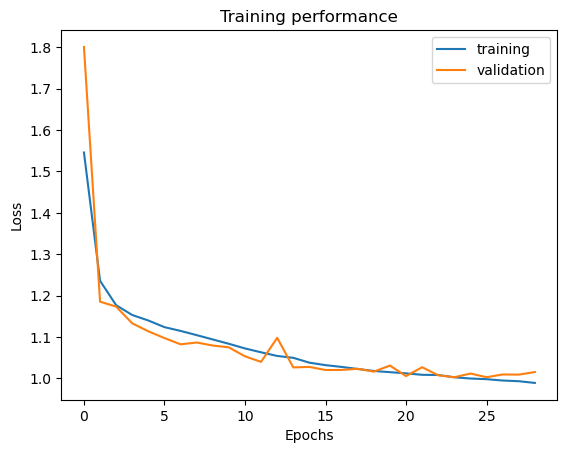

In [13]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

54/54 [==============================] - 3s 18ms/step


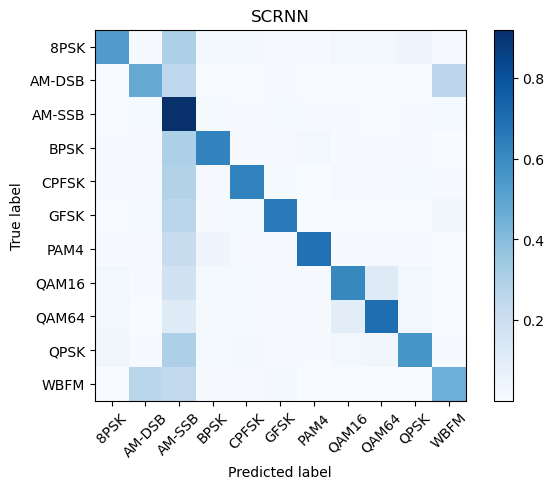

In [14]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

85/85 [==============================] - 2s 18ms/step
Overall Accuracy:  0.08358098068350668
85/85 [==============================] - 1s 16ms/step
Overall Accuracy:  0.09242144177449169
89/89 [==============================] - 2s 18ms/step
Overall Accuracy:  0.09437963944856839
89/89 [==============================] - 2s 18ms/step
Overall Accuracy:  0.12649332396345747
87/87 [==============================] - 2s 18ms/step
Overall Accuracy:  0.16257225433526012
88/88 [==============================] - 1s 16ms/step
Overall Accuracy:  0.22914428929466524
88/88 [==============================] - 1s 16ms/step
Overall Accuracy:  0.37800071658903617
86/86 [==============================] - 2s 17ms/step
Overall Accuracy:  0.5668604651162791
89/89 [==============================] - 2s 20ms/step
Overall Accuracy:  0.7209797657082002
87/87 [==============================] - 2s 18ms/step
Overall Accuracy:  0.8271028037383178
87/87 [==============================] - 2s 18ms/step
Overall Accuracy:  

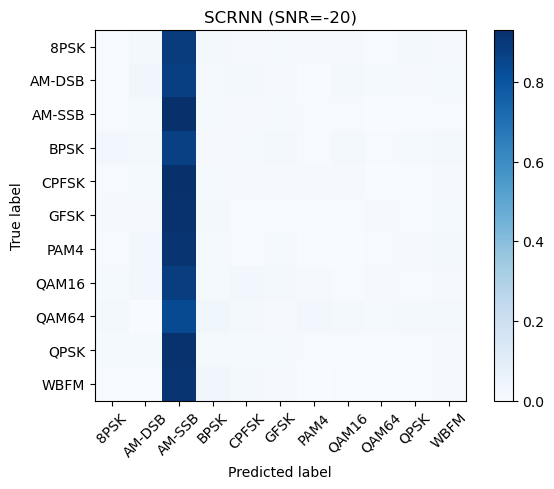

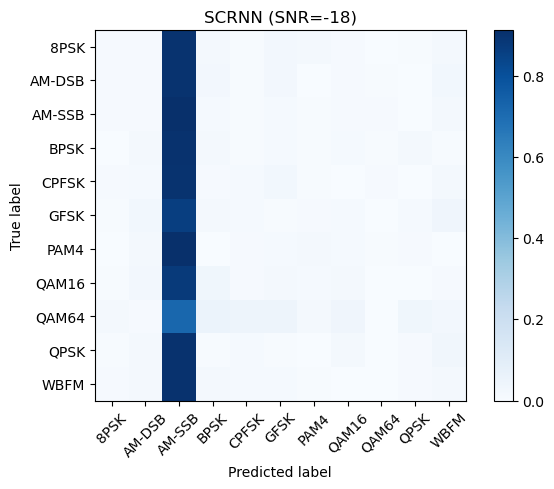

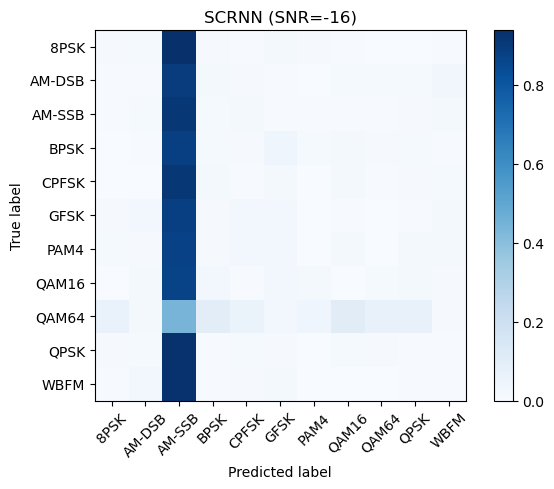

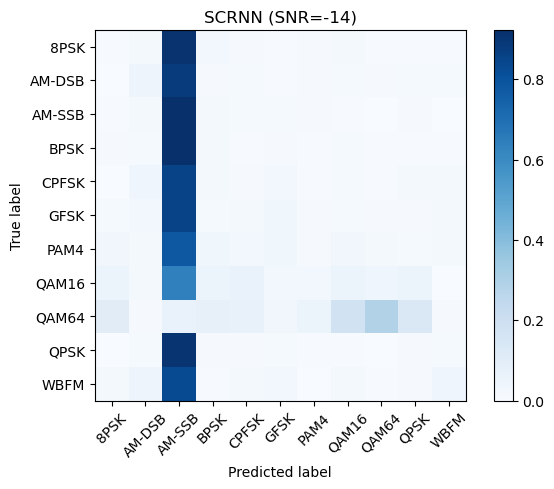

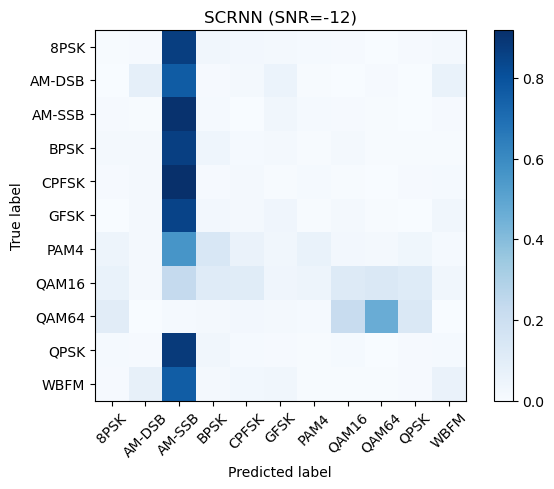

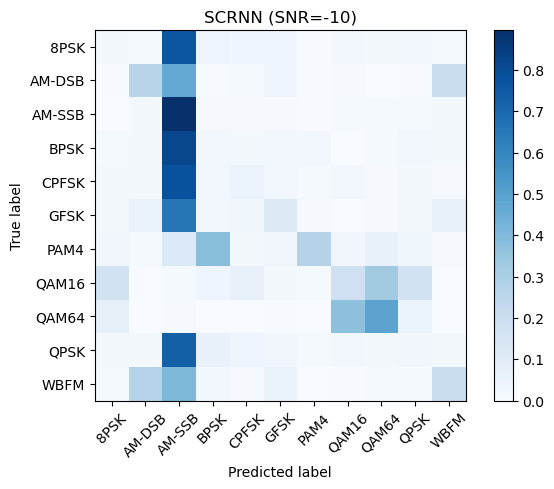

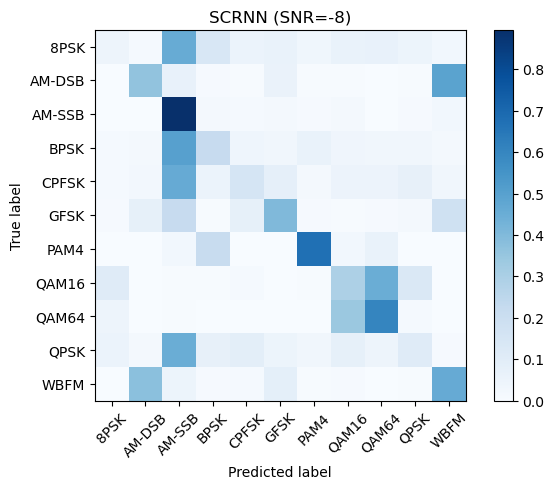

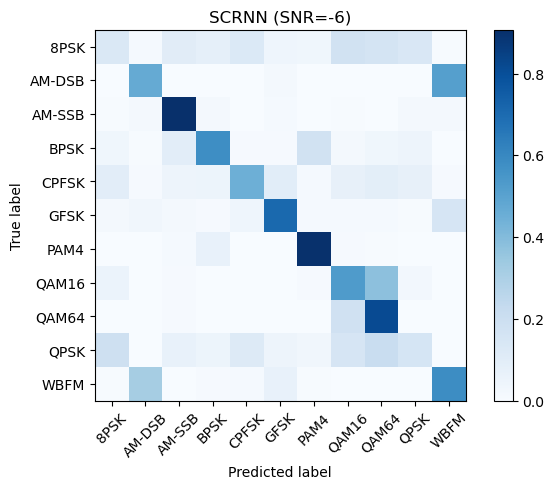

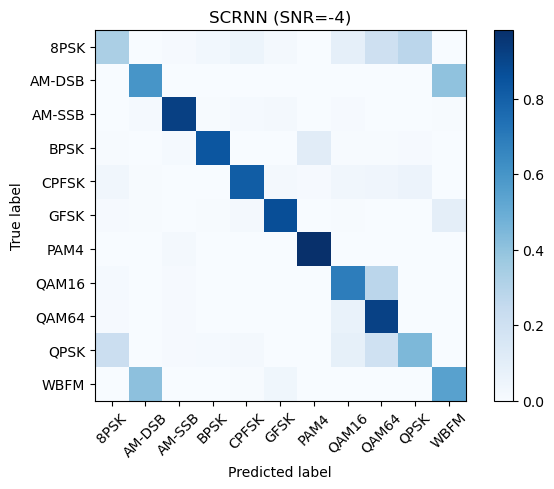

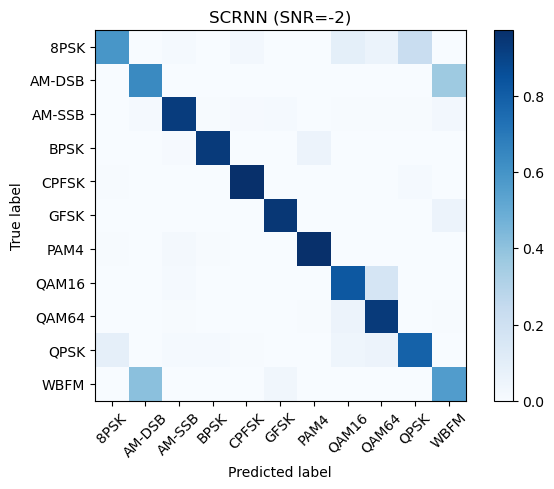

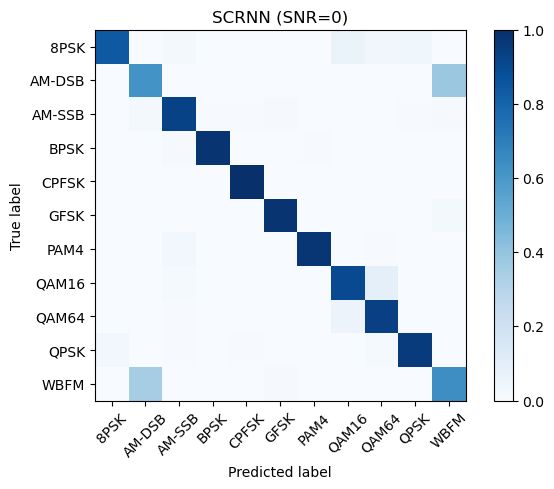

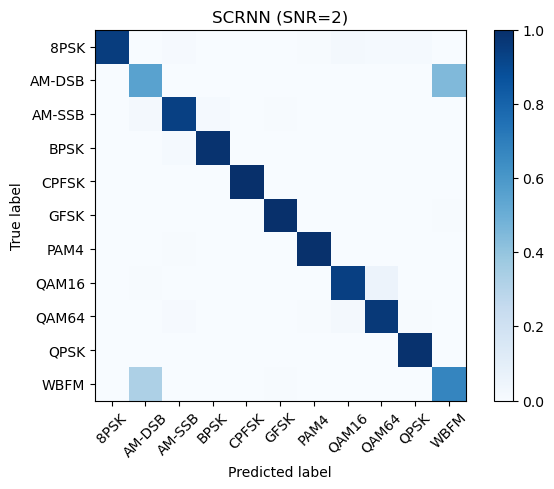

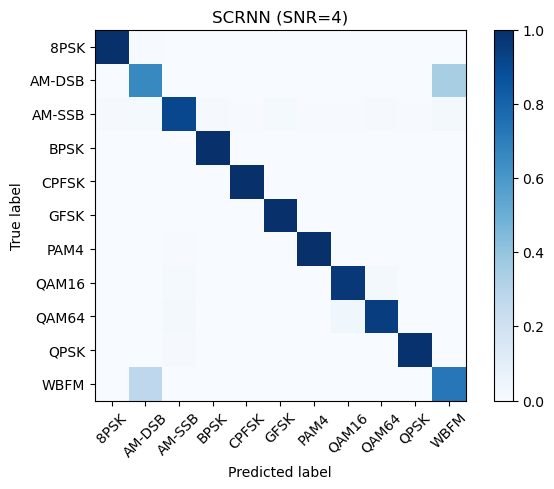

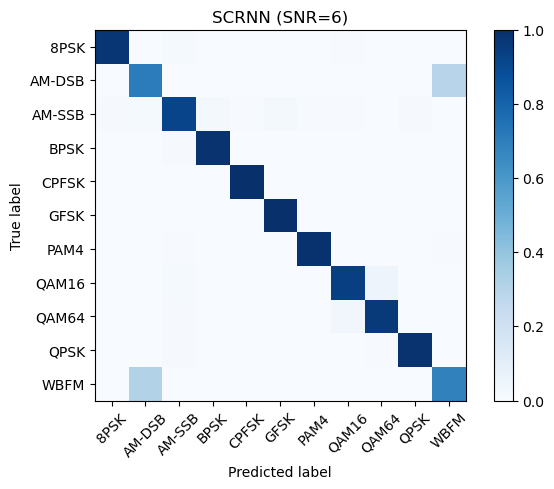

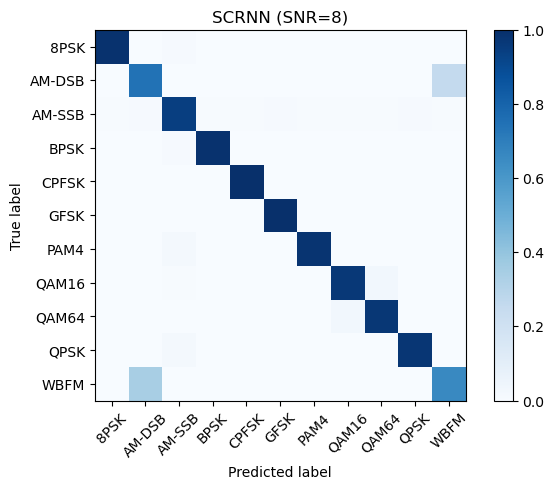

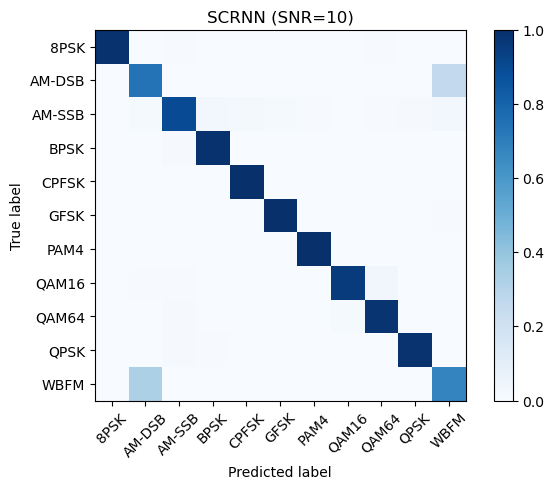

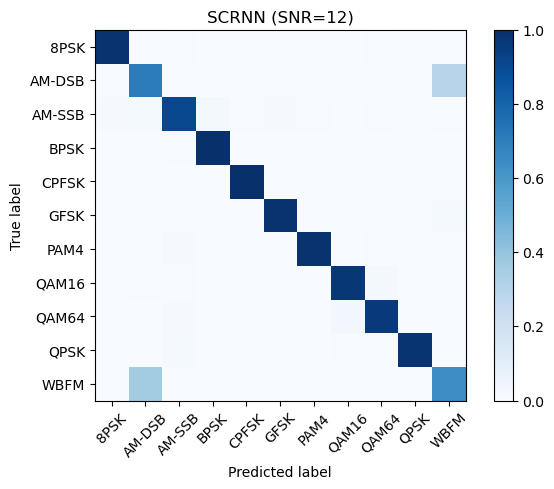

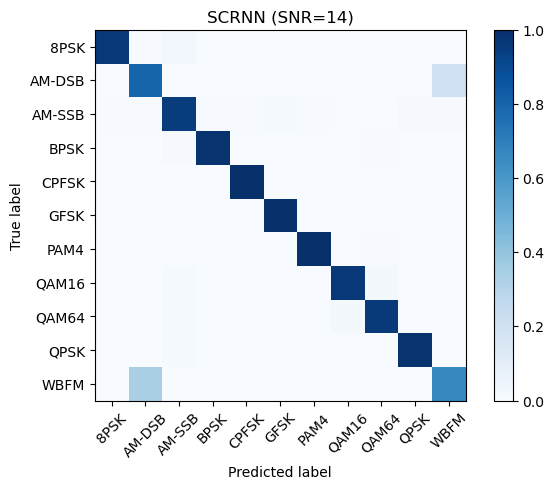

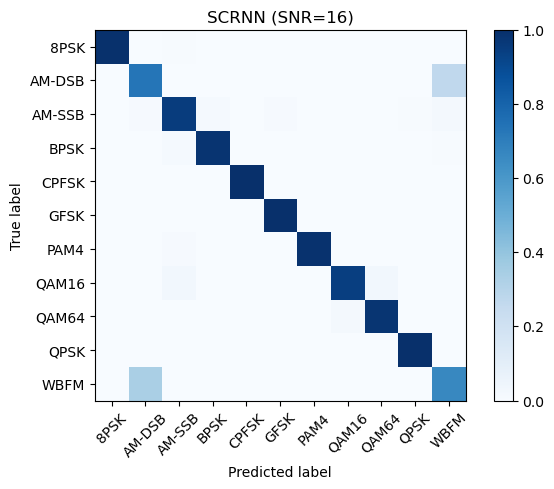

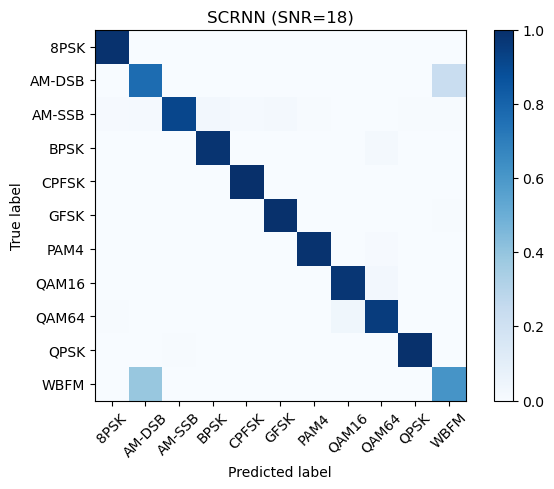

In [15]:
X_test = X_test.numpy() if hasattr(X_test, 'numpy') else X_test
Y_test = Y_test.numpy() if hasattr(Y_test, 'numpy') else Y_test

acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [16]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,12,16,22,37,56,72,82,88,90,92,92,93,92,92,93,92,92


In [17]:
import statistics

statistics.mean(acc.values())

0.6244895617176979

In [20]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )
# Save results to a pickle file for plotting later
import pickle

with open("SCRNN_rotation_history.pkl", "wb") as f:
    pickle.dump(history.history, f)
    
OUTPUT_FILENAME = 'SCRNN_rotation_acc.pkl'
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("SCRNN_rotation", acc) , fd )

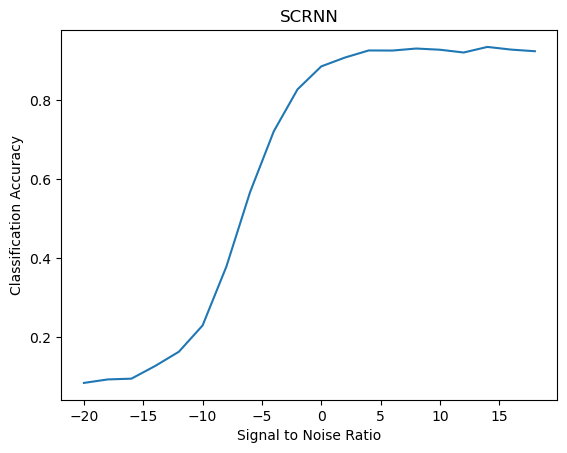

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)